### Step 0 - import libraries

In [3]:
# data wrangling & visualization
import numpy               as np
import pandas              as pd
import matplotlib.pyplot   as plt
import seaborn             as sns
%matplotlib inline
from subprocess              import check_output
from matplotlib.ticker       import StrMethodFormatter
from numpy                   import mean

# models
import xgboost             as xgb

from xgboost                 import XGBClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import Ridge
from sklearn.linear_model    import Lasso
from sklearn.ensemble        import GradientBoostingClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier
from sklearn.linear_model    import SGDClassifier
from sklearn.kernel_ridge    import KernelRidge
from sklearn.linear_model    import ElasticNet
from sklearn.base            import BaseEstimator
from sklearn.tree            import DecisionTreeClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn                 import svm
from sklearn.linear_model    import LogisticRegression

# preprocessing & feature engineering
from sklearn.compose           import ColumnTransformer
from sklearn.preprocessing     import FunctionTransformer
from sklearn.pipeline          import Pipeline
from sklearn.preprocessing     import OneHotEncoder
from sklearn.impute            import SimpleImputer
from sklearn.preprocessing     import StandardScaler
from scipy                     import stats
from sklearn.preprocessing     import KBinsDiscretizer
from sklearn.model_selection   import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing     import MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_classif
# conda install -c conda-forge imbalanced-learn 
from imblearn.over_sampling    import SMOTE
from imblearn.pipeline         import Pipeline as imbpipeline
from sklearn.pipeline          import Pipeline

# validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics         import accuracy_score
from sklearn                 import metrics
from sklearn.metrics         import matthews_corrcoef
from sklearn.metrics         import precision_recall_curve
#from sklearn.metrics         import plot_precision_recall_curve
from sklearn.metrics         import average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics         import roc_auc_score
from sklearn.metrics         import make_scorer
from sklearn.metrics         import precision_score, accuracy_score, recall_score, f1_score

# warning, errors...
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import time
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


### Step 1 - read data

  - List the data you need and how much you need.

  - Find and document where you can get the data.

  - Check how much space it will take.

  - Check legal obligations, and get authorizations if necessary.

  - Get access authorizations.

  - Create a workspace (with enough storage space).

  - Get the data.

  - Convert the data to a format you can easily manipulate (without changing the data itself).

  - Ensure sensitive information is deleted or protected (e.g. anonymized).

  - Check the size and type of data (time series, sample, geographical, etc.).

  - Sample a test set, put it aside, and never look at it (no data snooping!).

In [4]:
%time %memit
PATH = '/home/florianriemann/data_science_portfolio/boot_camp/data/titanic/'

df_titanic, df_titanic.name = pd.read_csv(PATH + 'train.csv'), 'df_titanic'
df_titanic.set_index(['PassengerId'], inplace=True)
df_titanic.head(2)

peak memory: 257.56 MiB, increment: 0.45 MiB
CPU times: user 104 ms, sys: 28.3 ms, total: 132 ms
Wall time: 304 ms


Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   

             SibSp  Parch     Ticket     Fare Cabin Embarked  
PassengerId                                                   
1                1      0  A/5 21171   7.2500   NaN        S  
2                1      0   PC 17599  71.2833   C85        C

### Step 2 - train-test-split

<hr style="border:2px solid black">

*Don't get biased by any stretch of the imagination. Do the train-test-split as early as possible!*

<hr style="border:2px solid black">

In [5]:
%time %memit
X = df_titanic.loc[:, ~df_titanic.columns.isin(['Survived'])]
y = df_titanic.loc[:,  df_titanic.columns.isin(['Survived'])]

peak memory: 259.04 MiB, increment: 0.19 MiB
CPU times: user 79.7 ms, sys: 54.9 ms, total: 135 ms
Wall time: 270 ms


In [6]:
%time %memit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)

peak memory: 259.29 MiB, increment: 0.00 MiB
CPU times: user 79.9 ms, sys: 50.9 ms, total: 131 ms
Wall time: 267 ms


### Step 3 - exploratory data analysis

#### Step 3.0 - workflow

  - Create a copy of the data exploration (sampling it down to a manageble size if necessary).

  - Create a notebook to keep a record of your data exploration.

  - Study each attribute and its characteristics:

    - Name
    - Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
    - % of missing values
    - Noisiness and type of noise (stoxastoc, outliers, rounding errors, etc.)
    - Possibly useful for the task?
    - Type of distribution (Gaussian, uniform, logarithmic, etc.)
  - For supervised learning tasks, identify target attribute(s).

  - Visualize the data.

  - Study the correlation between attributes.

  - Study how you would solve the problem manually.

  - Identify the promising transformations you may want to apply.

  - Identify extra data that would be useful.

  - Document what you have learned.

#### Step 3.1 - general overview

##### **Categorical:**

- `Nominal`

>- <u>Cabin</u> - Cabin number   
>- <u>Embarked</u> - Port of Embarkation ( C = Cherbourg | Q = Queenstown | S = Southampton )

- `Dichotomous`

>- <u>Sex</u> - ( Female | Male )

- `Ordinal`
    
>- <u>Pclass</u> - Ticket class ( 1 = 1st | 2 = 2nd | 3 = 3rd )
    * A proxy for socio-economic status (SES)
        - 1st = Upper
        - 2nd = Middle
        - 3rd = Lower

##### **Numeric:**

- `Discrete`

>- <u>Passenger ID</u>
>- <u>SibSp</u> - # of siblings / spouses aboard the Titanic	
    * sibsp: The dataset defines family relations in this way...
        - Sibling = brother, sister, stepbrother, stepsister
        - Spouse  = husband, wife (mistresses and fiancés were ignored)
>- <u>Parch</u> - # of parents / children aboard the Titanic
    * parch: The dataset defines family relations in this way...
        - Parent = mother, father
        - Child  = daughter, son, stepdaughter, stepson
        - Some children travelled only with a nanny, therefore parch = 0 for them.
>- <u>Survived</u> - ( 0 = Not Survived | 1 = Surived ) 

- `Continous`

>- <u>Age</u> - Age in years
    * Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

>- <u>Fare</u> - Passenger fare

##### **Text:**

- <u>Ticket</u> - Ticket number
- <u>Name</u> - Name of passenger

In [7]:
%time %memit
# for the EDA we will only use the training data, that includes the input vector as well as the labels
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()

peak memory: 259.43 MiB, increment: 0.00 MiB
CPU times: user 83.5 ms, sys: 40.9 ms, total: 124 ms
Wall time: 263 ms


Pclass                                               Name  \
PassengerId                                                              
9                 3  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   
151               2                         Bateman, Rev. Robert James   
222               2                               Bracken, Mr. James H   
366               3                     Adahl, Mr. Mauritz Nils Martin   
325               3                           Sage, Mr. George John Jr   

                Sex   Age  SibSp  Parch       Ticket     Fare Cabin Embarked  \
PassengerId                                                                    
9            female  27.0      0      2       347742  11.1333   NaN        S   
151            male  51.0      0      0  S.O.P. 1166  12.5250   NaN        S   
222            male  27.0      0      0       220367  13.0000   NaN        S   
366            male  30.0      0      0       C 7076   7.2500   NaN        S   
325            male   NaN      8      2     CA. 2343  69.5500   NaN        S   

             Survived  
PassengerId            
9                   1  
151                 0  
222                 0  
366                 0  
325                 0

In [8]:
df_train.shape

(712, 11)

In [9]:
# we get a first impression of missing data in Age, Cabin and Embarked. 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 9 to 844
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Name      712 non-null    object 
 2   Sex       712 non-null    object 
 3   Age       570 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Ticket    712 non-null    object 
 7   Fare      712 non-null    float64
 8   Cabin     151 non-null    object 
 9   Embarked  711 non-null    object 
 10  Survived  712 non-null    int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


In [10]:
list(df_train.columns)

['Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'Survived']

In [11]:
# in further analysis I will mainly distinguish between numerical and categorical features
cat_features = []
num_features = ['Survived']
for col in df_train.columns:
    if str(df_train[col].dtype) == 'float64':
        num_features.append(col)
    else:
        cat_features.append(col)

In [12]:
cat_features

['Pclass',
 'Name',
 'Sex',
 'SibSp',
 'Parch',
 'Ticket',
 'Cabin',
 'Embarked',
 'Survived']

In [13]:
num_features

['Survived', 'Age', 'Fare']

#### Step 3.2 - descriptive statistics

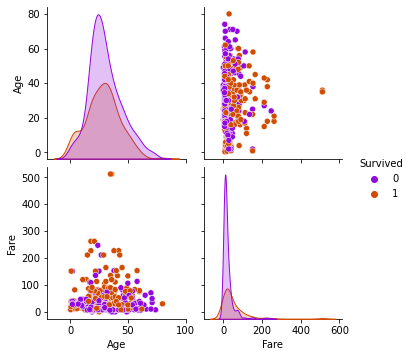

In [14]:
# It looks like there is a correlation between age and survival rate 
# as well as between fare and survival rate, meaning the higher there fare / age 
# the higher the chances to survive.
# The distribution of the age looks gaussian'ish and the distribution of fare is highly skewed.
sns.pairplot(  df_train[num_features]
             , hue       = "Survived"
             , palette   = "gnuplot"
             , diag_kind = "kde"
             , height    = 2.5
            );

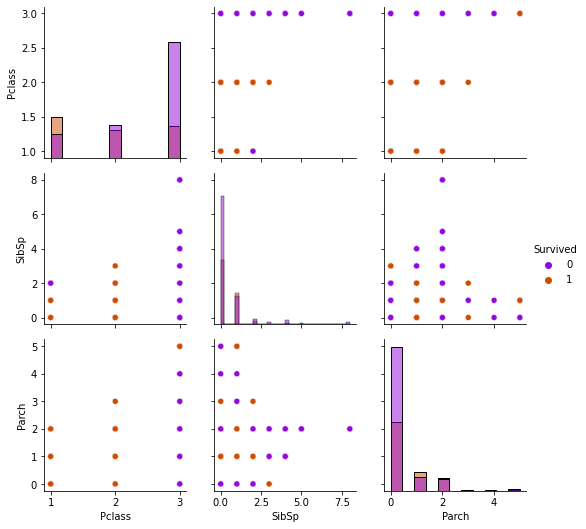

In [15]:
# As it is to be expected there might be a correlation between the PClass and the survival rate,
# so the chances to survive are the highest for class 1 and lowest for class 3.
# Furthermore there is a strong impact on the survival rate based on the number of relatives 
# someone is travelling with. Those who travelled in the 1st or 2nd class with relatives most likely survived.

g = sns.PairGrid(df_train[cat_features], hue = "Survived",  palette = "gnuplot")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

In [16]:
# get a glance through the descriptive statistics
df_train.describe()

Pclass         Age       SibSp       Parch        Fare    Survived
count  712.000000  570.000000  712.000000  712.000000  712.000000  712.000000
mean     2.303371   29.495193    0.491573    0.356742   32.133941    0.369382
std      0.828867   14.169135    1.093356    0.782534   50.508682    0.482977
min      1.000000    0.420000    0.000000    0.000000    0.000000    0.000000
25%      2.000000   20.000000    0.000000    0.000000    7.895800    0.000000
50%      3.000000   28.000000    0.000000    0.000000   13.500000    0.000000
75%      3.000000   38.000000    1.000000    0.000000   31.068750    1.000000
max      3.000000   80.000000    8.000000    5.000000  512.329200    1.000000

In [17]:
# are there any duplicated rows?
df_train.duplicated().sum()

0

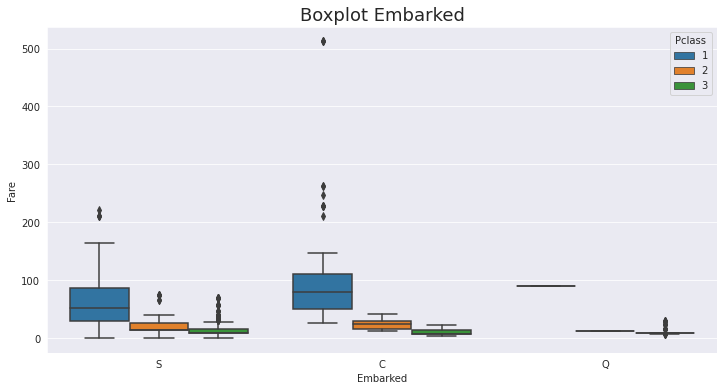

In [18]:
# Regarding the embarkation some of the most expensive tickets were sold to passengers who embarked in 
# Cherbourg. The price for tickets who embarked in Queenstown is very little which might be 
# associated with the number of passengers.
# C = Cherbourg | Q = Queenstown | S = Southampton
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (12,6), ncols = 1)
ax      = sns.boxplot(  x    = "Embarked"
                      , y    = "Fare"
                      , hue  = "Pclass"
                      , data = df_train)
ax.set_title("Boxplot Embarked", fontsize = 18);

In [19]:
# lets look for missing data
data_missing_values = df_train.isna().mean().round(4) * 100
data_missing_values = data_missing_values.to_frame()
data_missing_values = data_missing_values.rename(columns = {0:'percentage of nan'})
data_missing_values

percentage of nan
Pclass                 0.00
Name                   0.00
Sex                    0.00
Age                   19.94
SibSp                  0.00
Parch                  0.00
Ticket                 0.00
Fare                   0.00
Cabin                 78.79
Embarked               0.14
Survived               0.00

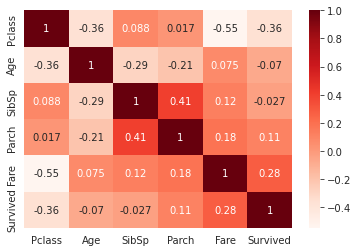

In [20]:
# Correlation:
#    - Fare & PClass | -0.36
#    - Parch & SibSp |  0.41
# Most interestingly we see a correlation between survived and fare of 0.28 and pclass and survived of -0.36.
sns.heatmap(df_train.corr(),cmap="Reds",annot=True);

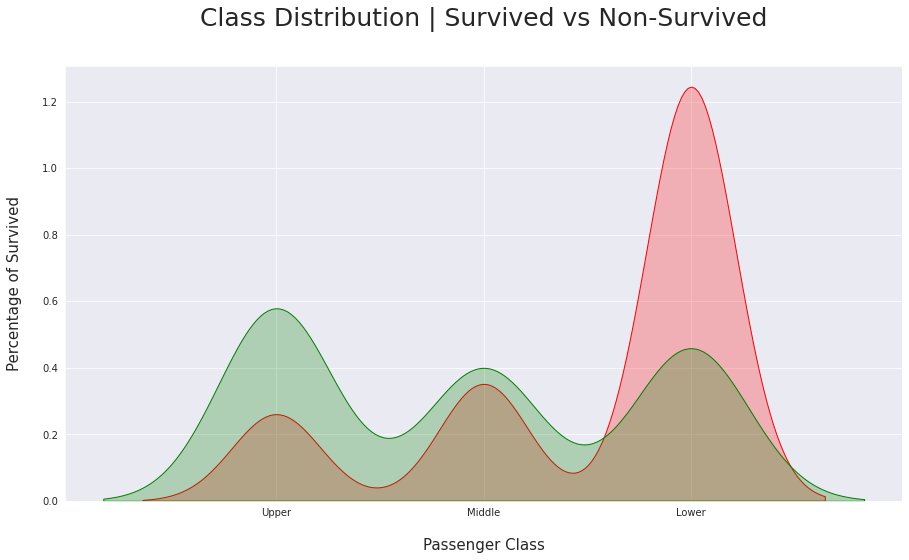

In [21]:
# Kernel Density Plot for Pclass
# As expected and concluded from above being a passenger in the third class reduced the chance to survive drastically.
fig = plt.figure(figsize=(15,8),)

ax = sns.kdeplot(  df_train.loc[(df_train['Survived'] == 0),'Pclass']
                 , color = 'red'
                 , shade = True
                 , label = 'Not Survived'
                )

ax = sns.kdeplot(  df_train.loc[(df_train['Survived'] == 1),'Pclass']
                 , color = 'green'
                 , shade = True
                 , label = 'Survived'
              )

plt.title('Class Distribution | Survived vs Non-Survived' , fontsize = 25, pad      = 40)
plt.ylabel("Percentage of Survived"                       , fontsize = 15, labelpad = 20)
plt.xlabel("Passenger Class"                              , fontsize = 15, labelpad = 20)
labels = ['Upper', 'Middle', 'Lower']
plt.xticks(sorted(df_train.Pclass.unique()), labels);

''

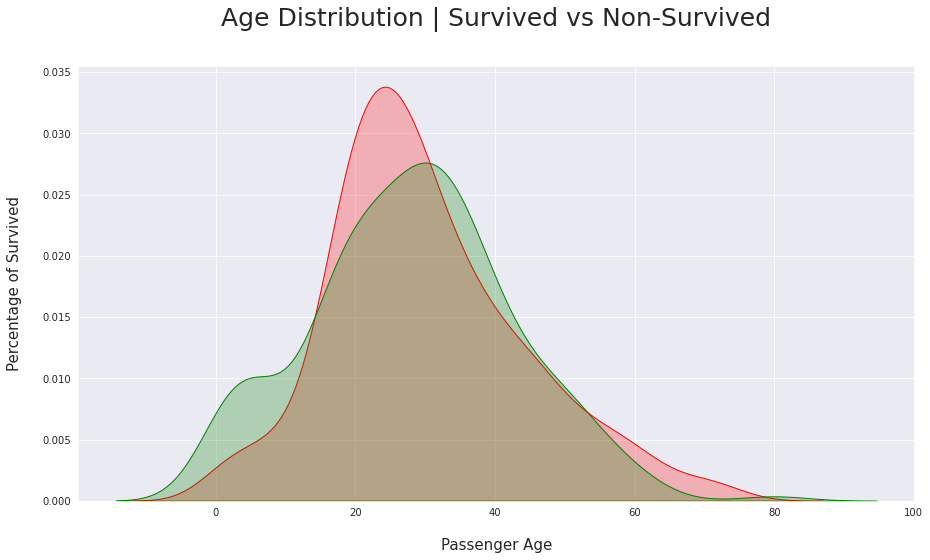

In [22]:
# Kernel Density Plot for Age
# Being in the age between approximately 17 and 35 as well as 55+ increased the probability not to survive.
fig = plt.figure(figsize=(15,8),)

ax = sns.kdeplot(  df_train.loc[(df_train['Survived'] == 0),'Age']
                 , color = 'red'
                 , shade = True
                 , label = 'Not Survived'
                )

ax = sns.kdeplot(  df_train.loc[(df_train['Survived'] == 1),'Age']
                 , color = 'green'
                 , shade = True
                 , label = 'Survived'
              )

plt.title('Age Distribution | Survived vs Non-Survived'   , fontsize = 25, pad      = 40)
plt.ylabel("Percentage of Survived"                       , fontsize = 15, labelpad = 20)
plt.xlabel("Passenger Age"                                , fontsize = 15, labelpad = 20)
;

#### Step 3.3 - observe some features in more detail

##### Step 3.2.1 - PassengerId

In [23]:
# no valuable information

##### Step 3.2.2 - Pclass

In [24]:
# The chances of survival are in class 2 almost equal.
df_train.groupby(['Pclass','Survived']).size().unstack('Survived')

Survived    0    1
Pclass            
1          63  106
2          85   73
3         301   84

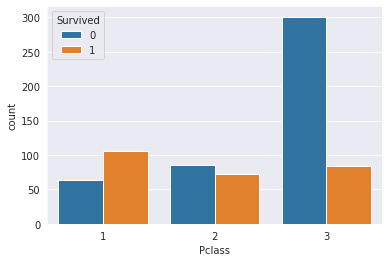

In [25]:
# the higher the class the higher the survival rate.  
# there is a higher probality to not survive in the 3rd class
sns.countplot(data=df_train,x=df_train['Pclass'],hue='Survived'); 

##### Step 3.2.3 - Name

In [26]:
df_train[['Name']].head(3)

Name
PassengerId                                                   
9            Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
151                                 Bateman, Rev. Robert James
222                                       Bracken, Mr. James H

In [27]:
# As seen there is some more information in this feature contained than just a name.
# I split the feature along the commas into two columns, so that I get the lstname and a combination 
# of the firstname and the titke that needs to be split afterwards once again.
df_train_names = df_train["Name"].str.split(',', expand=True)
df_train_names.rename(columns={0:'Lastname', 1:'title_and_firstname'}, inplace=True)
df_train_names.head(3)

Lastname                        title_and_firstname
PassengerId                                                    
9            Johnson   Mrs. Oscar W (Elisabeth Vilhelmina Berg)
151          Bateman                          Rev. Robert James
222          Bracken                                Mr. James H

In [28]:
# get the title from title_and_firstname
df_train_titles = df_train_names["title_and_firstname"].str.split(' ', expand=True)
df_train_titles.rename(columns={1:'Title'}, inplace=True)
df_train_titles = df_train_titles[["Title"]]
df_train_titles.head(3)

Title
PassengerId      
9            Mrs.
151          Rev.
222           Mr.

In [29]:
# Check the titles. 
df_train_titles["Title"].unique()

array(['Mrs.', 'Rev.', 'Mr.', 'Major.', 'Master.', 'Miss.', 'Lady.',
       'Jonkheer.', 'Dr.', 'Col.', 'Mlle.', 'Ms.', 'Sir.', 'Capt.',
       'Don.', 'the'], dtype=object)

In [30]:
# Concat df_train, df_train_names, df_train_titles
df_train = pd.concat([df_train, df_train_titles, df_train_names], axis=1)
df_train.head()

Pclass                                               Name  \
PassengerId                                                              
9                 3  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   
151               2                         Bateman, Rev. Robert James   
222               2                               Bracken, Mr. James H   
366               3                     Adahl, Mr. Mauritz Nils Martin   
325               3                           Sage, Mr. George John Jr   

                Sex   Age  SibSp  Parch       Ticket     Fare Cabin Embarked  \
PassengerId                                                                    
9            female  27.0      0      2       347742  11.1333   NaN        S   
151            male  51.0      0      0  S.O.P. 1166  12.5250   NaN        S   
222            male  27.0      0      0       220367  13.0000   NaN        S   
366            male  30.0      0      0       C 7076   7.2500   NaN        S   
325            male   NaN      8      2     CA. 2343  69.5500   NaN        S   

             Survived Title Lastname  \
PassengerId                            
9                   1  Mrs.  Johnson   
151                 0  Rev.  Bateman   
222                 0   Mr.  Bracken   
366                 0   Mr.    Adahl   
325                 0   Mr.     Sage   

                                   title_and_firstname  
PassengerId                                             
9             Mrs. Oscar W (Elisabeth Vilhelmina Berg)  
151                                  Rev. Robert James  
222                                        Mr. James H  
366                            Mr. Mauritz Nils Martin  
325                                 Mr. George John Jr

In [31]:
# The chances of survival are in class 2 almost equal.
# Female titles like Miss and Mrs indicate a higher chance to survive as well as beeing Master.
# In contrast the titles Mr indicates a high chance to not survive.
# Interestingly all 5 Rev. in this sample died that might be worth to consider later on.
df_train.groupby(['Title','Survived']).size().unstack('Survived')

Survived       0      1
Title                  
Capt.        1.0    NaN
Col.         1.0    1.0
Don.         1.0    NaN
Dr.          4.0    3.0
Jonkheer.    1.0    NaN
Lady.        NaN    1.0
Major.       1.0    1.0
Master.     12.0   17.0
Miss.       43.0  100.0
Mlle.        NaN    2.0
Mr.        361.0   61.0
Mrs.        19.0   74.0
Ms.          NaN    1.0
Rev.         5.0    NaN
Sir.         NaN    1.0
the          NaN    1.0

##### Step 3.2.4 - Sex

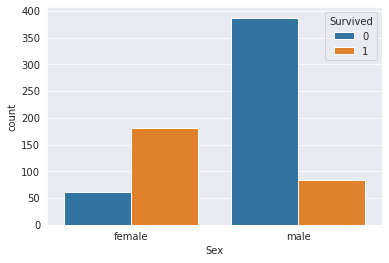

In [32]:
# check survival rate by sex
sns.countplot(data=df_train,x=df_train['Sex'],hue='Survived');
# sex tends to have an effect on the survival rate

In [33]:
# For women in the first and second class the probability to survive is very high.
# However, the social-economic status has a stronger influence than the sex.
df_train.groupby(['Sex','Pclass','Survived']).size().unstack('Survived')

Survived         0   1
Sex    Pclass         
female 1         2  71
       2         6  61
       3        54  48
male   1        61  35
       2        79  12
       3       247  36

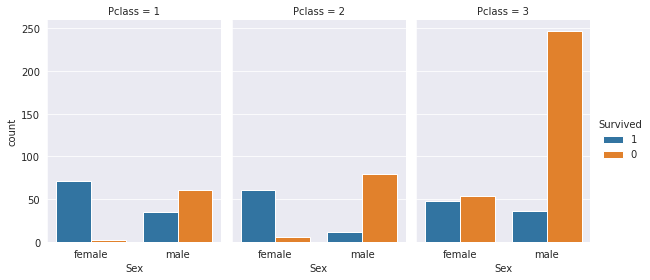

In [34]:
sns.catplot(data=df_train,x="Sex",hue="Survived",col="Pclass", kind="count", height=4, aspect=.7, hue_order=[1,0])

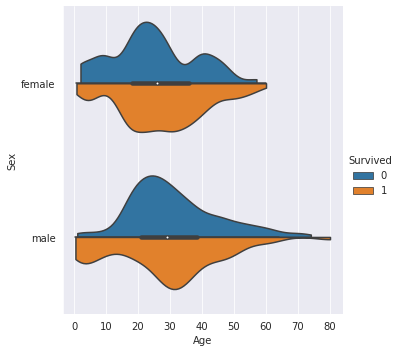

In [35]:
sns.catplot(data=df_train, x="Age", y="Sex", hue="Survived", kind="violin", bw=.25, cut=0, split=True)

##### Step 3.2.5 - Age

In [36]:
# min age and max age
max_age = df_train["Age"].max()
min_age = df_train["Age"].min()

print(
        'max Age: ', max_age,  '\n'
      , 'min Age: ', min_age
)

max Age:  80.0 
 min Age:  0.42


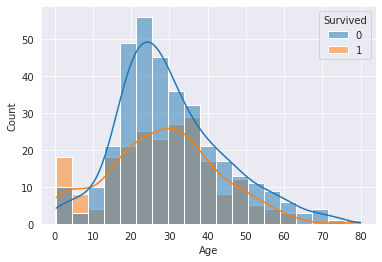

In [37]:
# The distribution of the age shows that certain age groups, especially in the range from approx. 17 to 30 
# have a relativly low probalitiy to survive as well es the elder passengers (50+)
sns.histplot(data=df_train,x=df_train['Age'],hue='Survived', stat='count', kde=True);

##### Step 3.2.6 - SibSp

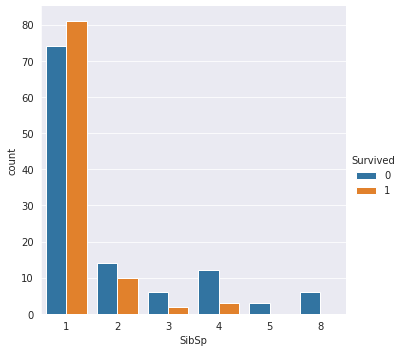

In [38]:
# Passengers with one or maximum two SibSp on board survived far mor often than those with 2+ SibSp on board 
sns.catplot(data=df_train[df_train['SibSp'] > 0], kind='count', x='SibSp', hue='Survived');

In [39]:
df_train.groupby(['SibSp','Survived']).size().unstack('Survived')

Survived      0      1
SibSp                 
0         334.0  167.0
1          74.0   81.0
2          14.0   10.0
3           6.0    2.0
4          12.0    3.0
5           3.0    NaN
8           6.0    NaN

##### Step 3.2.7 - Parch

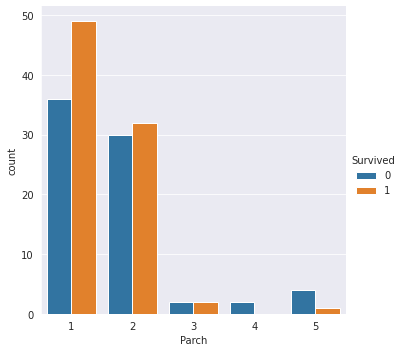

In [40]:
# the parent-child relation on board also of a strong influence on the survival rate
sns.catplot(data=df_train[df_train['Parch'] > 0], kind='count', x='Parch', hue='Survived');

In [41]:
# Parch: # of parents / children aboard the Titanic
df_train["Parch"].unique()

array([2, 0, 1, 3, 4, 5])

##### Step 3.2.8 - Ticket

In [42]:
# Do ticket numbers occur more than once? 
# Probalbly some passengers travel on one ticket (eg family tickets)
df_train.groupby(['Ticket'])[['Ticket']].count()

Ticket
Ticket             
110152            3
110413            3
110465            2
110564            1
110813            1
...             ...
W./C. 14263       1
W./C. 6608        4
W.E.P. 5734       1
W/C 14208         1
WE/P 5735         2

[578 rows x 1 columns]

In [43]:
df_train['occ_of_ticket'] = df_train.groupby(['Ticket'])['Ticket'].transform('count')
df_train.head(3)

Pclass                                               Name  \
PassengerId                                                              
9                 3  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   
151               2                         Bateman, Rev. Robert James   
222               2                               Bracken, Mr. James H   

                Sex   Age  SibSp  Parch       Ticket     Fare Cabin Embarked  \
PassengerId                                                                    
9            female  27.0      0      2       347742  11.1333   NaN        S   
151            male  51.0      0      0  S.O.P. 1166  12.5250   NaN        S   
222            male  27.0      0      0       220367  13.0000   NaN        S   

             Survived Title Lastname  \
PassengerId                            
9                   1  Mrs.  Johnson   
151                 0  Rev.  Bateman   
222                 0   Mr.  Bracken   

                                   title_and_firstname  occ_of_ticket  
PassengerId                                                            
9             Mrs. Oscar W (Elisabeth Vilhelmina Berg)              2  
151                                  Rev. Robert James              1  
222                                        Mr. James H              1

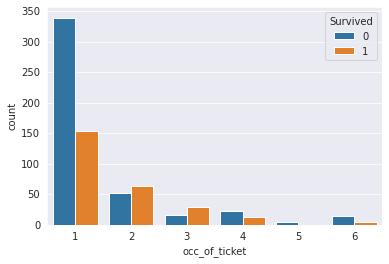

In [44]:
# Tickets that are connected to two or three persons seem to increase the probabilty to survive.
sns.countplot(data=df_train,x=df_train['occ_of_ticket'],hue='Survived');

##### Step 3.2.9 - Fare

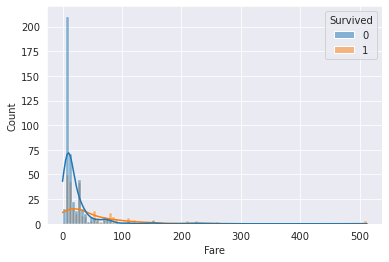

In [45]:
# Distribution of the fare and plotting survived and not survived.
# The more expensive the fare the higher the chances to survive
sns.histplot(data=df_train,x=df_train['Fare'],hue='Survived', stat='count', kde=True);

##### Step 3.2.10 - Cabin

In [46]:
df_train[df_train["Cabin"].notnull()][["Cabin"]]

Cabin
PassengerId         
450             C104
340                T
171              B19
497              D20
557              A16
...              ...
292              B49
270              C99
631              A23
474                D
391          B96 B98

[151 rows x 1 columns]

In [47]:
# It could be an approach to use the letter code, 
# which could possibly indicate the deck or any other location on the titanic
df_train["Cabin"] = df_train["Cabin"].str.replace('\d+', '')
df_train["Cabin"] = df_train["Cabin"].str.replace(' ', '')
df_train.rename(columns={'Cabin':'Cabin_Category'}, inplace=True)

df_train[df_train["Cabin_Category"].notnull()][["Cabin_Category"]]

Cabin_Category
PassengerId               
450                      C
340                      T
171                      B
497                      D
557                      A
...                    ...
292                      B
270                      C
631                      A
474                      D
391                     BB

[151 rows x 1 columns]

In [48]:
df_train["Cabin_Category"].unique()

array([nan, 'C', 'T', 'B', 'D', 'A', 'E', 'BBBB', 'BB', 'BBB', 'G', 'F',
       'CC', 'FE', 'FG'], dtype=object)

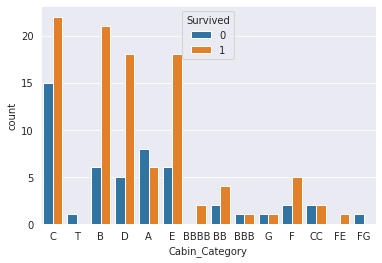

In [49]:
# Having a cabin leads mostly to a higher probabilty to survive, especially for the cabin categories B, D, E and F
sns.countplot(  data  = df_train
              , x     = df_train['Cabin_Category']
              , hue   = 'Survived'
             ); 

##### Step 3.2.11 - Embarked

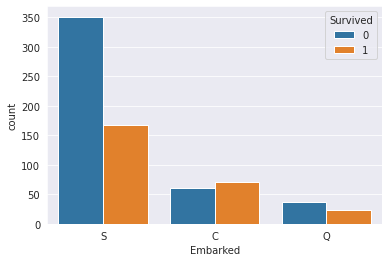

In [50]:
# Who embarked in S, C and Q? Did in C embark mainly blue collar?
sns.countplot(  data  = df_train
              , x     = df_train['Embarked']
              , hue   = 'Survived'
             ); 

##### Step 3.2.12 - Survived

<AxesSubplot:xlabel='Survived', ylabel='count'>

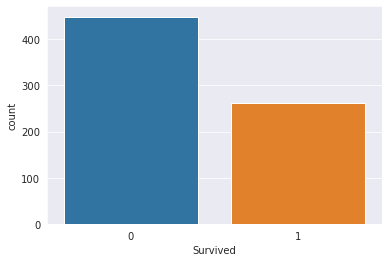

In [51]:
# Are we dealing with imbalanced data?
sns.countplot(x=df_train["Survived"]) 
# data is only slightly imbalanced

### **Conclusion from the EDA**

<hr style="border:2px solid black">

	- Embarked: impute missing vaalues with mode, encoding

    - Age: impute missing values by mean grouped by Pclass and Sex, remove outliers, standardize, dicretize (5 years)

    - Fare: impute missing values with mean grouped by Pclass and Embarked, standardize

	- Cabin: impute missing values with "-", extract the cabon category, encoding

	- Name: extract the title, encoding 

	- Tickets: count no of ticket occurences, encoding

	- Pclass: encoding 

	- SibSp: encoding

	- Sex: encoding

	- Parch: encoding

	- Survived: balance the response variable with SMOTE (not for the baseline model)

	- use a random forest as a baseline model and get the feature importance

<hr style="border:2px solid black">

### Step 4 - cleaning & scaling

   - *Fix or remove outliers (otional).*
   - *Fill in missing values (e.g. with zero, mean, median ...) or drop their rows (or columns).*
   - *Standadize or nomalize features*

#### Step 4.1 - impute missing values

**Embarked**

In [52]:
# Embarked: impute missing values with mode 
def embarked_imp(dataframe):
    dataframe['Embarked'].fillna(dataframe['Embarked'].mode()[0], inplace=True)
    return dataframe

**Age**

In [53]:
# Age: impute missing values with mean grouped by Pclass and Sex
def age_imp(dataframe):
    groupmeans = dataframe.groupby(['Sex','Pclass'])['Age'].transform('mean')
    dataframe['Age'].fillna(groupmeans, inplace=True)
    return dataframe

**Fare**

In [54]:
# Fare: impute missing values with mean grouped by Pclass and Embarked
def fare_imp(dataframe):
    groupmeans = dataframe.groupby(['Embarked','Pclass'])['Age'].transform('mean')
    dataframe['Fare'].fillna(groupmeans, inplace=True)
    return dataframe

**Cabin**

In [55]:
# Cabin: impute missing values with '-'
def cabin_imp(dataframe):
    dataframe['Cabin'].fillna('-', inplace=True)
    return dataframe

#### Step 4.2 - scaling

In [56]:
################################################################################
### list of numeric features that will be needed for the numeric transformer ###
################################################################################
def num_feat(dataframe):
    cols_to_remove = ['PassengerId','Survived','Name','Ticket','title_and_firstname','Lastname']

    numerical_features = list(dataframe.select_dtypes(include=['float64']).columns)
    numerical_features = [col for col in numerical_features if col not in cols_to_remove]
    return numerical_features 

In [57]:
numerical_features = ['Age', 'Fare', 'Fare_log']

In [58]:
# standard scaler and simple imputer for floats (in case the test or production data contain missing data that couldn't be spotted during the training)
numeric_steps =     [('imputer' , SimpleImputer(strategy = 'mean')), 
                     ('scaler'  , StandardScaler()                )     
                    ]

numeric_transformer = Pipeline(numeric_steps)

#### Step 4.3 - interpolation

In [59]:
# not needed, because no time series

#### Step 4.4 - remove duplicates and outliers

In [60]:
def drop_dupl(dataframe):
    dataframe.drop_duplicates(inplace=True)
    return dataframe

**Age**

In [61]:
# remove data points that are 3sd+ from Age with z-score
def age_zscore(dataframe):
    z = np.abs(stats.zscore(dataframe['Age']))
    outlier = list(np.where(z > 3)[0])
    dataframe.drop(dataframe.index[outlier], inplace=True)
    return dataframe

### Step 5 - feature engineering

   - *Discretize continious features.*
   - *Decompose features (e.g. categorical, date/time, etc.).*
   - *Add promising transformations of features (e.g. log(x), sqrt(x), x^2, etc.).*
   - *Aggregate features into promising new features.*

#### Step 5.1 - feature extraction, decomposition and transformation

In [62]:
def name_extract(dataframe):
    df_names = dataframe["Name"].str.split(',', expand=True)
    df_names.rename(columns={0:'Lastname', 1:'title_and_firstname'}, inplace=True)
    
    df_titles = df_names["title_and_firstname"].str.split(' ', expand=True)
    df_titles.rename(columns={1:'Title'}, inplace=True)
    df_titles = df_titles[["Title"]]

    dataframe = pd.concat([dataframe, df_names, df_titles], axis=1)
    return dataframe

In [63]:
def fare_log(dataframe):
    dataframe['Fare_log'] = np.log(dataframe['Fare'], where = dataframe['Fare'] > 0)
    return dataframe

In [64]:
def cabin_extract(dataframe):
    dataframe["Cabin"] = dataframe["Cabin"].str.replace('\d+', '')
    dataframe["Cabin"] = dataframe["Cabin"].str.replace(' ', '')
    dataframe.rename(columns={'Cabin':'Cabin_Category'}, inplace=True)
    return dataframe

In [65]:
def ticket_occ(dataframe):
    dataframe['occ_of_ticket'] = dataframe.groupby(['Ticket'])['Ticket'].transform('count')
    return dataframe

#### Step 5.2 - encoding of categorical features

In [66]:
####################################################################################
### list of categorical features that will be needed for the numeric transformer ###
####################################################################################
def cat_feat(dataframe):
    cols_to_remove = ['PassengerId','Survived','Name','Ticket','title_and_firstname','Lastname']

    categorical_features = list(dataframe.select_dtypes(include=['int64','object']).columns)
    categorical_features = [col for col in categorical_features if col not in cols_to_remove]
    return categorical_features 

In [67]:
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin_Category', 'Embarked', 'Title', 'occ_of_ticket']

In [68]:
# standard scaler and simple imputer for floats (in case the test or production data contain missing data that couldn't be spotted during the training)
categorical_steps = [('imputer' , SimpleImputer(strategy       = 'most_frequent' )),
                     ('onehot'  , OneHotEncoder(handle_unknown = 'ignore'        ))
                    ]

categorical_transformer = Pipeline(categorical_steps)

#### Step 5.3 - discretizing of continious features

In [69]:
# dicetize the age into bins of five years
discretizer_step        = [('discretizer', KBinsDiscretizer(n_bins=5, encode='onehot', strategy='quantile', dtype=None, subsample='warn', random_state=None))]

discretizer_transformer = Pipeline(discretizer_step)

#### Step 5.4 - drop features

In [70]:
def drop_feat(dataframe):
    cols_to_remove = ['PassengerId','Survived','Name','Ticket','title_and_firstname','Lastname']
    dataframe.drop([x for x in cols_to_remove if x in dataframe.columns], axis=1, inplace=True)
    return dataframe

#### Step 5.5 - sampling strategy in case of imbalanced data

In [71]:
sample_step = [('smote', SMOTE(random_state=11))]

sample_transformer = Pipeline(sample_step)

#### Step 5.6 - implement polynomials

In [72]:
# not needed

### Step 6 - baseline model

#### Step 6.1 - create pipeline for the baseline model 

##### Step 6.1.1 - function and column transformer

In [73]:
# imputing 
embarked_transformer      = FunctionTransformer(embarked_imp)
age_transformer           = FunctionTransformer(age_imp)
fare_transformer          = FunctionTransformer(fare_imp)
cabin_transformer         = FunctionTransformer(cabin_imp)

# cleaning and preprocessing
num_feat_transformer      = FunctionTransformer(num_feat)
cat_feat_transformer      = FunctionTransformer(cat_feat)
drop_dupl_transformer     = FunctionTransformer(drop_dupl)

# extractions and transformations
name_extract_transformer  = FunctionTransformer(name_extract)
fare_log_transformer      = FunctionTransformer(fare_log)
cabin_extract_transformer = FunctionTransformer(cabin_extract)
ticket_occ_transformer    = FunctionTransformer(ticket_occ)

# drop features
drop_feat_transformer     = FunctionTransformer(drop_feat)

# column transformer
col_transformer = ColumnTransformer(transformers = [
                                                      ('numeric'     ,     numeric_transformer , numerical_features   )
                                                    , ('categorical' , categorical_transformer , categorical_features )
                                                    , ('discretizer' , discretizer_transformer , numerical_features   )
                                                   ] 
                                   )

##### Step 6.1.2 - set up pipeline with estimators

In [74]:
class DummyEstimator(BaseEstimator):
    def fit(self):   pass
    def score(self): pass

In [75]:
pipeline = imbpipeline([
						# imputing 
						  ( 'embarked_transformer'				, embarked_transformer			)
						, ( 'age_transformer'					, age_transformer				)
						, ( 'fare_transformer'					, fare_transformer				)
						, ( 'cabin_transformer'					, cabin_transformer				)

						# cleaning
						, ( 'drop_dupl_transformer'				, drop_dupl_transformer			)

						# extractions and transformations
						, ( 'name_extract_transformer'			, name_extract_transformer		)
						, ( 'fare_log_transformer'				, fare_log_transformer			)
						, ( 'cabin_extract_transformer'			, cabin_extract_transformer		)
						, ( 'ticket_occ_transformer'			, ticket_occ_transformer		)
    
						# drop features
						, ( 'drop_feat_transformer'				, drop_feat_transformer			)

						# column transformer
						, ( 'col_transformer'					, col_transformer				)

						# sampling
						, ( 'smote'								, SMOTE()						)

						# 
						, ('selector'							, SelectKBest(f_classif)		)
    
						# my estimator ...
						, ( 'classifier'						, DummyEstimator()				)

					])

In [76]:
pipeline.named_steps;

In [77]:
pipeline.get_params().keys();

##### Step 6.1.3 - define the hyperparameter grid

In [78]:
hyperparam_grid = [
                  {
                      'smote__sampling_strategy'    : [0.9]
                      
                    , 'classifier'                  : [RandomForestClassifier()]
                    , 'classifier__n_estimators'    : [5,20,30]
                    , 'classifier__min_samples_leaf': [5,10,15]
                      
                    , 'selector__k'                 : [10,15,20]
                  }
]

##### Step 6.1.4 - set up the grid search CV

In [79]:
scoring = {
                  "AUC"       : "roc_auc"
                , "Accuracy"  : make_scorer(accuracy_score)
                , "Precision" : make_scorer(precision_score)
                , "Recall"    : make_scorer(recall_score)
                , "F1-Score"  : make_scorer(f1_score)
}

In [80]:
stratified_kfold = StratifiedKFold(
                                    n_splits     = 5
                                  , shuffle      = True
                                  , random_state = 11
)

In [81]:
gs = GridSearchCV(
                      estimator          = pipeline 
                    , param_grid         = hyperparam_grid                    
                    , cv                 = stratified_kfold
                    , scoring            = scoring
                    , refit              = "AUC"
                    , return_train_score = True
                 )

#### Step 6.2 - run the baseline model

Explanation:

- **values** will give the values in a numpy array (shape: (n,1))

- **ravel** will convert that array shape to (n, ) (i.e. flatten it)

In [82]:
grid_search = gs.fit(X_train, y_train.values.ravel());

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py", line 277, in fit
    Xt, yt, fit_params = self._fit(X, y, **fit_params)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py", line 229, in _fit
    X, fi

#### Step 6.3 - evaluate the model

In [83]:
pd.set_option('display.max_rows'   , 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width'      , 1000)

pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_Accuracy').head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time                                   param_classifier param_classifier__min_samples_leaf param_classifier__n_estimators param_selector__k param_smote__sampling_strategy                                             params  split0_test_AUC  split1_test_AUC  split2_test_AUC  split3_test_AUC  split4_test_AUC  mean_test_AUC  std_test_AUC  rank_test_AUC  split0_train_AUC  split1_train_AUC  split2_train_AUC  split3_train_AUC  split4_train_AUC  mean_train_AUC  std_train_AUC  split0_test_Accuracy  split1_test_Accuracy  split2_test_Accuracy  split3_test_Accuracy  split4_test_Accuracy  mean_test_Accuracy  std_test_Accuracy  rank_test_Accuracy  split0_train_Accuracy  split1_train_Accuracy  split2_train_Accuracy  split3_train_Accuracy  split4_train_Accuracy  mean_train_Accuracy  std_train_Accuracy  split0_test_Precision  split1_test_Precision  split2_test_Precision  split3_test_Precision  split4_test_Precision  mean_test_Precision  \
8        0.096986      0.001928         0.071374        0.003747  RandomForestClassifier(min_samples_leaf=5, n_e...                                  5                             30                20                            0.9  {'classifier': RandomForestClassifier(min_samp...         0.839832         0.854193         0.872695         0.881838         0.840598       0.857831      0.016920              5          0.928233          0.924811          0.917804          0.923979          0.925088        0.923983       0.003410              0.811189              0.832168              0.823944              0.845070              0.802817            0.823038           0.014959                   1               0.868190               0.878735               0.852632               0.856140               0.871930             0.865525            0.009767               0.795455               0.784314               0.818182               0.788462               0.730769             0.783436   
6        0.096479      0.001480         0.071228        0.001697  RandomForestClassifier(min_samples_leaf=5, n_e...                                  5                             30                10                            0.9  {'classifier': RandomForestClassifier(min_samp...         0.859329         0.875367         0.874285         0.883440         0.822436       0.862971      0.021712              1          0.917907          0.916468          0.909074          0.919999          0.916435        0.915976       0.003688              0.818182              0.825175              0.816901              0.830986              0.781690            0.814587           0.017213                   2               0.840070               0.861160               0.843860               0.866667               0.843860             0.851123            0.010677               0.745455               0.780000               0.754717               0.780000               0.698113             0.751657   
2        0.064723      0.000429         0.065179        0.000428  RandomForestClassifier(min_samples_leaf=5, n_e...                                  5                              5                20                            0.9  {'classifier': RandomForestClassifier(min_samp...         0.863208         0.874528         0.863473         0.878419         0.820726       0.860071      0.020567              4          0.910718          0.920308          0.915701          0.914375          0.913854        0.914991       0.003121              0.790210              0.839161              0.838028              0.802817              0.781690            0.810381           0.024000                   3               0.848858               0.868190               0.863158               0.852632               0.849123             0.856392            0.007858               0.701754               0.812500               0.826087               0.706897               0.698113             0.749070   
15       0.105749   

In [84]:
best_pipe = gs.best_estimator_

In [85]:
best_pipe

Pipeline(steps=[('embarked_transformer',
                 FunctionTransformer(func=<function embarked_imp at 0x7fc0e9386790>)),
                ('age_transformer',
                 FunctionTransformer(func=<function age_imp at 0x7fc0e9386430>)),
                ('fare_transformer',
                 FunctionTransformer(func=<function fare_imp at 0x7fc0e93864c0>)),
                ('cabin_transformer',
                 FunctionTransformer(func=<function cabin_imp at 0x7fc0e9386280>)...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Cabin_Category',
                                                   'Embarked', 'Title',
                                                   'occ_of_ticket']),
                                                 ('discretizer',
                                                  Pipeline(steps=[('discretizer',
                                                                   KBinsDiscretizer())]),
                                                  ['Age', 'Fare',
                                                   'Fare_log'])])),
                ('smote', SMOTE(sampling_strategy=0.9)),
                ('selector', SelectKBest()),
                ('classifier',
                 RandomForestClassifier(min_samples_leaf=5, n_estimators=30))])

#### Step 6.4 - evaluate the feature importance

In [86]:
best_pipe.steps[-1][1].feature_importances_

array([0.13676831, 0.13124326, 0.03136193, 0.07714025, 0.14067531,
       0.26230692, 0.04581602, 0.01305144, 0.15925344, 0.00238313])

In [87]:
# in order to evaluate the features I need the feature importance and the transformed feature names
# this will be possible with future versions
# https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_set_output.html
# .set_output( transform = "pandas"))

#### Step 6.5 - feature selection

- *Drop the attributes that provide no useful information for the task.*

### Step 7 - model tuning

#### Step 7.1 - create a pipeline for model tuning

##### Step 7.1.1 - function transformer

In [88]:
# used from above

##### Step 7.1.2 - column transformer

In [89]:
# used from above

##### Step 7.1.3 - set up pipeline with estimators

In [90]:
tuning_pipeline = pipeline

##### Step 7.1.4 - define the hyperparameter grid

In [91]:
hyperparam_grid_tuner = [
                {
                      'smote__sampling_strategy'    : [0.9,0.95,0.99] 
                      
                      # RandomForestClassifier
                    , 'classifier'                  : [RandomForestClassifier()]
                    , 'classifier__n_estimators'    : [4,5,6]
                    , 'classifier__min_samples_leaf': [4,5,6]                  
                      
                    , 'selector__k'                 : [10,15,20]
                  },
                  {
                      'smote__sampling_strategy'    : [0.9,0.95,0.99] 
                      
                      # LogisticRegression
                    , 'classifier'                  : [LogisticRegression()]
                    , 'classifier__penalty'         : ['l1', 'l2', 'elasticnet', None]                   
                  },
                  {
                      'smote__sampling_strategy'    : [0.9,0.95,0.99] 
                      
                      # GradientBoostingClassifier
                    , 'classifier'                  : [GradientBoostingClassifier()]
                    , 'classifier__learning_rate'   : [0.01,0.05,0.1]      
                    , 'classifier__n_estimators'    : [20,50,100]  
                    , 'classifier__max_depth'       : [3,5,10] 
                  },
                  {
                      'smote__sampling_strategy'    : [0.9,0.95,0.99] 
                      
                      # CatBoostClassifier
                    , 'classifier'                  : [CatBoostClassifier()]
                    , 'classifier__learning_rate'   : [0.01,0.05,0.1]      
                    , 'classifier__n_estimators'    : [20,50,100]  
                    , 'classifier__max_depth'       : [3,5,10] 
                  },
                  {
                      'smote__sampling_strategy'    : [0.9,0.95,0.99] 
                      
                      # LGBMClassifier
                    , 'classifier'                  : [LGBMClassifier()]
                    , 'classifier__learning_rate'   : [0.01,0.05,0.1]      
                    , 'classifier__n_estimators'    : [20,50,100]  
                    , 'classifier__max_depth'       : [3,5,10] 
                  },
                  {
                      'smote__sampling_strategy'    : [0.9,0.95,0.99] 
                      
                      # SGDClassifier
                    , 'classifier'                  : [SGDClassifier()]
                    , 'classifier__learning_rate'   : ['optimal'] 
                    , 'classifier__penalty'         : ['l1', 'l2']
                  },
                  {
                      'smote__sampling_strategy'    : [0.9,0.95,0.99] 
                      
                      # SGDClassifier
                    , 'classifier'                  : [XGBClassifier()]
                    , 'classifier__learning_rate'   : [0.01,0.05,0.1]      
                    , 'classifier__n_estimators'    : [20,50,100]  
                    , 'classifier__max_depth'       : [3,5,10] 
                  }
]

##### Step 7.1.5 - set up the grid search CV

In [92]:
scoring_tuner = {
                  "Accuracy"  : "accuracy"
                , "AUC"       : make_scorer(roc_auc_score)
                , "Precision" : make_scorer(precision_score)
                , "Recall"    : make_scorer(recall_score)
                , "F1-Score"  : make_scorer(f1_score)
}

In [93]:
gs_tuner = GridSearchCV(
                          estimator          = tuning_pipeline 
                        , param_grid         = hyperparam_grid_tuner                    
                        , cv                 = stratified_kfold
                        , scoring            = scoring_tuner          # if multiple evaluation metrics are use, the best estimator will be something unexpected.
                        , refit              = "Accuracy"
                        , return_train_score = True
                 )

#### Step 7.2 - run the tuner model

In [94]:
grid_search_tuner = gs_tuner.fit(X_train, y_train.values.ravel());

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

0:	learn: 0.6894495	total: 48.4ms	remaining: 919ms
1:	learn: 0.6859208	total: 48.6ms	remaining: 437ms
2:	learn: 0.6822079	total: 48.8ms	remaining: 276ms
3:	learn: 0.6788186	total: 49ms	remaining: 196ms
4:	learn: 0.6754048	total: 49.1ms	remaining: 147ms
5:	learn: 0.6719573	total: 49.3ms	remaining: 115ms
6:	learn: 0.6686172	total: 49.5ms	remaining: 92ms
7:	learn: 0.6650091	total: 49.7ms	remaining: 74.5ms
8:	learn: 0.6616586	total: 49.9ms	remaining: 61ms
9:	learn: 0.6581986	total: 50.1ms	remaining: 50.1ms
10:	learn: 0.6551138	total: 50.2ms	remaining: 41.1ms
11:	learn: 0.6517753	total: 50.4ms	remaining: 33.6ms
12:	learn: 0.6485856	total: 50.6ms	remaining: 27.3ms
13:	learn: 0.6452630	total: 50.8ms	remaining: 21.8ms
14:	learn: 0.6421717	total: 51ms	remaining: 17ms
15:	learn: 0.6393396	total: 51.1ms	remaining: 12.8ms
16:	learn: 0.6366316	total: 51.3ms	remaining: 9.06ms
17:	learn: 0.6337210	total: 51.5ms	remaining: 5.72ms
18:	learn: 0.6306839	total: 51.7ms	remaining: 2.72ms
19:	learn: 0.628139

0:	learn: 0.6893254	total: 341us	remaining: 6.5ms
1:	learn: 0.6854742	total: 553us	remaining: 4.99ms
2:	learn: 0.6816599	total: 768us	remaining: 4.35ms
3:	learn: 0.6781345	total: 1.01ms	remaining: 4.02ms
4:	learn: 0.6746225	total: 1.24ms	remaining: 3.72ms
5:	learn: 0.6714219	total: 1.47ms	remaining: 3.44ms
6:	learn: 0.6681781	total: 1.71ms	remaining: 3.18ms
7:	learn: 0.6649091	total: 1.95ms	remaining: 2.92ms
8:	learn: 0.6617788	total: 2.38ms	remaining: 2.91ms
9:	learn: 0.6587289	total: 2.86ms	remaining: 2.86ms
10:	learn: 0.6557721	total: 3.19ms	remaining: 2.61ms
11:	learn: 0.6527015	total: 23.5ms	remaining: 15.7ms
12:	learn: 0.6496526	total: 23.7ms	remaining: 12.8ms
13:	learn: 0.6466612	total: 24ms	remaining: 10.3ms
14:	learn: 0.6436975	total: 24.2ms	remaining: 8.08ms
15:	learn: 0.6410730	total: 24.5ms	remaining: 6.12ms
16:	learn: 0.6383861	total: 24.7ms	remaining: 4.36ms
17:	learn: 0.6354595	total: 24.9ms	remaining: 2.77ms
18:	learn: 0.6325929	total: 25.2ms	remaining: 1.32ms
19:	learn

0:	learn: 0.6894480	total: 256us	remaining: 12.6ms
1:	learn: 0.6857743	total: 658us	remaining: 15.8ms
2:	learn: 0.6822555	total: 886us	remaining: 13.9ms
3:	learn: 0.6786282	total: 1.12ms	remaining: 12.9ms
4:	learn: 0.6749720	total: 1.35ms	remaining: 12.2ms
5:	learn: 0.6717190	total: 1.57ms	remaining: 11.6ms
6:	learn: 0.6684520	total: 1.81ms	remaining: 11.1ms
7:	learn: 0.6649104	total: 9.67ms	remaining: 50.8ms
8:	learn: 0.6616076	total: 22.6ms	remaining: 103ms
9:	learn: 0.6586833	total: 23ms	remaining: 92.2ms
10:	learn: 0.6557571	total: 23.8ms	remaining: 84.6ms
11:	learn: 0.6528257	total: 24.7ms	remaining: 78.2ms
12:	learn: 0.6498483	total: 25.9ms	remaining: 73.8ms
13:	learn: 0.6467164	total: 26.4ms	remaining: 67.9ms
14:	learn: 0.6435048	total: 26.7ms	remaining: 62.2ms
15:	learn: 0.6408826	total: 26.9ms	remaining: 57.2ms
16:	learn: 0.6380937	total: 27.1ms	remaining: 52.7ms
17:	learn: 0.6351014	total: 27.4ms	remaining: 48.7ms
18:	learn: 0.6321481	total: 27.6ms	remaining: 45.1ms
19:	learn

0:	learn: 0.6897336	total: 1.51ms	remaining: 73.9ms
1:	learn: 0.6865909	total: 14.2ms	remaining: 342ms
2:	learn: 0.6836012	total: 14.6ms	remaining: 228ms
3:	learn: 0.6804685	total: 14.7ms	remaining: 170ms
4:	learn: 0.6773774	total: 14.9ms	remaining: 134ms
5:	learn: 0.6741207	total: 15.1ms	remaining: 111ms
6:	learn: 0.6709172	total: 15.2ms	remaining: 93.6ms
7:	learn: 0.6678010	total: 15.4ms	remaining: 80.9ms
8:	learn: 0.6647939	total: 15.6ms	remaining: 71ms
9:	learn: 0.6614994	total: 15.7ms	remaining: 63ms
10:	learn: 0.6584606	total: 15.9ms	remaining: 56.5ms
11:	learn: 0.6554225	total: 16.1ms	remaining: 51ms
12:	learn: 0.6525260	total: 16.3ms	remaining: 46.3ms
13:	learn: 0.6495359	total: 16.4ms	remaining: 42.2ms
14:	learn: 0.6469087	total: 16.6ms	remaining: 38.7ms
15:	learn: 0.6442320	total: 16.8ms	remaining: 35.6ms
16:	learn: 0.6414311	total: 16.9ms	remaining: 32.8ms
17:	learn: 0.6386394	total: 17.1ms	remaining: 30.4ms
18:	learn: 0.6365146	total: 17.3ms	remaining: 28.2ms
19:	learn: 0.6

0:	learn: 0.6891436	total: 10.4ms	remaining: 512ms
1:	learn: 0.6853939	total: 11ms	remaining: 264ms
2:	learn: 0.6817759	total: 11.4ms	remaining: 179ms
3:	learn: 0.6782157	total: 11.8ms	remaining: 136ms
4:	learn: 0.6745324	total: 12.3ms	remaining: 111ms
5:	learn: 0.6708925	total: 12.7ms	remaining: 93.5ms
6:	learn: 0.6673118	total: 13.2ms	remaining: 81ms
7:	learn: 0.6635903	total: 13.7ms	remaining: 71.7ms
8:	learn: 0.6600533	total: 14ms	remaining: 64ms
9:	learn: 0.6565926	total: 14.4ms	remaining: 57.7ms
10:	learn: 0.6531033	total: 14.8ms	remaining: 52.4ms
11:	learn: 0.6497252	total: 21.2ms	remaining: 67ms
12:	learn: 0.6463760	total: 21.5ms	remaining: 61.2ms
13:	learn: 0.6430349	total: 21.9ms	remaining: 56.4ms
14:	learn: 0.6402174	total: 22.4ms	remaining: 52.2ms
15:	learn: 0.6369871	total: 22.7ms	remaining: 48.3ms
16:	learn: 0.6339272	total: 23.2ms	remaining: 45ms
17:	learn: 0.6310329	total: 23.6ms	remaining: 42ms
18:	learn: 0.6279520	total: 28.9ms	remaining: 47.1ms
19:	learn: 0.6249696	t

0:	learn: 0.6894125	total: 387us	remaining: 19ms
1:	learn: 0.6859383	total: 992us	remaining: 23.8ms
2:	learn: 0.6825814	total: 1.38ms	remaining: 21.6ms
3:	learn: 0.6791382	total: 1.76ms	remaining: 20.3ms
4:	learn: 0.6761735	total: 2.14ms	remaining: 19.3ms
5:	learn: 0.6729530	total: 2.55ms	remaining: 18.7ms
6:	learn: 0.6697689	total: 2.99ms	remaining: 18.4ms
7:	learn: 0.6665246	total: 3.39ms	remaining: 17.8ms
8:	learn: 0.6634224	total: 3.78ms	remaining: 17.2ms
9:	learn: 0.6602624	total: 4.16ms	remaining: 16.6ms
10:	learn: 0.6570448	total: 4.54ms	remaining: 16.1ms
11:	learn: 0.6538470	total: 4.95ms	remaining: 15.7ms
12:	learn: 0.6507528	total: 5.33ms	remaining: 15.2ms
13:	learn: 0.6475591	total: 5.75ms	remaining: 14.8ms
14:	learn: 0.6448325	total: 6.13ms	remaining: 14.3ms
15:	learn: 0.6418778	total: 6.52ms	remaining: 13.9ms
16:	learn: 0.6389816	total: 6.89ms	remaining: 13.4ms
17:	learn: 0.6361424	total: 7.27ms	remaining: 12.9ms
18:	learn: 0.6338501	total: 7.65ms	remaining: 12.5ms
19:	lea

0:	learn: 0.6893482	total: 411us	remaining: 40.8ms
1:	learn: 0.6860000	total: 2.33ms	remaining: 114ms
2:	learn: 0.6823446	total: 10.7ms	remaining: 346ms
3:	learn: 0.6786224	total: 11.5ms	remaining: 276ms
4:	learn: 0.6749321	total: 12.1ms	remaining: 230ms
5:	learn: 0.6713798	total: 18.2ms	remaining: 285ms
6:	learn: 0.6681920	total: 18.8ms	remaining: 250ms
7:	learn: 0.6645733	total: 19.2ms	remaining: 221ms
8:	learn: 0.6612197	total: 19.7ms	remaining: 199ms
9:	learn: 0.6582400	total: 20.3ms	remaining: 182ms
10:	learn: 0.6553508	total: 21ms	remaining: 170ms
11:	learn: 0.6523924	total: 23.4ms	remaining: 171ms
12:	learn: 0.6493611	total: 24.9ms	remaining: 167ms
13:	learn: 0.6462614	total: 26ms	remaining: 160ms
14:	learn: 0.6433311	total: 27.3ms	remaining: 155ms
15:	learn: 0.6408138	total: 27.8ms	remaining: 146ms
16:	learn: 0.6380370	total: 28.2ms	remaining: 138ms
17:	learn: 0.6351244	total: 28.7ms	remaining: 131ms
18:	learn: 0.6320552	total: 29.1ms	remaining: 124ms
19:	learn: 0.6293872	total

0:	learn: 0.6894405	total: 398us	remaining: 39.4ms
1:	learn: 0.6858071	total: 17.1ms	remaining: 840ms
2:	learn: 0.6821019	total: 17.6ms	remaining: 569ms
3:	learn: 0.6785528	total: 18.1ms	remaining: 433ms
4:	learn: 0.6751706	total: 18.5ms	remaining: 352ms
5:	learn: 0.6721471	total: 18.9ms	remaining: 296ms
6:	learn: 0.6688822	total: 19.3ms	remaining: 257ms
7:	learn: 0.6657251	total: 19.8ms	remaining: 228ms
8:	learn: 0.6626820	total: 20.2ms	remaining: 205ms
9:	learn: 0.6593741	total: 20.7ms	remaining: 186ms
10:	learn: 0.6564197	total: 27.5ms	remaining: 223ms
11:	learn: 0.6533407	total: 27.9ms	remaining: 205ms
12:	learn: 0.6501615	total: 28.4ms	remaining: 190ms
13:	learn: 0.6472411	total: 28.8ms	remaining: 177ms
14:	learn: 0.6442008	total: 29.2ms	remaining: 165ms
15:	learn: 0.6414644	total: 29.6ms	remaining: 155ms
16:	learn: 0.6385157	total: 29.9ms	remaining: 146ms
17:	learn: 0.6355609	total: 30.3ms	remaining: 138ms
18:	learn: 0.6327297	total: 32ms	remaining: 137ms
19:	learn: 0.6298939	tot

0:	learn: 0.6896346	total: 20ms	remaining: 1.98s
1:	learn: 0.6860576	total: 21.3ms	remaining: 1.04s
2:	learn: 0.6825026	total: 22.1ms	remaining: 714ms
3:	learn: 0.6792685	total: 24ms	remaining: 577ms
4:	learn: 0.6759872	total: 25.6ms	remaining: 485ms
5:	learn: 0.6728467	total: 25.9ms	remaining: 406ms
6:	learn: 0.6699579	total: 28.3ms	remaining: 376ms
7:	learn: 0.6666491	total: 28.7ms	remaining: 330ms
8:	learn: 0.6634285	total: 29.2ms	remaining: 295ms
9:	learn: 0.6602746	total: 32ms	remaining: 288ms
10:	learn: 0.6567507	total: 32.4ms	remaining: 262ms
11:	learn: 0.6539920	total: 32.8ms	remaining: 241ms
12:	learn: 0.6515424	total: 35.7ms	remaining: 239ms
13:	learn: 0.6485721	total: 36.2ms	remaining: 222ms
14:	learn: 0.6452201	total: 36.6ms	remaining: 208ms
15:	learn: 0.6424195	total: 39.6ms	remaining: 208ms
16:	learn: 0.6400185	total: 40.1ms	remaining: 196ms
17:	learn: 0.6374715	total: 40.5ms	remaining: 184ms
18:	learn: 0.6346908	total: 43.3ms	remaining: 185ms
19:	learn: 0.6319480	total: 

0:	learn: 0.6892624	total: 430us	remaining: 42.6ms
1:	learn: 0.6858674	total: 1.05ms	remaining: 51.5ms
2:	learn: 0.6826743	total: 1.49ms	remaining: 48.1ms
3:	learn: 0.6793242	total: 1.91ms	remaining: 45.9ms
4:	learn: 0.6759579	total: 8.61ms	remaining: 164ms
5:	learn: 0.6728306	total: 9.37ms	remaining: 147ms
6:	learn: 0.6700526	total: 10.1ms	remaining: 135ms
7:	learn: 0.6669677	total: 10.9ms	remaining: 126ms
8:	learn: 0.6639651	total: 11.7ms	remaining: 118ms
9:	learn: 0.6613024	total: 12.4ms	remaining: 112ms
10:	learn: 0.6582550	total: 13.2ms	remaining: 107ms
11:	learn: 0.6550347	total: 14.2ms	remaining: 104ms
12:	learn: 0.6520805	total: 14.7ms	remaining: 98.4ms
13:	learn: 0.6489444	total: 18.9ms	remaining: 116ms
14:	learn: 0.6459754	total: 21.6ms	remaining: 122ms
15:	learn: 0.6432614	total: 25.6ms	remaining: 134ms
16:	learn: 0.6403679	total: 26ms	remaining: 127ms
17:	learn: 0.6376518	total: 26.5ms	remaining: 121ms
18:	learn: 0.6351799	total: 26.9ms	remaining: 115ms
19:	learn: 0.6321481

0:	learn: 0.6891275	total: 761us	remaining: 75.4ms
1:	learn: 0.6853928	total: 2.56ms	remaining: 126ms
2:	learn: 0.6819624	total: 3ms	remaining: 96.9ms
3:	learn: 0.6782543	total: 3.83ms	remaining: 91.9ms
4:	learn: 0.6747258	total: 4.85ms	remaining: 92.1ms
5:	learn: 0.6713725	total: 5.42ms	remaining: 84.9ms
6:	learn: 0.6681744	total: 14.4ms	remaining: 192ms
7:	learn: 0.6648326	total: 14.9ms	remaining: 171ms
8:	learn: 0.6615027	total: 15.4ms	remaining: 155ms
9:	learn: 0.6587571	total: 15.9ms	remaining: 143ms
10:	learn: 0.6553237	total: 16.4ms	remaining: 133ms
11:	learn: 0.6524318	total: 16.9ms	remaining: 124ms
12:	learn: 0.6493170	total: 17.5ms	remaining: 117ms
13:	learn: 0.6462265	total: 18.1ms	remaining: 111ms
14:	learn: 0.6430675	total: 18.4ms	remaining: 105ms
15:	learn: 0.6400919	total: 19ms	remaining: 99.5ms
16:	learn: 0.6371688	total: 19.5ms	remaining: 95.2ms
17:	learn: 0.6343096	total: 28.4ms	remaining: 129ms
18:	learn: 0.6315644	total: 28.9ms	remaining: 123ms
19:	learn: 0.6290243	

0:	learn: 0.6895115	total: 1.46ms	remaining: 145ms
1:	learn: 0.6858059	total: 2.4ms	remaining: 118ms
2:	learn: 0.6822284	total: 3.32ms	remaining: 107ms
3:	learn: 0.6785097	total: 3.85ms	remaining: 92.4ms
4:	learn: 0.6748118	total: 13.1ms	remaining: 250ms
5:	learn: 0.6712962	total: 13.6ms	remaining: 213ms
6:	learn: 0.6677604	total: 14.1ms	remaining: 188ms
7:	learn: 0.6642324	total: 14.5ms	remaining: 167ms
8:	learn: 0.6608774	total: 15.4ms	remaining: 156ms
9:	learn: 0.6581297	total: 15.9ms	remaining: 143ms
10:	learn: 0.6550133	total: 16.5ms	remaining: 133ms
11:	learn: 0.6521101	total: 17.1ms	remaining: 125ms
12:	learn: 0.6491390	total: 17.6ms	remaining: 118ms
13:	learn: 0.6461351	total: 18ms	remaining: 111ms
14:	learn: 0.6429477	total: 18.4ms	remaining: 104ms
15:	learn: 0.6403200	total: 19.3ms	remaining: 101ms
16:	learn: 0.6376152	total: 20.8ms	remaining: 102ms
17:	learn: 0.6345454	total: 22ms	remaining: 100ms
18:	learn: 0.6316907	total: 30.7ms	remaining: 131ms
19:	learn: 0.6290158	total

0:	learn: 0.6893954	total: 404us	remaining: 40ms
1:	learn: 0.6860944	total: 2.29ms	remaining: 112ms
2:	learn: 0.6828046	total: 3.22ms	remaining: 104ms
3:	learn: 0.6794089	total: 14.2ms	remaining: 341ms
4:	learn: 0.6762311	total: 16.4ms	remaining: 312ms
5:	learn: 0.6730794	total: 16.8ms	remaining: 263ms
6:	learn: 0.6696245	total: 17.2ms	remaining: 228ms
7:	learn: 0.6664445	total: 17.6ms	remaining: 202ms
8:	learn: 0.6632687	total: 18.1ms	remaining: 183ms
9:	learn: 0.6601661	total: 18.5ms	remaining: 167ms
10:	learn: 0.6569694	total: 19ms	remaining: 154ms
11:	learn: 0.6538115	total: 29.1ms	remaining: 213ms
12:	learn: 0.6507100	total: 29.5ms	remaining: 197ms
13:	learn: 0.6475324	total: 29.8ms	remaining: 183ms
14:	learn: 0.6446618	total: 30.3ms	remaining: 172ms
15:	learn: 0.6418244	total: 30.7ms	remaining: 161ms
16:	learn: 0.6389227	total: 31ms	remaining: 152ms
17:	learn: 0.6362370	total: 36.1ms	remaining: 165ms
18:	learn: 0.6337553	total: 36.6ms	remaining: 156ms
19:	learn: 0.6312195	total: 

0:	learn: 0.6892246	total: 500us	remaining: 9.51ms
1:	learn: 0.6858061	total: 13.4ms	remaining: 121ms
2:	learn: 0.6819144	total: 15.5ms	remaining: 87.7ms
3:	learn: 0.6777976	total: 25ms	remaining: 99.8ms
4:	learn: 0.6737867	total: 25.6ms	remaining: 76.7ms
5:	learn: 0.6704308	total: 26.2ms	remaining: 61.1ms
6:	learn: 0.6668250	total: 26.8ms	remaining: 49.8ms
7:	learn: 0.6635225	total: 27.3ms	remaining: 40.9ms
8:	learn: 0.6600182	total: 28ms	remaining: 34.2ms
9:	learn: 0.6565207	total: 28.6ms	remaining: 28.6ms
10:	learn: 0.6531717	total: 29.2ms	remaining: 23.9ms
11:	learn: 0.6495623	total: 39.2ms	remaining: 26.2ms
12:	learn: 0.6464003	total: 40ms	remaining: 21.5ms
13:	learn: 0.6432903	total: 40.7ms	remaining: 17.4ms
14:	learn: 0.6402333	total: 41.3ms	remaining: 13.8ms
15:	learn: 0.6373344	total: 41.9ms	remaining: 10.5ms
16:	learn: 0.6344359	total: 42.6ms	remaining: 7.53ms
17:	learn: 0.6314189	total: 43.3ms	remaining: 4.81ms
18:	learn: 0.6283859	total: 52.5ms	remaining: 2.76ms
19:	learn: 

0:	learn: 0.6893664	total: 21.7ms	remaining: 413ms
1:	learn: 0.6853955	total: 23.6ms	remaining: 213ms
2:	learn: 0.6820900	total: 24.3ms	remaining: 137ms
3:	learn: 0.6784622	total: 25.2ms	remaining: 101ms
4:	learn: 0.6750157	total: 29.8ms	remaining: 89.5ms
5:	learn: 0.6714838	total: 30.5ms	remaining: 71.1ms
6:	learn: 0.6680121	total: 31.1ms	remaining: 57.8ms
7:	learn: 0.6646146	total: 35.1ms	remaining: 52.7ms
8:	learn: 0.6609269	total: 35.8ms	remaining: 43.7ms
9:	learn: 0.6575555	total: 39.2ms	remaining: 39.2ms
10:	learn: 0.6543261	total: 39.9ms	remaining: 32.7ms
11:	learn: 0.6509541	total: 43.3ms	remaining: 28.9ms
12:	learn: 0.6478782	total: 44.1ms	remaining: 23.7ms
13:	learn: 0.6447378	total: 47.4ms	remaining: 20.3ms
14:	learn: 0.6417117	total: 48.2ms	remaining: 16.1ms
15:	learn: 0.6387204	total: 48.9ms	remaining: 12.2ms
16:	learn: 0.6356638	total: 53.5ms	remaining: 9.44ms
17:	learn: 0.6326276	total: 54.3ms	remaining: 6.03ms
18:	learn: 0.6295987	total: 57.9ms	remaining: 3.04ms
19:	lea

0:	learn: 0.6893222	total: 8.91ms	remaining: 437ms
1:	learn: 0.6853900	total: 10.1ms	remaining: 244ms
2:	learn: 0.6818463	total: 20.2ms	remaining: 316ms
3:	learn: 0.6781264	total: 22.5ms	remaining: 259ms
4:	learn: 0.6742011	total: 23.2ms	remaining: 209ms
5:	learn: 0.6710992	total: 26.9ms	remaining: 197ms
6:	learn: 0.6673597	total: 27.8ms	remaining: 171ms
7:	learn: 0.6635713	total: 28.5ms	remaining: 150ms
8:	learn: 0.6596917	total: 30.8ms	remaining: 141ms
9:	learn: 0.6561106	total: 35.1ms	remaining: 141ms
10:	learn: 0.6528868	total: 35.9ms	remaining: 127ms
11:	learn: 0.6493988	total: 40.4ms	remaining: 128ms
12:	learn: 0.6461179	total: 41.4ms	remaining: 118ms
13:	learn: 0.6428341	total: 42.4ms	remaining: 109ms
14:	learn: 0.6397742	total: 46.6ms	remaining: 109ms
15:	learn: 0.6371602	total: 47.5ms	remaining: 101ms
16:	learn: 0.6342284	total: 48.7ms	remaining: 94.5ms
17:	learn: 0.6309711	total: 52.7ms	remaining: 93.6ms
18:	learn: 0.6277850	total: 53.3ms	remaining: 87ms
19:	learn: 0.6248677	

0:	learn: 0.6896364	total: 9ms	remaining: 441ms
1:	learn: 0.6857618	total: 10.7ms	remaining: 257ms
2:	learn: 0.6823830	total: 15.4ms	remaining: 241ms
3:	learn: 0.6792174	total: 24.6ms	remaining: 283ms
4:	learn: 0.6758302	total: 25.4ms	remaining: 228ms
5:	learn: 0.6727026	total: 26ms	remaining: 191ms
6:	learn: 0.6689654	total: 26.6ms	remaining: 164ms
7:	learn: 0.6659031	total: 27.2ms	remaining: 143ms
8:	learn: 0.6624844	total: 27.8ms	remaining: 127ms
9:	learn: 0.6591662	total: 28.4ms	remaining: 114ms
10:	learn: 0.6560576	total: 29ms	remaining: 103ms
11:	learn: 0.6531180	total: 29.5ms	remaining: 93.5ms
12:	learn: 0.6501841	total: 30.3ms	remaining: 86.2ms
13:	learn: 0.6473966	total: 31.3ms	remaining: 80.4ms
14:	learn: 0.6443971	total: 32.1ms	remaining: 74.8ms
15:	learn: 0.6416024	total: 33.7ms	remaining: 71.6ms
16:	learn: 0.6388023	total: 34.7ms	remaining: 67.4ms
17:	learn: 0.6361057	total: 35.2ms	remaining: 62.6ms
18:	learn: 0.6335009	total: 35.7ms	remaining: 58.3ms
19:	learn: 0.6306587	

0:	learn: 0.6894183	total: 630us	remaining: 30.9ms
1:	learn: 0.6856966	total: 1.46ms	remaining: 35.2ms
2:	learn: 0.6818837	total: 14ms	remaining: 219ms
3:	learn: 0.6782929	total: 14.7ms	remaining: 169ms
4:	learn: 0.6749891	total: 15.4ms	remaining: 139ms
5:	learn: 0.6716166	total: 16.1ms	remaining: 118ms
6:	learn: 0.6680349	total: 16.7ms	remaining: 102ms
7:	learn: 0.6645096	total: 17.3ms	remaining: 90.6ms
8:	learn: 0.6610791	total: 18.3ms	remaining: 83.5ms
9:	learn: 0.6576955	total: 28.5ms	remaining: 114ms
10:	learn: 0.6545679	total: 29.3ms	remaining: 104ms
11:	learn: 0.6513358	total: 30ms	remaining: 95ms
12:	learn: 0.6482802	total: 30.6ms	remaining: 87.1ms
13:	learn: 0.6449165	total: 31.3ms	remaining: 80.6ms
14:	learn: 0.6418233	total: 32.1ms	remaining: 74.9ms
15:	learn: 0.6387752	total: 32.8ms	remaining: 69.7ms
16:	learn: 0.6356709	total: 41.7ms	remaining: 80.9ms
17:	learn: 0.6328715	total: 42.4ms	remaining: 75.4ms
18:	learn: 0.6299329	total: 43.1ms	remaining: 70.3ms
19:	learn: 0.6271

0:	learn: 0.6893332	total: 603us	remaining: 29.6ms
1:	learn: 0.6855000	total: 1.45ms	remaining: 34.9ms
2:	learn: 0.6817654	total: 2.08ms	remaining: 32.5ms
3:	learn: 0.6781202	total: 2.69ms	remaining: 30.9ms
4:	learn: 0.6745383	total: 3.31ms	remaining: 29.8ms
5:	learn: 0.6710997	total: 3.92ms	remaining: 28.8ms
6:	learn: 0.6676222	total: 4.52ms	remaining: 27.8ms
7:	learn: 0.6640108	total: 5.63ms	remaining: 29.6ms
8:	learn: 0.6604945	total: 15.4ms	remaining: 70.1ms
9:	learn: 0.6570064	total: 19.1ms	remaining: 76.3ms
10:	learn: 0.6537893	total: 19.9ms	remaining: 70.4ms
11:	learn: 0.6505514	total: 27.1ms	remaining: 85.9ms
12:	learn: 0.6475333	total: 27.7ms	remaining: 78.9ms
13:	learn: 0.6442177	total: 28.3ms	remaining: 72.9ms
14:	learn: 0.6410193	total: 29ms	remaining: 67.6ms
15:	learn: 0.6377213	total: 29.6ms	remaining: 62.9ms
16:	learn: 0.6347102	total: 30.3ms	remaining: 58.9ms
17:	learn: 0.6317921	total: 30.9ms	remaining: 55ms
18:	learn: 0.6285622	total: 40.1ms	remaining: 65.5ms
19:	lear

0:	learn: 0.6897388	total: 841us	remaining: 83.3ms
1:	learn: 0.6862666	total: 1.84ms	remaining: 90.4ms
2:	learn: 0.6824918	total: 2.71ms	remaining: 87.8ms
3:	learn: 0.6786197	total: 3.5ms	remaining: 84ms
4:	learn: 0.6750471	total: 13.2ms	remaining: 251ms
5:	learn: 0.6716329	total: 14.3ms	remaining: 225ms
6:	learn: 0.6684642	total: 15.2ms	remaining: 202ms
7:	learn: 0.6650180	total: 16.1ms	remaining: 186ms
8:	learn: 0.6618734	total: 17.4ms	remaining: 176ms
9:	learn: 0.6584403	total: 18.3ms	remaining: 165ms
10:	learn: 0.6552308	total: 19ms	remaining: 154ms
11:	learn: 0.6522427	total: 19.7ms	remaining: 145ms
12:	learn: 0.6494823	total: 20.4ms	remaining: 137ms
13:	learn: 0.6465584	total: 21.2ms	remaining: 130ms
14:	learn: 0.6438318	total: 21.9ms	remaining: 124ms
15:	learn: 0.6406720	total: 22.6ms	remaining: 119ms
16:	learn: 0.6378761	total: 23.9ms	remaining: 117ms
17:	learn: 0.6348498	total: 25.3ms	remaining: 115ms
18:	learn: 0.6320645	total: 26.6ms	remaining: 113ms
19:	learn: 0.6295335	tot

0:	learn: 0.6891186	total: 8.56ms	remaining: 848ms
1:	learn: 0.6851237	total: 9.95ms	remaining: 488ms
2:	learn: 0.6812794	total: 11.2ms	remaining: 363ms
3:	learn: 0.6775261	total: 12.4ms	remaining: 298ms
4:	learn: 0.6736283	total: 13.6ms	remaining: 258ms
5:	learn: 0.6700241	total: 14.4ms	remaining: 226ms
6:	learn: 0.6661247	total: 15.6ms	remaining: 207ms
7:	learn: 0.6627353	total: 17.1ms	remaining: 197ms
8:	learn: 0.6592208	total: 18.1ms	remaining: 183ms
9:	learn: 0.6556068	total: 19.3ms	remaining: 173ms
10:	learn: 0.6521097	total: 19.9ms	remaining: 161ms
11:	learn: 0.6486855	total: 20.8ms	remaining: 153ms
12:	learn: 0.6451835	total: 22.3ms	remaining: 149ms
13:	learn: 0.6421422	total: 24.5ms	remaining: 151ms
14:	learn: 0.6388710	total: 25.1ms	remaining: 142ms
15:	learn: 0.6355132	total: 25.7ms	remaining: 135ms
16:	learn: 0.6323827	total: 26.7ms	remaining: 130ms
17:	learn: 0.6293238	total: 36.3ms	remaining: 165ms
18:	learn: 0.6262161	total: 36.9ms	remaining: 157ms
19:	learn: 0.6231412	t

0:	learn: 0.6895803	total: 645us	remaining: 63.9ms
1:	learn: 0.6860117	total: 4.83ms	remaining: 237ms
2:	learn: 0.6828868	total: 6.86ms	remaining: 222ms
3:	learn: 0.6795806	total: 8.79ms	remaining: 211ms
4:	learn: 0.6764022	total: 10.8ms	remaining: 205ms
5:	learn: 0.6732944	total: 11.9ms	remaining: 186ms
6:	learn: 0.6698813	total: 22.9ms	remaining: 305ms
7:	learn: 0.6664987	total: 23.8ms	remaining: 273ms
8:	learn: 0.6633024	total: 24.6ms	remaining: 249ms
9:	learn: 0.6604425	total: 25.5ms	remaining: 229ms
10:	learn: 0.6575061	total: 27.2ms	remaining: 220ms
11:	learn: 0.6544877	total: 27.8ms	remaining: 204ms
12:	learn: 0.6515150	total: 36.4ms	remaining: 243ms
13:	learn: 0.6485414	total: 37.2ms	remaining: 229ms
14:	learn: 0.6460654	total: 38ms	remaining: 215ms
15:	learn: 0.6433830	total: 38.5ms	remaining: 202ms
16:	learn: 0.6406892	total: 39.2ms	remaining: 191ms
17:	learn: 0.6377600	total: 39.8ms	remaining: 181ms
18:	learn: 0.6347397	total: 40.5ms	remaining: 173ms
19:	learn: 0.6320644	tot

0:	learn: 0.6894642	total: 657us	remaining: 65.1ms
1:	learn: 0.6858330	total: 6.03ms	remaining: 295ms
2:	learn: 0.6827597	total: 15.4ms	remaining: 498ms
3:	learn: 0.6792662	total: 16ms	remaining: 384ms
4:	learn: 0.6758078	total: 16.6ms	remaining: 316ms
5:	learn: 0.6724411	total: 26.2ms	remaining: 410ms
6:	learn: 0.6688499	total: 26.8ms	remaining: 356ms
7:	learn: 0.6655637	total: 27.4ms	remaining: 315ms
8:	learn: 0.6619674	total: 28.1ms	remaining: 284ms
9:	learn: 0.6586927	total: 28.7ms	remaining: 258ms
10:	learn: 0.6555741	total: 29.3ms	remaining: 237ms
11:	learn: 0.6524557	total: 30.1ms	remaining: 220ms
12:	learn: 0.6494312	total: 38.7ms	remaining: 259ms
13:	learn: 0.6463202	total: 39.3ms	remaining: 242ms
14:	learn: 0.6435129	total: 40.1ms	remaining: 227ms
15:	learn: 0.6407896	total: 40.8ms	remaining: 214ms
16:	learn: 0.6377939	total: 41.4ms	remaining: 202ms
17:	learn: 0.6348710	total: 42.2ms	remaining: 192ms
18:	learn: 0.6318079	total: 42.9ms	remaining: 183ms
19:	learn: 0.6287598	tot

0:	learn: 0.6896732	total: 632us	remaining: 62.6ms
1:	learn: 0.6858841	total: 15.5ms	remaining: 761ms
2:	learn: 0.6823889	total: 17ms	remaining: 551ms
3:	learn: 0.6789192	total: 18.4ms	remaining: 443ms
4:	learn: 0.6757871	total: 27.9ms	remaining: 531ms
5:	learn: 0.6730657	total: 28.8ms	remaining: 451ms
6:	learn: 0.6695042	total: 29.5ms	remaining: 392ms
7:	learn: 0.6662571	total: 30.3ms	remaining: 348ms
8:	learn: 0.6631441	total: 31.1ms	remaining: 315ms
9:	learn: 0.6599481	total: 39.5ms	remaining: 356ms
10:	learn: 0.6567540	total: 40.4ms	remaining: 327ms
11:	learn: 0.6537862	total: 41.1ms	remaining: 302ms
12:	learn: 0.6508543	total: 42.7ms	remaining: 286ms
13:	learn: 0.6479110	total: 43.5ms	remaining: 267ms
14:	learn: 0.6451834	total: 51.5ms	remaining: 292ms
15:	learn: 0.6426163	total: 52.2ms	remaining: 274ms
16:	learn: 0.6400349	total: 52.9ms	remaining: 258ms
17:	learn: 0.6375733	total: 53.7ms	remaining: 245ms
18:	learn: 0.6345811	total: 54.4ms	remaining: 232ms
19:	learn: 0.6322839	tot

0:	learn: 0.6894375	total: 721us	remaining: 71.4ms
1:	learn: 0.6859101	total: 17.3ms	remaining: 848ms
2:	learn: 0.6825469	total: 18ms	remaining: 583ms
3:	learn: 0.6789213	total: 18.7ms	remaining: 448ms
4:	learn: 0.6756877	total: 19.3ms	remaining: 367ms
5:	learn: 0.6720765	total: 20ms	remaining: 313ms
6:	learn: 0.6683509	total: 20.6ms	remaining: 274ms
7:	learn: 0.6652101	total: 21.2ms	remaining: 244ms
8:	learn: 0.6617094	total: 22ms	remaining: 222ms
9:	learn: 0.6583668	total: 23.9ms	remaining: 215ms
10:	learn: 0.6550560	total: 24.8ms	remaining: 201ms
11:	learn: 0.6519596	total: 26.2ms	remaining: 192ms
12:	learn: 0.6488982	total: 28ms	remaining: 187ms
13:	learn: 0.6461295	total: 29ms	remaining: 178ms
14:	learn: 0.6431797	total: 38.9ms	remaining: 220ms
15:	learn: 0.6400385	total: 39.6ms	remaining: 208ms
16:	learn: 0.6371011	total: 40.3ms	remaining: 197ms
17:	learn: 0.6346901	total: 41ms	remaining: 187ms
18:	learn: 0.6319855	total: 41.6ms	remaining: 177ms
19:	learn: 0.6292909	total: 42.2ms

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

0:	learn: 0.6892237	total: 644us	remaining: 63.8ms
1:	learn: 0.6853213	total: 7.98ms	remaining: 391ms
2:	learn: 0.6813944	total: 8.71ms	remaining: 282ms
3:	learn: 0.6777755	total: 9.32ms	remaining: 224ms
4:	learn: 0.6743155	total: 9.92ms	remaining: 188ms
5:	learn: 0.6708507	total: 10.9ms	remaining: 171ms
6:	learn: 0.6671993	total: 20.2ms	remaining: 268ms
7:	learn: 0.6637684	total: 20.9ms	remaining: 241ms
8:	learn: 0.6601507	total: 21.6ms	remaining: 219ms
9:	learn: 0.6566791	total: 22.3ms	remaining: 200ms
10:	learn: 0.6534181	total: 22.9ms	remaining: 185ms
11:	learn: 0.6499771	total: 23.5ms	remaining: 172ms
12:	learn: 0.6466976	total: 24.1ms	remaining: 162ms
13:	learn: 0.6432656	total: 24.8ms	remaining: 152ms
14:	learn: 0.6400440	total: 25.5ms	remaining: 144ms
15:	learn: 0.6366670	total: 26.2ms	remaining: 137ms
16:	learn: 0.6335903	total: 26.8ms	remaining: 131ms
17:	learn: 0.6307512	total: 28ms	remaining: 127ms
18:	learn: 0.6277375	total: 28.8ms	remaining: 123ms
19:	learn: 0.6247957	tot

0:	learn: 0.6897053	total: 6ms	remaining: 114ms
1:	learn: 0.6858815	total: 17.2ms	remaining: 155ms
2:	learn: 0.6822773	total: 19.5ms	remaining: 111ms
3:	learn: 0.6788425	total: 28.6ms	remaining: 115ms
4:	learn: 0.6756577	total: 36ms	remaining: 108ms
5:	learn: 0.6723864	total: 59.8ms	remaining: 140ms
6:	learn: 0.6692009	total: 78.3ms	remaining: 145ms
7:	learn: 0.6660232	total: 105ms	remaining: 158ms
8:	learn: 0.6628286	total: 118ms	remaining: 144ms
9:	learn: 0.6598568	total: 142ms	remaining: 142ms
10:	learn: 0.6567569	total: 144ms	remaining: 118ms
11:	learn: 0.6538915	total: 155ms	remaining: 103ms
12:	learn: 0.6508291	total: 169ms	remaining: 91.1ms
13:	learn: 0.6477214	total: 184ms	remaining: 78.9ms
14:	learn: 0.6447786	total: 188ms	remaining: 62.5ms
15:	learn: 0.6418839	total: 193ms	remaining: 48.3ms
16:	learn: 0.6389266	total: 195ms	remaining: 34.4ms
17:	learn: 0.6360087	total: 197ms	remaining: 21.9ms
18:	learn: 0.6333432	total: 199ms	remaining: 10.5ms
19:	learn: 0.6308266	total: 200m

0:	learn: 0.6896984	total: 18.1ms	remaining: 344ms
1:	learn: 0.6863981	total: 31.3ms	remaining: 282ms
2:	learn: 0.6826675	total: 33.4ms	remaining: 189ms
3:	learn: 0.6791679	total: 35.8ms	remaining: 143ms
4:	learn: 0.6758388	total: 42.9ms	remaining: 129ms
5:	learn: 0.6724948	total: 61.2ms	remaining: 143ms
6:	learn: 0.6693193	total: 91.3ms	remaining: 169ms
7:	learn: 0.6661387	total: 98.5ms	remaining: 148ms
8:	learn: 0.6629721	total: 107ms	remaining: 130ms
9:	learn: 0.6597056	total: 141ms	remaining: 141ms
10:	learn: 0.6563600	total: 150ms	remaining: 122ms
11:	learn: 0.6530016	total: 166ms	remaining: 111ms
12:	learn: 0.6497660	total: 167ms	remaining: 90.1ms
13:	learn: 0.6467629	total: 172ms	remaining: 73.7ms
14:	learn: 0.6438890	total: 177ms	remaining: 58.9ms
15:	learn: 0.6409394	total: 181ms	remaining: 45.4ms
16:	learn: 0.6378391	total: 186ms	remaining: 32.9ms
17:	learn: 0.6350008	total: 191ms	remaining: 21.2ms
18:	learn: 0.6321749	total: 192ms	remaining: 10.1ms
19:	learn: 0.6294673	total

0:	learn: 0.6897899	total: 882us	remaining: 43.2ms
1:	learn: 0.6861098	total: 4.45ms	remaining: 107ms
2:	learn: 0.6826162	total: 5.17ms	remaining: 81ms
3:	learn: 0.6789629	total: 7.1ms	remaining: 81.6ms
4:	learn: 0.6757996	total: 13.6ms	remaining: 122ms
5:	learn: 0.6726718	total: 24ms	remaining: 176ms
6:	learn: 0.6694560	total: 25.7ms	remaining: 158ms
7:	learn: 0.6665133	total: 32ms	remaining: 168ms
8:	learn: 0.6636605	total: 46.3ms	remaining: 211ms
9:	learn: 0.6602898	total: 50.4ms	remaining: 201ms
10:	learn: 0.6571262	total: 51.8ms	remaining: 184ms
11:	learn: 0.6540792	total: 64.4ms	remaining: 204ms
12:	learn: 0.6508406	total: 65.5ms	remaining: 186ms
13:	learn: 0.6479249	total: 75.3ms	remaining: 194ms
14:	learn: 0.6453987	total: 90.9ms	remaining: 212ms
15:	learn: 0.6425847	total: 104ms	remaining: 220ms
16:	learn: 0.6395750	total: 108ms	remaining: 209ms
17:	learn: 0.6368002	total: 120ms	remaining: 214ms
18:	learn: 0.6337250	total: 122ms	remaining: 199ms
19:	learn: 0.6312399	total: 129

31:	learn: 0.5977223	total: 199ms	remaining: 112ms
32:	learn: 0.5954125	total: 200ms	remaining: 103ms
33:	learn: 0.5931281	total: 204ms	remaining: 96.2ms
34:	learn: 0.5908064	total: 209ms	remaining: 89.6ms
35:	learn: 0.5884057	total: 210ms	remaining: 81.8ms
36:	learn: 0.5859956	total: 212ms	remaining: 74.5ms
37:	learn: 0.5838330	total: 214ms	remaining: 67.5ms
38:	learn: 0.5815810	total: 218ms	remaining: 61.5ms
39:	learn: 0.5795737	total: 221ms	remaining: 55.2ms
40:	learn: 0.5774465	total: 226ms	remaining: 49.6ms
41:	learn: 0.5751620	total: 227ms	remaining: 43.3ms
42:	learn: 0.5730049	total: 230ms	remaining: 37.4ms
43:	learn: 0.5710483	total: 234ms	remaining: 31.9ms
44:	learn: 0.5692135	total: 235ms	remaining: 26.2ms
45:	learn: 0.5670682	total: 236ms	remaining: 20.6ms
46:	learn: 0.5650779	total: 238ms	remaining: 15.2ms
47:	learn: 0.5630402	total: 240ms	remaining: 9.98ms
48:	learn: 0.5610323	total: 241ms	remaining: 4.92ms
49:	learn: 0.5591664	total: 246ms	remaining: 0us
0:	learn: 0.68971

0:	learn: 0.6892428	total: 868us	remaining: 42.6ms
1:	learn: 0.6854927	total: 4.71ms	remaining: 113ms
2:	learn: 0.6815925	total: 18.1ms	remaining: 283ms
3:	learn: 0.6779542	total: 26.1ms	remaining: 301ms
4:	learn: 0.6743325	total: 59ms	remaining: 531ms
5:	learn: 0.6705389	total: 61ms	remaining: 447ms
6:	learn: 0.6666895	total: 63.3ms	remaining: 389ms
7:	learn: 0.6636079	total: 69ms	remaining: 362ms
8:	learn: 0.6598400	total: 84.7ms	remaining: 386ms
9:	learn: 0.6561443	total: 90ms	remaining: 360ms
10:	learn: 0.6529975	total: 95.8ms	remaining: 340ms
11:	learn: 0.6498402	total: 118ms	remaining: 373ms
12:	learn: 0.6467381	total: 143ms	remaining: 408ms
13:	learn: 0.6435771	total: 163ms	remaining: 419ms
14:	learn: 0.6406962	total: 167ms	remaining: 390ms
15:	learn: 0.6377383	total: 172ms	remaining: 365ms
16:	learn: 0.6346705	total: 173ms	remaining: 336ms
17:	learn: 0.6317624	total: 178ms	remaining: 316ms
18:	learn: 0.6290506	total: 182ms	remaining: 298ms
19:	learn: 0.6260721	total: 184ms	rema

28:	learn: 0.6072363	total: 198ms	remaining: 143ms
29:	learn: 0.6047443	total: 202ms	remaining: 135ms
30:	learn: 0.6025223	total: 207ms	remaining: 127ms
31:	learn: 0.6004366	total: 212ms	remaining: 119ms
32:	learn: 0.5983690	total: 214ms	remaining: 110ms
33:	learn: 0.5959728	total: 218ms	remaining: 103ms
34:	learn: 0.5939123	total: 221ms	remaining: 94.7ms
35:	learn: 0.5918505	total: 221ms	remaining: 86.1ms
36:	learn: 0.5898545	total: 224ms	remaining: 78.9ms
37:	learn: 0.5878556	total: 229ms	remaining: 72.4ms
38:	learn: 0.5855714	total: 234ms	remaining: 66ms
39:	learn: 0.5833412	total: 235ms	remaining: 58.8ms
40:	learn: 0.5812306	total: 236ms	remaining: 51.7ms
41:	learn: 0.5791956	total: 237ms	remaining: 45.2ms
42:	learn: 0.5772798	total: 242ms	remaining: 39.4ms
43:	learn: 0.5753369	total: 247ms	remaining: 33.7ms
44:	learn: 0.5737358	total: 252ms	remaining: 28ms
45:	learn: 0.5719094	total: 257ms	remaining: 22.3ms
46:	learn: 0.5701745	total: 258ms	remaining: 16.5ms
47:	learn: 0.5682877	t

88:	learn: 0.5016090	total: 403ms	remaining: 49.8ms
89:	learn: 0.5003851	total: 408ms	remaining: 45.3ms
90:	learn: 0.4993815	total: 409ms	remaining: 40.4ms
91:	learn: 0.4983734	total: 414ms	remaining: 36ms
92:	learn: 0.4972007	total: 416ms	remaining: 31.3ms
93:	learn: 0.4962531	total: 421ms	remaining: 26.9ms
94:	learn: 0.4951583	total: 426ms	remaining: 22.4ms
95:	learn: 0.4939740	total: 429ms	remaining: 17.9ms
96:	learn: 0.4929672	total: 433ms	remaining: 13.4ms
97:	learn: 0.4918017	total: 435ms	remaining: 8.88ms
98:	learn: 0.4906776	total: 436ms	remaining: 4.4ms
99:	learn: 0.4895607	total: 439ms	remaining: 0us
0:	learn: 0.6896113	total: 12.3ms	remaining: 1.22s
1:	learn: 0.6862657	total: 26.9ms	remaining: 1.32s
2:	learn: 0.6826147	total: 42.6ms	remaining: 1.38s
3:	learn: 0.6791321	total: 52.3ms	remaining: 1.25s
4:	learn: 0.6756489	total: 60.1ms	remaining: 1.14s
5:	learn: 0.6725554	total: 67.7ms	remaining: 1.06s
6:	learn: 0.6691089	total: 80.4ms	remaining: 1.07s
7:	learn: 0.6656196	total

94:	learn: 0.5100039	total: 393ms	remaining: 20.7ms
95:	learn: 0.5090334	total: 398ms	remaining: 16.6ms
96:	learn: 0.5079113	total: 399ms	remaining: 12.3ms
97:	learn: 0.5068742	total: 402ms	remaining: 8.2ms
98:	learn: 0.5058980	total: 407ms	remaining: 4.11ms
99:	learn: 0.5049675	total: 411ms	remaining: 0us
0:	learn: 0.6897986	total: 2.28ms	remaining: 226ms
1:	learn: 0.6860466	total: 6.86ms	remaining: 336ms
2:	learn: 0.6824950	total: 17.1ms	remaining: 554ms
3:	learn: 0.6790477	total: 31.6ms	remaining: 758ms
4:	learn: 0.6754275	total: 39.6ms	remaining: 752ms
5:	learn: 0.6723290	total: 49.2ms	remaining: 771ms
6:	learn: 0.6692801	total: 65.1ms	remaining: 865ms
7:	learn: 0.6662952	total: 70.6ms	remaining: 812ms
8:	learn: 0.6631810	total: 73.2ms	remaining: 741ms
9:	learn: 0.6602620	total: 74.9ms	remaining: 674ms
10:	learn: 0.6574026	total: 87.7ms	remaining: 710ms
11:	learn: 0.6541646	total: 89.5ms	remaining: 657ms
12:	learn: 0.6512988	total: 97.6ms	remaining: 653ms
13:	learn: 0.6483927	total

97:	learn: 0.4864027	total: 390ms	remaining: 7.95ms
98:	learn: 0.4853175	total: 390ms	remaining: 3.94ms
99:	learn: 0.4843449	total: 392ms	remaining: 0us
0:	learn: 0.6892486	total: 547us	remaining: 54.2ms
1:	learn: 0.6860002	total: 9.54ms	remaining: 467ms
2:	learn: 0.6824523	total: 40.6ms	remaining: 1.31s
3:	learn: 0.6791546	total: 42.3ms	remaining: 1.01s
4:	learn: 0.6760638	total: 46.1ms	remaining: 876ms
5:	learn: 0.6731921	total: 55.7ms	remaining: 873ms
6:	learn: 0.6700221	total: 85ms	remaining: 1.13s
7:	learn: 0.6671545	total: 102ms	remaining: 1.17s
8:	learn: 0.6643157	total: 125ms	remaining: 1.27s
9:	learn: 0.6613405	total: 135ms	remaining: 1.21s
10:	learn: 0.6579380	total: 143ms	remaining: 1.16s
11:	learn: 0.6549980	total: 148ms	remaining: 1.08s
12:	learn: 0.6521478	total: 149ms	remaining: 997ms
13:	learn: 0.6489051	total: 154ms	remaining: 944ms
14:	learn: 0.6460551	total: 158ms	remaining: 897ms
15:	learn: 0.6430408	total: 163ms	remaining: 857ms
16:	learn: 0.6400223	total: 165ms	re

79:	learn: 0.5166161	total: 404ms	remaining: 101ms
80:	learn: 0.5155551	total: 405ms	remaining: 95ms
81:	learn: 0.5142459	total: 410ms	remaining: 89.9ms
82:	learn: 0.5131316	total: 414ms	remaining: 84.9ms
83:	learn: 0.5119246	total: 416ms	remaining: 79.2ms
84:	learn: 0.5109182	total: 417ms	remaining: 73.5ms
85:	learn: 0.5097589	total: 421ms	remaining: 68.6ms
86:	learn: 0.5084935	total: 423ms	remaining: 63.2ms
87:	learn: 0.5071144	total: 428ms	remaining: 58.3ms
88:	learn: 0.5061114	total: 433ms	remaining: 53.5ms
89:	learn: 0.5049939	total: 434ms	remaining: 48.3ms
90:	learn: 0.5037836	total: 439ms	remaining: 43.4ms
91:	learn: 0.5025288	total: 440ms	remaining: 38.3ms
92:	learn: 0.5014505	total: 443ms	remaining: 33.3ms
93:	learn: 0.5005152	total: 444ms	remaining: 28.3ms
94:	learn: 0.4993687	total: 448ms	remaining: 23.6ms
95:	learn: 0.4983271	total: 451ms	remaining: 18.8ms
96:	learn: 0.4972437	total: 456ms	remaining: 14.1ms
97:	learn: 0.4959396	total: 456ms	remaining: 9.31ms
98:	learn: 0.49

62:	learn: 0.5438183	total: 407ms	remaining: 239ms
63:	learn: 0.5421192	total: 409ms	remaining: 230ms
64:	learn: 0.5404732	total: 415ms	remaining: 224ms
65:	learn: 0.5387503	total: 421ms	remaining: 217ms
66:	learn: 0.5373010	total: 428ms	remaining: 211ms
67:	learn: 0.5359635	total: 434ms	remaining: 204ms
68:	learn: 0.5346674	total: 441ms	remaining: 198ms
69:	learn: 0.5332021	total: 448ms	remaining: 192ms
70:	learn: 0.5317636	total: 451ms	remaining: 184ms
71:	learn: 0.5301138	total: 452ms	remaining: 176ms
72:	learn: 0.5289397	total: 453ms	remaining: 168ms
73:	learn: 0.5275875	total: 456ms	remaining: 160ms
74:	learn: 0.5263191	total: 462ms	remaining: 154ms
75:	learn: 0.5250352	total: 469ms	remaining: 148ms
76:	learn: 0.5237737	total: 475ms	remaining: 142ms
77:	learn: 0.5224848	total: 482ms	remaining: 136ms
78:	learn: 0.5211684	total: 486ms	remaining: 129ms
79:	learn: 0.5200985	total: 492ms	remaining: 123ms
80:	learn: 0.5188429	total: 493ms	remaining: 116ms
81:	learn: 0.5175500	total: 496

30:	learn: 0.5995417	total: 199ms	remaining: 444ms
31:	learn: 0.5974026	total: 200ms	remaining: 425ms
32:	learn: 0.5950773	total: 201ms	remaining: 409ms
33:	learn: 0.5927507	total: 206ms	remaining: 400ms
34:	learn: 0.5904203	total: 211ms	remaining: 391ms
35:	learn: 0.5882281	total: 212ms	remaining: 377ms
36:	learn: 0.5861349	total: 217ms	remaining: 369ms
37:	learn: 0.5840313	total: 221ms	remaining: 361ms
38:	learn: 0.5819283	total: 226ms	remaining: 354ms
39:	learn: 0.5798408	total: 228ms	remaining: 342ms
40:	learn: 0.5776373	total: 233ms	remaining: 335ms
41:	learn: 0.5755632	total: 234ms	remaining: 324ms
42:	learn: 0.5736335	total: 239ms	remaining: 317ms
43:	learn: 0.5715619	total: 240ms	remaining: 305ms
44:	learn: 0.5695129	total: 242ms	remaining: 296ms
45:	learn: 0.5674404	total: 247ms	remaining: 290ms
46:	learn: 0.5657497	total: 252ms	remaining: 284ms
47:	learn: 0.5638293	total: 256ms	remaining: 278ms
48:	learn: 0.5619827	total: 261ms	remaining: 272ms
49:	learn: 0.5601920	total: 266

0:	learn: 0.6897074	total: 5.28ms	remaining: 523ms
1:	learn: 0.6860220	total: 10.5ms	remaining: 513ms
2:	learn: 0.6824808	total: 11.4ms	remaining: 367ms
3:	learn: 0.6786771	total: 12.5ms	remaining: 300ms
4:	learn: 0.6753826	total: 18.4ms	remaining: 350ms
5:	learn: 0.6716511	total: 19.1ms	remaining: 299ms
6:	learn: 0.6683703	total: 22.2ms	remaining: 295ms
7:	learn: 0.6651352	total: 28.2ms	remaining: 324ms
8:	learn: 0.6619369	total: 34.2ms	remaining: 346ms
9:	learn: 0.6583705	total: 34.9ms	remaining: 314ms
10:	learn: 0.6554989	total: 38.1ms	remaining: 308ms
11:	learn: 0.6527252	total: 44.1ms	remaining: 323ms
12:	learn: 0.6497925	total: 50ms	remaining: 334ms
13:	learn: 0.6467079	total: 55.9ms	remaining: 343ms
14:	learn: 0.6439746	total: 61.7ms	remaining: 350ms
15:	learn: 0.6410214	total: 67.6ms	remaining: 355ms
16:	learn: 0.6382045	total: 73.5ms	remaining: 359ms
17:	learn: 0.6354406	total: 75.3ms	remaining: 343ms
18:	learn: 0.6327260	total: 78.4ms	remaining: 334ms
19:	learn: 0.6301524	tot

85:	learn: 0.5009303	total: 399ms	remaining: 65ms
86:	learn: 0.4995895	total: 404ms	remaining: 60.4ms
87:	learn: 0.4984186	total: 409ms	remaining: 55.8ms
88:	learn: 0.4973860	total: 414ms	remaining: 51.1ms
89:	learn: 0.4960431	total: 417ms	remaining: 46.3ms
90:	learn: 0.4949540	total: 421ms	remaining: 41.7ms
91:	learn: 0.4939657	total: 427ms	remaining: 37.1ms
92:	learn: 0.4928565	total: 431ms	remaining: 32.5ms
93:	learn: 0.4917324	total: 432ms	remaining: 27.6ms
94:	learn: 0.4906035	total: 434ms	remaining: 22.8ms
95:	learn: 0.4895377	total: 437ms	remaining: 18.2ms
96:	learn: 0.4883745	total: 441ms	remaining: 13.7ms
97:	learn: 0.4871021	total: 446ms	remaining: 9.11ms
98:	learn: 0.4859272	total: 451ms	remaining: 4.55ms
99:	learn: 0.4848347	total: 456ms	remaining: 0us
0:	learn: 0.6894255	total: 20.8ms	remaining: 2.06s
1:	learn: 0.6854165	total: 22.7ms	remaining: 1.11s
2:	learn: 0.6819450	total: 33.1ms	remaining: 1.07s
3:	learn: 0.6782804	total: 61.4ms	remaining: 1.47s
4:	learn: 0.6744804	t

0:	learn: 0.6763279	total: 392us	remaining: 7.45ms
1:	learn: 0.6592191	total: 974us	remaining: 8.77ms
2:	learn: 0.6452946	total: 9.5ms	remaining: 53.8ms
3:	learn: 0.6318610	total: 9.99ms	remaining: 40ms
4:	learn: 0.6199340	total: 10.4ms	remaining: 31.2ms
5:	learn: 0.6091471	total: 10.8ms	remaining: 25.1ms
6:	learn: 0.5975102	total: 11.2ms	remaining: 20.7ms
7:	learn: 0.5875620	total: 11.5ms	remaining: 17.3ms
8:	learn: 0.5781529	total: 11.9ms	remaining: 14.6ms
9:	learn: 0.5680123	total: 12.3ms	remaining: 12.3ms
10:	learn: 0.5595068	total: 12.7ms	remaining: 10.4ms
11:	learn: 0.5526061	total: 13ms	remaining: 8.69ms
12:	learn: 0.5453170	total: 13.4ms	remaining: 7.22ms
13:	learn: 0.5378504	total: 13.8ms	remaining: 5.9ms
14:	learn: 0.5322613	total: 14.2ms	remaining: 4.72ms
15:	learn: 0.5266926	total: 14.6ms	remaining: 3.64ms
16:	learn: 0.5204361	total: 15.3ms	remaining: 2.69ms
17:	learn: 0.5147784	total: 16ms	remaining: 1.77ms
18:	learn: 0.5115568	total: 16.6ms	remaining: 873us
19:	learn: 0.5

0:	learn: 0.6751814	total: 399us	remaining: 7.58ms
1:	learn: 0.6587382	total: 2.33ms	remaining: 21ms
2:	learn: 0.6431980	total: 11.4ms	remaining: 64.4ms
3:	learn: 0.6300807	total: 11.7ms	remaining: 46.9ms
4:	learn: 0.6172350	total: 12.2ms	remaining: 36.6ms
5:	learn: 0.6051605	total: 12.7ms	remaining: 29.6ms
6:	learn: 0.5960732	total: 13.1ms	remaining: 24.4ms
7:	learn: 0.5854091	total: 13.6ms	remaining: 20.4ms
8:	learn: 0.5753699	total: 14.1ms	remaining: 17.2ms
9:	learn: 0.5651008	total: 14.5ms	remaining: 14.5ms
10:	learn: 0.5567451	total: 14.9ms	remaining: 12.2ms
11:	learn: 0.5492514	total: 15.3ms	remaining: 10.2ms
12:	learn: 0.5421376	total: 15.7ms	remaining: 8.44ms
13:	learn: 0.5346500	total: 24.6ms	remaining: 10.6ms
14:	learn: 0.5278183	total: 25ms	remaining: 8.35ms
15:	learn: 0.5224470	total: 25.5ms	remaining: 6.38ms
16:	learn: 0.5160294	total: 26ms	remaining: 4.58ms
17:	learn: 0.5109564	total: 26.3ms	remaining: 2.92ms
18:	learn: 0.5062826	total: 26.7ms	remaining: 1.41ms
19:	learn:

0:	learn: 0.6763865	total: 430us	remaining: 21.1ms
1:	learn: 0.6599903	total: 1.09ms	remaining: 26.2ms
2:	learn: 0.6449872	total: 1.53ms	remaining: 24ms
3:	learn: 0.6313791	total: 1.96ms	remaining: 22.5ms
4:	learn: 0.6185891	total: 2.39ms	remaining: 21.5ms
5:	learn: 0.6086103	total: 2.78ms	remaining: 20.4ms
6:	learn: 0.5985834	total: 3.87ms	remaining: 23.7ms
7:	learn: 0.5889320	total: 24ms	remaining: 126ms
8:	learn: 0.5798682	total: 25.2ms	remaining: 115ms
9:	learn: 0.5722571	total: 26.1ms	remaining: 104ms
10:	learn: 0.5640332	total: 28ms	remaining: 99.3ms
11:	learn: 0.5566555	total: 28.6ms	remaining: 90.7ms
12:	learn: 0.5499660	total: 32.1ms	remaining: 91.4ms
13:	learn: 0.5435737	total: 32.7ms	remaining: 84ms
14:	learn: 0.5377600	total: 33.3ms	remaining: 77.7ms
15:	learn: 0.5329246	total: 34.4ms	remaining: 73.1ms
16:	learn: 0.5282110	total: 35.6ms	remaining: 69.2ms
17:	learn: 0.5225993	total: 36.7ms	remaining: 65.2ms
18:	learn: 0.5176405	total: 37.2ms	remaining: 60.6ms
19:	learn: 0.51

0:	learn: 0.6737256	total: 440us	remaining: 21.6ms
1:	learn: 0.6575789	total: 1.11ms	remaining: 26.6ms
2:	learn: 0.6401120	total: 1.57ms	remaining: 24.6ms
3:	learn: 0.6251323	total: 1.99ms	remaining: 22.9ms
4:	learn: 0.6108544	total: 2.45ms	remaining: 22ms
5:	learn: 0.5978807	total: 2.85ms	remaining: 20.9ms
6:	learn: 0.5864320	total: 3.26ms	remaining: 20ms
7:	learn: 0.5764618	total: 3.72ms	remaining: 19.5ms
8:	learn: 0.5657648	total: 4.1ms	remaining: 18.7ms
9:	learn: 0.5582931	total: 4.47ms	remaining: 17.9ms
10:	learn: 0.5486919	total: 4.87ms	remaining: 17.3ms
11:	learn: 0.5408924	total: 5.25ms	remaining: 16.6ms
12:	learn: 0.5325955	total: 5.73ms	remaining: 16.3ms
13:	learn: 0.5258774	total: 6.11ms	remaining: 15.7ms
14:	learn: 0.5181370	total: 6.52ms	remaining: 15.2ms
15:	learn: 0.5118118	total: 6.91ms	remaining: 14.7ms
16:	learn: 0.5072409	total: 7.31ms	remaining: 14.2ms
17:	learn: 0.5021899	total: 7.71ms	remaining: 13.7ms
18:	learn: 0.4961850	total: 8.13ms	remaining: 13.3ms
19:	learn

0:	learn: 0.6751750	total: 377us	remaining: 18.5ms
1:	learn: 0.6607833	total: 954us	remaining: 22.9ms
2:	learn: 0.6478626	total: 1.29ms	remaining: 20.2ms
3:	learn: 0.6356329	total: 1.65ms	remaining: 19ms
4:	learn: 0.6244612	total: 1.98ms	remaining: 17.8ms
5:	learn: 0.6104463	total: 2.31ms	remaining: 16.9ms
6:	learn: 0.5986966	total: 2.67ms	remaining: 16.4ms
7:	learn: 0.5890702	total: 3.01ms	remaining: 15.8ms
8:	learn: 0.5803920	total: 3.36ms	remaining: 15.3ms
9:	learn: 0.5707502	total: 3.71ms	remaining: 14.8ms
10:	learn: 0.5628667	total: 4.06ms	remaining: 14.4ms
11:	learn: 0.5550046	total: 4.41ms	remaining: 14ms
12:	learn: 0.5481035	total: 4.74ms	remaining: 13.5ms
13:	learn: 0.5397187	total: 5.1ms	remaining: 13.1ms
14:	learn: 0.5331844	total: 5.43ms	remaining: 12.7ms
15:	learn: 0.5277624	total: 5.77ms	remaining: 12.3ms
16:	learn: 0.5216705	total: 6.11ms	remaining: 11.9ms
17:	learn: 0.5167047	total: 6.64ms	remaining: 11.8ms
18:	learn: 0.5126395	total: 7.28ms	remaining: 11.9ms
19:	learn:

0:	learn: 0.6738762	total: 484us	remaining: 47.9ms
1:	learn: 0.6562629	total: 1.14ms	remaining: 55.7ms
2:	learn: 0.6409837	total: 25.3ms	remaining: 818ms
3:	learn: 0.6284396	total: 25.7ms	remaining: 617ms
4:	learn: 0.6138627	total: 26.2ms	remaining: 497ms
5:	learn: 0.6024672	total: 26.6ms	remaining: 417ms
6:	learn: 0.5924831	total: 27ms	remaining: 359ms
7:	learn: 0.5810011	total: 27.5ms	remaining: 316ms
8:	learn: 0.5726864	total: 27.9ms	remaining: 282ms
9:	learn: 0.5625291	total: 28.3ms	remaining: 255ms
10:	learn: 0.5536390	total: 47.2ms	remaining: 382ms
11:	learn: 0.5457253	total: 47.7ms	remaining: 350ms
12:	learn: 0.5384419	total: 48.2ms	remaining: 323ms
13:	learn: 0.5307244	total: 48.7ms	remaining: 299ms
14:	learn: 0.5240634	total: 49.3ms	remaining: 279ms
15:	learn: 0.5188689	total: 49.8ms	remaining: 261ms
16:	learn: 0.5124386	total: 50.3ms	remaining: 246ms
17:	learn: 0.5072277	total: 50.7ms	remaining: 231ms
18:	learn: 0.5023080	total: 51.2ms	remaining: 218ms
19:	learn: 0.4957419	to

0:	learn: 0.6748204	total: 413us	remaining: 40.9ms
1:	learn: 0.6586623	total: 976us	remaining: 47.9ms
2:	learn: 0.6424015	total: 1.35ms	remaining: 43.7ms
3:	learn: 0.6272086	total: 1.71ms	remaining: 41.1ms
4:	learn: 0.6159882	total: 9.9ms	remaining: 188ms
5:	learn: 0.6035792	total: 19.5ms	remaining: 305ms
6:	learn: 0.5926655	total: 20.2ms	remaining: 268ms
7:	learn: 0.5829144	total: 22.6ms	remaining: 260ms
8:	learn: 0.5730547	total: 23.1ms	remaining: 233ms
9:	learn: 0.5656323	total: 24.8ms	remaining: 224ms
10:	learn: 0.5560836	total: 25.3ms	remaining: 205ms
11:	learn: 0.5485775	total: 27.3ms	remaining: 200ms
12:	learn: 0.5428597	total: 27.7ms	remaining: 186ms
13:	learn: 0.5362325	total: 29.7ms	remaining: 182ms
14:	learn: 0.5278156	total: 30.1ms	remaining: 171ms
15:	learn: 0.5217456	total: 32.3ms	remaining: 170ms
16:	learn: 0.5168916	total: 32.7ms	remaining: 159ms
17:	learn: 0.5119180	total: 33.5ms	remaining: 153ms
18:	learn: 0.5057791	total: 35ms	remaining: 149ms
19:	learn: 0.5008870	to

0:	learn: 0.6760565	total: 481us	remaining: 47.7ms
1:	learn: 0.6598742	total: 1.13ms	remaining: 55.2ms
2:	learn: 0.6435893	total: 1.5ms	remaining: 48.7ms
3:	learn: 0.6277648	total: 1.88ms	remaining: 45.2ms
4:	learn: 0.6146827	total: 2.25ms	remaining: 42.7ms
5:	learn: 0.6026492	total: 2.62ms	remaining: 41.1ms
6:	learn: 0.5907197	total: 2.99ms	remaining: 39.7ms
7:	learn: 0.5790117	total: 3.51ms	remaining: 40.4ms
8:	learn: 0.5685340	total: 3.9ms	remaining: 39.4ms
9:	learn: 0.5585598	total: 15.2ms	remaining: 137ms
10:	learn: 0.5497700	total: 15.6ms	remaining: 126ms
11:	learn: 0.5410452	total: 16.6ms	remaining: 122ms
12:	learn: 0.5330620	total: 17.3ms	remaining: 115ms
13:	learn: 0.5254855	total: 26.3ms	remaining: 162ms
14:	learn: 0.5188168	total: 26.8ms	remaining: 152ms
15:	learn: 0.5131482	total: 27.1ms	remaining: 142ms
16:	learn: 0.5076273	total: 29.4ms	remaining: 144ms
17:	learn: 0.5022716	total: 29.8ms	remaining: 136ms
18:	learn: 0.4969770	total: 31.8ms	remaining: 135ms
19:	learn: 0.492

0:	learn: 0.6749859	total: 397us	remaining: 39.4ms
1:	learn: 0.6599843	total: 3.76ms	remaining: 184ms
2:	learn: 0.6457886	total: 4.52ms	remaining: 146ms
3:	learn: 0.6336611	total: 6.64ms	remaining: 159ms
4:	learn: 0.6225049	total: 7.11ms	remaining: 135ms
5:	learn: 0.6109492	total: 9.3ms	remaining: 146ms
6:	learn: 0.5989617	total: 9.77ms	remaining: 130ms
7:	learn: 0.5891976	total: 11.9ms	remaining: 137ms
8:	learn: 0.5801216	total: 12.3ms	remaining: 124ms
9:	learn: 0.5701628	total: 13.6ms	remaining: 122ms
10:	learn: 0.5621209	total: 15.8ms	remaining: 128ms
11:	learn: 0.5541592	total: 16.2ms	remaining: 119ms
12:	learn: 0.5475043	total: 18.4ms	remaining: 123ms
13:	learn: 0.5398399	total: 18.7ms	remaining: 115ms
14:	learn: 0.5331618	total: 19.1ms	remaining: 108ms
15:	learn: 0.5273774	total: 22.1ms	remaining: 116ms
16:	learn: 0.5214437	total: 22.6ms	remaining: 110ms
17:	learn: 0.5160706	total: 23ms	remaining: 105ms
18:	learn: 0.5131071	total: 25.7ms	remaining: 110ms
19:	learn: 0.5068227	tota

0:	learn: 0.6742343	total: 396us	remaining: 39.3ms
1:	learn: 0.6568639	total: 2.42ms	remaining: 119ms
2:	learn: 0.6402717	total: 3.49ms	remaining: 113ms
3:	learn: 0.6260531	total: 4.04ms	remaining: 97ms
4:	learn: 0.6140735	total: 4.81ms	remaining: 91.4ms
5:	learn: 0.6034531	total: 5.71ms	remaining: 89.5ms
6:	learn: 0.5927474	total: 6.46ms	remaining: 85.8ms
7:	learn: 0.5828990	total: 7.38ms	remaining: 84.9ms
8:	learn: 0.5720819	total: 8.16ms	remaining: 82.5ms
9:	learn: 0.5629241	total: 8.92ms	remaining: 80.3ms
10:	learn: 0.5546966	total: 9.81ms	remaining: 79.4ms
11:	learn: 0.5468501	total: 10.6ms	remaining: 77.5ms
12:	learn: 0.5394039	total: 11.5ms	remaining: 77.3ms
13:	learn: 0.5318151	total: 12.2ms	remaining: 74.8ms
14:	learn: 0.5253718	total: 19.7ms	remaining: 112ms
15:	learn: 0.5198677	total: 20.2ms	remaining: 106ms
16:	learn: 0.5140145	total: 20.7ms	remaining: 101ms
17:	learn: 0.5080920	total: 21.1ms	remaining: 96.1ms
18:	learn: 0.5034443	total: 21.5ms	remaining: 91.5ms
19:	learn: 

0:	learn: 0.6753603	total: 404us	remaining: 40.1ms
1:	learn: 0.6579202	total: 4.17ms	remaining: 204ms
2:	learn: 0.6429009	total: 5.03ms	remaining: 163ms
3:	learn: 0.6279311	total: 13.8ms	remaining: 332ms
4:	learn: 0.6140976	total: 14.5ms	remaining: 275ms
5:	learn: 0.6028274	total: 15.1ms	remaining: 236ms
6:	learn: 0.5917260	total: 18ms	remaining: 240ms
7:	learn: 0.5803474	total: 18.9ms	remaining: 218ms
8:	learn: 0.5699837	total: 19.4ms	remaining: 196ms
9:	learn: 0.5620361	total: 19.8ms	remaining: 178ms
10:	learn: 0.5537107	total: 20.4ms	remaining: 165ms
11:	learn: 0.5462226	total: 20.9ms	remaining: 154ms
12:	learn: 0.5387300	total: 21.8ms	remaining: 146ms
13:	learn: 0.5314461	total: 22.2ms	remaining: 136ms
14:	learn: 0.5254657	total: 23.2ms	remaining: 131ms
15:	learn: 0.5205837	total: 23.9ms	remaining: 126ms
16:	learn: 0.5159739	total: 24.7ms	remaining: 121ms
17:	learn: 0.5095754	total: 25.5ms	remaining: 116ms
18:	learn: 0.5038453	total: 26.2ms	remaining: 112ms
19:	learn: 0.4993690	tot

0:	learn: 0.6749936	total: 401us	remaining: 39.8ms
1:	learn: 0.6593726	total: 2.26ms	remaining: 111ms
2:	learn: 0.6452426	total: 12.1ms	remaining: 390ms
3:	learn: 0.6316706	total: 12.5ms	remaining: 301ms
4:	learn: 0.6203651	total: 13ms	remaining: 247ms
5:	learn: 0.6093539	total: 13.4ms	remaining: 211ms
6:	learn: 0.5985184	total: 13.8ms	remaining: 184ms
7:	learn: 0.5881599	total: 14.2ms	remaining: 164ms
8:	learn: 0.5788006	total: 14.6ms	remaining: 147ms
9:	learn: 0.5687262	total: 15ms	remaining: 135ms
10:	learn: 0.5603513	total: 15.5ms	remaining: 125ms
11:	learn: 0.5520775	total: 15.9ms	remaining: 116ms
12:	learn: 0.5448894	total: 16.2ms	remaining: 109ms
13:	learn: 0.5376342	total: 16.7ms	remaining: 103ms
14:	learn: 0.5315021	total: 25.7ms	remaining: 146ms
15:	learn: 0.5260389	total: 26.1ms	remaining: 137ms
16:	learn: 0.5200250	total: 26.5ms	remaining: 129ms
17:	learn: 0.5145646	total: 27ms	remaining: 123ms
18:	learn: 0.5109971	total: 27.4ms	remaining: 117ms
19:	learn: 0.5070565	total: 

0:	learn: 0.6743019	total: 635us	remaining: 12.1ms
1:	learn: 0.6565146	total: 1.66ms	remaining: 15ms
2:	learn: 0.6419949	total: 2.43ms	remaining: 13.8ms
3:	learn: 0.6292669	total: 3.06ms	remaining: 12.2ms
4:	learn: 0.6156607	total: 25.6ms	remaining: 76.9ms
5:	learn: 0.6013984	total: 26.3ms	remaining: 61.4ms
6:	learn: 0.5879723	total: 27.1ms	remaining: 50.4ms
7:	learn: 0.5758354	total: 28ms	remaining: 42ms
8:	learn: 0.5650871	total: 28.9ms	remaining: 35.4ms
9:	learn: 0.5555226	total: 46.9ms	remaining: 46.9ms
10:	learn: 0.5463198	total: 47.8ms	remaining: 39.1ms
11:	learn: 0.5384177	total: 48.6ms	remaining: 32.4ms
12:	learn: 0.5303551	total: 50.5ms	remaining: 27.2ms
13:	learn: 0.5231089	total: 52.2ms	remaining: 22.4ms
14:	learn: 0.5154700	total: 53.9ms	remaining: 18ms
15:	learn: 0.5085132	total: 55.5ms	remaining: 13.9ms
16:	learn: 0.5018589	total: 56.8ms	remaining: 10ms
17:	learn: 0.4971987	total: 60.4ms	remaining: 6.71ms
18:	learn: 0.4923206	total: 61.1ms	remaining: 3.22ms
19:	learn: 0.4

0:	learn: 0.6740015	total: 2.41ms	remaining: 45.8ms
1:	learn: 0.6571426	total: 12.6ms	remaining: 113ms
2:	learn: 0.6423049	total: 14.1ms	remaining: 80ms
3:	learn: 0.6285230	total: 15.3ms	remaining: 61.3ms
4:	learn: 0.6156614	total: 16.6ms	remaining: 49.7ms
5:	learn: 0.6025857	total: 17.8ms	remaining: 41.5ms
6:	learn: 0.5902360	total: 19.3ms	remaining: 35.9ms
7:	learn: 0.5785479	total: 20.4ms	remaining: 30.7ms
8:	learn: 0.5690394	total: 21.5ms	remaining: 26.3ms
9:	learn: 0.5604014	total: 22.5ms	remaining: 22.5ms
10:	learn: 0.5506870	total: 23.5ms	remaining: 19.3ms
11:	learn: 0.5421166	total: 25.5ms	remaining: 17ms
12:	learn: 0.5338931	total: 26.2ms	remaining: 14.1ms
13:	learn: 0.5253678	total: 27.2ms	remaining: 11.7ms
14:	learn: 0.5182959	total: 28ms	remaining: 9.33ms
15:	learn: 0.5110849	total: 28.7ms	remaining: 7.17ms
16:	learn: 0.5048972	total: 29.9ms	remaining: 5.28ms
17:	learn: 0.4994569	total: 31.6ms	remaining: 3.51ms
18:	learn: 0.4936722	total: 32.9ms	remaining: 1.73ms
19:	learn:

0:	learn: 0.6742391	total: 14.7ms	remaining: 722ms
1:	learn: 0.6559304	total: 18.1ms	remaining: 434ms
2:	learn: 0.6412714	total: 20.4ms	remaining: 320ms
3:	learn: 0.6260471	total: 21.5ms	remaining: 247ms
4:	learn: 0.6121135	total: 25.4ms	remaining: 228ms
5:	learn: 0.6014656	total: 26.2ms	remaining: 192ms
6:	learn: 0.5881955	total: 26.9ms	remaining: 166ms
7:	learn: 0.5770703	total: 30.6ms	remaining: 160ms
8:	learn: 0.5658275	total: 31.6ms	remaining: 144ms
9:	learn: 0.5562336	total: 34.7ms	remaining: 139ms
10:	learn: 0.5476639	total: 35.5ms	remaining: 126ms
11:	learn: 0.5381786	total: 39.3ms	remaining: 125ms
12:	learn: 0.5292934	total: 40.1ms	remaining: 114ms
13:	learn: 0.5214539	total: 43.2ms	remaining: 111ms
14:	learn: 0.5142751	total: 44.2ms	remaining: 103ms
15:	learn: 0.5078805	total: 47.5ms	remaining: 101ms
16:	learn: 0.5013851	total: 48.3ms	remaining: 93.7ms
17:	learn: 0.4950375	total: 52.4ms	remaining: 93.2ms
18:	learn: 0.4888691	total: 53.3ms	remaining: 86.9ms
19:	learn: 0.483454

0:	learn: 0.6755471	total: 652us	remaining: 32ms
1:	learn: 0.6575343	total: 30.2ms	remaining: 725ms
2:	learn: 0.6420369	total: 40.5ms	remaining: 635ms
3:	learn: 0.6294023	total: 41.3ms	remaining: 475ms
4:	learn: 0.6161115	total: 41.9ms	remaining: 377ms
5:	learn: 0.6060512	total: 47.7ms	remaining: 350ms
6:	learn: 0.5945194	total: 58.6ms	remaining: 360ms
7:	learn: 0.5838882	total: 59.3ms	remaining: 311ms
8:	learn: 0.5737183	total: 60.1ms	remaining: 274ms
9:	learn: 0.5631123	total: 60.9ms	remaining: 244ms
10:	learn: 0.5535764	total: 70.7ms	remaining: 251ms
11:	learn: 0.5451413	total: 71.3ms	remaining: 226ms
12:	learn: 0.5380716	total: 72.4ms	remaining: 206ms
13:	learn: 0.5307582	total: 73.2ms	remaining: 188ms
14:	learn: 0.5238177	total: 73.9ms	remaining: 172ms
15:	learn: 0.5172210	total: 74.8ms	remaining: 159ms
16:	learn: 0.5100097	total: 76.9ms	remaining: 149ms
17:	learn: 0.5037501	total: 78.1ms	remaining: 139ms
18:	learn: 0.4984931	total: 79.5ms	remaining: 130ms
19:	learn: 0.4933887	tot

0:	learn: 0.6750019	total: 13.9ms	remaining: 680ms
1:	learn: 0.6582226	total: 14.9ms	remaining: 358ms
2:	learn: 0.6421795	total: 16.2ms	remaining: 254ms
3:	learn: 0.6286655	total: 17.1ms	remaining: 196ms
4:	learn: 0.6169227	total: 26.5ms	remaining: 238ms
5:	learn: 0.6045695	total: 27.2ms	remaining: 199ms
6:	learn: 0.5924138	total: 27.8ms	remaining: 171ms
7:	learn: 0.5812407	total: 28.4ms	remaining: 149ms
8:	learn: 0.5707178	total: 28.9ms	remaining: 132ms
9:	learn: 0.5620300	total: 29.5ms	remaining: 118ms
10:	learn: 0.5538728	total: 31.9ms	remaining: 113ms
11:	learn: 0.5455766	total: 33.5ms	remaining: 106ms
12:	learn: 0.5371040	total: 34.2ms	remaining: 97.2ms
13:	learn: 0.5281291	total: 34.8ms	remaining: 89.5ms
14:	learn: 0.5213676	total: 35.6ms	remaining: 83ms
15:	learn: 0.5148462	total: 36.3ms	remaining: 77.2ms
16:	learn: 0.5088173	total: 36.9ms	remaining: 71.6ms
17:	learn: 0.5028088	total: 37.5ms	remaining: 66.6ms
18:	learn: 0.4971176	total: 38ms	remaining: 62ms
19:	learn: 0.4919280	

0:	learn: 0.6756833	total: 2.55ms	remaining: 125ms
1:	learn: 0.6593751	total: 5.98ms	remaining: 144ms
2:	learn: 0.6431758	total: 7.45ms	remaining: 117ms
3:	learn: 0.6296797	total: 8.88ms	remaining: 102ms
4:	learn: 0.6168400	total: 10.1ms	remaining: 91.1ms
5:	learn: 0.6055052	total: 19.7ms	remaining: 145ms
6:	learn: 0.5938845	total: 20.7ms	remaining: 127ms
7:	learn: 0.5844225	total: 28.8ms	remaining: 151ms
8:	learn: 0.5745948	total: 29.7ms	remaining: 135ms
9:	learn: 0.5649745	total: 30.6ms	remaining: 122ms
10:	learn: 0.5571893	total: 31.5ms	remaining: 112ms
11:	learn: 0.5478712	total: 38.3ms	remaining: 121ms
12:	learn: 0.5405778	total: 39.2ms	remaining: 111ms
13:	learn: 0.5336591	total: 49.3ms	remaining: 127ms
14:	learn: 0.5281035	total: 50.1ms	remaining: 117ms
15:	learn: 0.5222515	total: 51.4ms	remaining: 109ms
16:	learn: 0.5162134	total: 51.9ms	remaining: 101ms
17:	learn: 0.5114958	total: 52.7ms	remaining: 93.7ms
18:	learn: 0.5059798	total: 61.9ms	remaining: 101ms
19:	learn: 0.5018079

0:	learn: 0.6741266	total: 642us	remaining: 63.6ms
1:	learn: 0.6565886	total: 1.54ms	remaining: 75.5ms
2:	learn: 0.6423381	total: 2.27ms	remaining: 73.4ms
3:	learn: 0.6281352	total: 2.91ms	remaining: 69.9ms
4:	learn: 0.6148160	total: 11.4ms	remaining: 217ms
5:	learn: 0.6034819	total: 21.2ms	remaining: 333ms
6:	learn: 0.5911831	total: 28.3ms	remaining: 376ms
7:	learn: 0.5813380	total: 29.2ms	remaining: 335ms
8:	learn: 0.5711562	total: 30.2ms	remaining: 306ms
9:	learn: 0.5624910	total: 31.6ms	remaining: 284ms
10:	learn: 0.5539305	total: 46.6ms	remaining: 377ms
11:	learn: 0.5440684	total: 49.7ms	remaining: 364ms
12:	learn: 0.5366160	total: 50.5ms	remaining: 338ms
13:	learn: 0.5290288	total: 51.6ms	remaining: 317ms
14:	learn: 0.5227353	total: 52.1ms	remaining: 296ms
15:	learn: 0.5171074	total: 53.7ms	remaining: 282ms
16:	learn: 0.5094356	total: 54.8ms	remaining: 267ms
17:	learn: 0.5038329	total: 55.8ms	remaining: 254ms
18:	learn: 0.4975433	total: 66ms	remaining: 282ms
19:	learn: 0.4925895	

0:	learn: 0.6738080	total: 1.2ms	remaining: 119ms
1:	learn: 0.6562380	total: 16.3ms	remaining: 798ms
2:	learn: 0.6423847	total: 25.4ms	remaining: 822ms
3:	learn: 0.6271770	total: 26.4ms	remaining: 632ms
4:	learn: 0.6123535	total: 27.2ms	remaining: 516ms
5:	learn: 0.6004073	total: 27.9ms	remaining: 437ms
6:	learn: 0.5875436	total: 28.6ms	remaining: 380ms
7:	learn: 0.5757833	total: 29.6ms	remaining: 341ms
8:	learn: 0.5645673	total: 38.8ms	remaining: 392ms
9:	learn: 0.5560747	total: 39.7ms	remaining: 357ms
10:	learn: 0.5474563	total: 40.6ms	remaining: 328ms
11:	learn: 0.5386975	total: 41.6ms	remaining: 305ms
12:	learn: 0.5307865	total: 42.3ms	remaining: 283ms
13:	learn: 0.5233552	total: 43.4ms	remaining: 267ms
14:	learn: 0.5164270	total: 44.5ms	remaining: 252ms
15:	learn: 0.5107792	total: 45.9ms	remaining: 241ms
16:	learn: 0.5042588	total: 47.6ms	remaining: 233ms
17:	learn: 0.4987566	total: 57ms	remaining: 260ms
18:	learn: 0.4921704	total: 58ms	remaining: 247ms
19:	learn: 0.4868087	total:

0:	learn: 0.6747976	total: 667us	remaining: 66.1ms
1:	learn: 0.6559185	total: 22.3ms	remaining: 1.09s
2:	learn: 0.6398329	total: 24.4ms	remaining: 788ms
3:	learn: 0.6269201	total: 25ms	remaining: 601ms
4:	learn: 0.6137970	total: 25.7ms	remaining: 489ms
5:	learn: 0.6020026	total: 26.6ms	remaining: 417ms
6:	learn: 0.5884770	total: 27.3ms	remaining: 363ms
7:	learn: 0.5783364	total: 28ms	remaining: 322ms
8:	learn: 0.5672635	total: 28.5ms	remaining: 289ms
9:	learn: 0.5567886	total: 29.3ms	remaining: 264ms
10:	learn: 0.5469804	total: 29.9ms	remaining: 242ms
11:	learn: 0.5391073	total: 38.7ms	remaining: 284ms
12:	learn: 0.5309758	total: 39.3ms	remaining: 263ms
13:	learn: 0.5240067	total: 39.9ms	remaining: 245ms
14:	learn: 0.5157482	total: 40.4ms	remaining: 229ms
15:	learn: 0.5082237	total: 41ms	remaining: 215ms
16:	learn: 0.5013853	total: 41.6ms	remaining: 203ms
17:	learn: 0.4961850	total: 42.1ms	remaining: 192ms
18:	learn: 0.4906367	total: 51.3ms	remaining: 219ms
19:	learn: 0.4859586	total: 

0:	learn: 0.6750610	total: 653us	remaining: 64.7ms
1:	learn: 0.6579569	total: 1.65ms	remaining: 80.9ms
2:	learn: 0.6420657	total: 2.38ms	remaining: 77.1ms
3:	learn: 0.6287957	total: 3.15ms	remaining: 75.7ms
4:	learn: 0.6157516	total: 3.85ms	remaining: 73.1ms
5:	learn: 0.6023770	total: 12.9ms	remaining: 203ms
6:	learn: 0.5906383	total: 13.5ms	remaining: 180ms
7:	learn: 0.5820397	total: 14.1ms	remaining: 162ms
8:	learn: 0.5719195	total: 14.7ms	remaining: 149ms
9:	learn: 0.5625356	total: 15.3ms	remaining: 138ms
10:	learn: 0.5546085	total: 15.9ms	remaining: 128ms
11:	learn: 0.5470862	total: 16.5ms	remaining: 121ms
12:	learn: 0.5398676	total: 25.3ms	remaining: 169ms
13:	learn: 0.5322586	total: 26.1ms	remaining: 160ms
14:	learn: 0.5253073	total: 26.8ms	remaining: 152ms
15:	learn: 0.5192022	total: 27.6ms	remaining: 145ms
16:	learn: 0.5127600	total: 28.3ms	remaining: 138ms
17:	learn: 0.5077667	total: 29.1ms	remaining: 132ms
18:	learn: 0.5023742	total: 33ms	remaining: 141ms
19:	learn: 0.4969350

0:	learn: 0.6734986	total: 650us	remaining: 64.4ms
1:	learn: 0.6557657	total: 2.9ms	remaining: 142ms
2:	learn: 0.6384103	total: 3.54ms	remaining: 115ms
3:	learn: 0.6231511	total: 4.38ms	remaining: 105ms
4:	learn: 0.6081026	total: 5.06ms	remaining: 96.2ms
5:	learn: 0.5945833	total: 5.88ms	remaining: 92.1ms
6:	learn: 0.5810718	total: 6.5ms	remaining: 86.4ms
7:	learn: 0.5703554	total: 7.11ms	remaining: 81.8ms
8:	learn: 0.5595272	total: 7.73ms	remaining: 78.2ms
9:	learn: 0.5487411	total: 8.56ms	remaining: 77.1ms
10:	learn: 0.5392058	total: 9.74ms	remaining: 78.8ms
11:	learn: 0.5301515	total: 10.9ms	remaining: 80.2ms
12:	learn: 0.5214966	total: 32ms	remaining: 214ms
13:	learn: 0.5147977	total: 32.7ms	remaining: 201ms
14:	learn: 0.5061268	total: 33.3ms	remaining: 189ms
15:	learn: 0.4989611	total: 34.1ms	remaining: 179ms
16:	learn: 0.4916288	total: 34.6ms	remaining: 169ms
17:	learn: 0.4856932	total: 35.4ms	remaining: 161ms
18:	learn: 0.4806672	total: 42.4ms	remaining: 181ms
19:	learn: 0.47517

0:	learn: 0.6757310	total: 661us	remaining: 65.5ms
1:	learn: 0.6591114	total: 1.53ms	remaining: 74.9ms
2:	learn: 0.6455524	total: 2.19ms	remaining: 70.9ms
3:	learn: 0.6321264	total: 2.85ms	remaining: 68.4ms
4:	learn: 0.6189273	total: 3.49ms	remaining: 66.2ms
5:	learn: 0.6077939	total: 4.14ms	remaining: 64.8ms
6:	learn: 0.5951614	total: 4.8ms	remaining: 63.8ms
7:	learn: 0.5862059	total: 5.45ms	remaining: 62.7ms
8:	learn: 0.5752546	total: 6.09ms	remaining: 61.6ms
9:	learn: 0.5667381	total: 6.74ms	remaining: 60.6ms
10:	learn: 0.5582978	total: 7.43ms	remaining: 60.1ms
11:	learn: 0.5498362	total: 8.1ms	remaining: 59.4ms
12:	learn: 0.5426015	total: 8.73ms	remaining: 58.4ms
13:	learn: 0.5336400	total: 9.32ms	remaining: 57.3ms
14:	learn: 0.5274255	total: 24.2ms	remaining: 137ms
15:	learn: 0.5223993	total: 25ms	remaining: 131ms
16:	learn: 0.5148279	total: 25.6ms	remaining: 125ms
17:	learn: 0.5088368	total: 26.2ms	remaining: 119ms
18:	learn: 0.5021564	total: 27ms	remaining: 115ms
19:	learn: 0.49

0:	learn: 0.6767964	total: 685us	remaining: 67.9ms
1:	learn: 0.6611826	total: 4.03ms	remaining: 198ms
2:	learn: 0.6456923	total: 5.01ms	remaining: 162ms
3:	learn: 0.6301016	total: 6.61ms	remaining: 159ms
4:	learn: 0.6161521	total: 10.4ms	remaining: 197ms
5:	learn: 0.6030759	total: 24.6ms	remaining: 386ms
6:	learn: 0.5916526	total: 25.7ms	remaining: 341ms
7:	learn: 0.5809232	total: 26.8ms	remaining: 308ms
8:	learn: 0.5726550	total: 27.8ms	remaining: 281ms
9:	learn: 0.5627205	total: 28.7ms	remaining: 258ms
10:	learn: 0.5536579	total: 37ms	remaining: 299ms
11:	learn: 0.5463665	total: 38.1ms	remaining: 279ms
12:	learn: 0.5386938	total: 39.1ms	remaining: 262ms
13:	learn: 0.5314343	total: 40.3ms	remaining: 247ms
14:	learn: 0.5250785	total: 41.2ms	remaining: 233ms
15:	learn: 0.5191222	total: 42.2ms	remaining: 221ms
16:	learn: 0.5133761	total: 42.9ms	remaining: 209ms
17:	learn: 0.5078902	total: 51.7ms	remaining: 235ms
18:	learn: 0.5023600	total: 52.6ms	remaining: 224ms
19:	learn: 0.4981211	tot

0:	learn: 0.6733207	total: 19.3ms	remaining: 366ms
1:	learn: 0.6564746	total: 29.4ms	remaining: 265ms
2:	learn: 0.6409482	total: 48.5ms	remaining: 275ms
3:	learn: 0.6271814	total: 59.6ms	remaining: 238ms
4:	learn: 0.6145243	total: 67.5ms	remaining: 203ms
5:	learn: 0.6007316	total: 75.8ms	remaining: 177ms
6:	learn: 0.5903347	total: 90.6ms	remaining: 168ms
7:	learn: 0.5791309	total: 104ms	remaining: 155ms
8:	learn: 0.5678818	total: 105ms	remaining: 128ms
9:	learn: 0.5583495	total: 106ms	remaining: 106ms
10:	learn: 0.5497400	total: 109ms	remaining: 89ms
11:	learn: 0.5401651	total: 125ms	remaining: 83.1ms
12:	learn: 0.5326696	total: 141ms	remaining: 76.1ms
13:	learn: 0.5253157	total: 158ms	remaining: 67.7ms
14:	learn: 0.5173827	total: 159ms	remaining: 53.1ms
15:	learn: 0.5102065	total: 161ms	remaining: 40.2ms
16:	learn: 0.5040482	total: 163ms	remaining: 28.8ms
17:	learn: 0.4980986	total: 166ms	remaining: 18.4ms
18:	learn: 0.4916548	total: 169ms	remaining: 8.88ms
19:	learn: 0.4874755	total:

0:	learn: 0.6756951	total: 7.04ms	remaining: 134ms
1:	learn: 0.6600281	total: 14.1ms	remaining: 127ms
2:	learn: 0.6450647	total: 20.8ms	remaining: 118ms
3:	learn: 0.6325145	total: 27.2ms	remaining: 109ms
4:	learn: 0.6184582	total: 33.8ms	remaining: 102ms
5:	learn: 0.6038028	total: 37.4ms	remaining: 87.3ms
6:	learn: 0.5913861	total: 39ms	remaining: 72.4ms
7:	learn: 0.5796046	total: 45.4ms	remaining: 68.1ms
8:	learn: 0.5696771	total: 51.8ms	remaining: 63.3ms
9:	learn: 0.5604417	total: 58.7ms	remaining: 58.7ms
10:	learn: 0.5519053	total: 65ms	remaining: 53.2ms
11:	learn: 0.5437387	total: 71.8ms	remaining: 47.8ms
12:	learn: 0.5358127	total: 78.7ms	remaining: 42.4ms
13:	learn: 0.5278152	total: 79.1ms	remaining: 33.9ms
14:	learn: 0.5205338	total: 85.8ms	remaining: 28.6ms
15:	learn: 0.5132476	total: 93.5ms	remaining: 23.4ms
16:	learn: 0.5073945	total: 100ms	remaining: 17.6ms
17:	learn: 0.5012144	total: 109ms	remaining: 12.1ms
18:	learn: 0.4956189	total: 117ms	remaining: 6.17ms
19:	learn: 0.48

0:	learn: 0.6766341	total: 751us	remaining: 36.8ms
1:	learn: 0.6594465	total: 5.24ms	remaining: 126ms
2:	learn: 0.6439143	total: 10.1ms	remaining: 158ms
3:	learn: 0.6298827	total: 25.9ms	remaining: 297ms
4:	learn: 0.6170055	total: 33.3ms	remaining: 300ms
5:	learn: 0.6034819	total: 38.3ms	remaining: 281ms
6:	learn: 0.5930059	total: 42ms	remaining: 258ms
7:	learn: 0.5821501	total: 59.6ms	remaining: 313ms
8:	learn: 0.5718119	total: 64.6ms	remaining: 294ms
9:	learn: 0.5618672	total: 69.1ms	remaining: 276ms
10:	learn: 0.5526933	total: 86.4ms	remaining: 307ms
11:	learn: 0.5443258	total: 87.2ms	remaining: 276ms
12:	learn: 0.5349585	total: 92.5ms	remaining: 263ms
13:	learn: 0.5270081	total: 102ms	remaining: 262ms
14:	learn: 0.5192357	total: 103ms	remaining: 240ms
15:	learn: 0.5116723	total: 103ms	remaining: 219ms
16:	learn: 0.5047133	total: 116ms	remaining: 224ms
17:	learn: 0.4977950	total: 116ms	remaining: 207ms
18:	learn: 0.4916622	total: 117ms	remaining: 190ms
19:	learn: 0.4863643	total: 12

41:	learn: 0.4200487	total: 197ms	remaining: 37.5ms
42:	learn: 0.4182232	total: 200ms	remaining: 32.6ms
43:	learn: 0.4162316	total: 203ms	remaining: 27.7ms
44:	learn: 0.4144427	total: 206ms	remaining: 22.9ms
45:	learn: 0.4122721	total: 209ms	remaining: 18.2ms
46:	learn: 0.4105549	total: 214ms	remaining: 13.6ms
47:	learn: 0.4093531	total: 217ms	remaining: 9.02ms
48:	learn: 0.4076715	total: 220ms	remaining: 4.48ms
49:	learn: 0.4065552	total: 222ms	remaining: 0us
0:	learn: 0.6770644	total: 4.41ms	remaining: 216ms
1:	learn: 0.6625328	total: 8.8ms	remaining: 211ms
2:	learn: 0.6481357	total: 13.2ms	remaining: 208ms
3:	learn: 0.6361312	total: 25.2ms	remaining: 289ms
4:	learn: 0.6231900	total: 33.9ms	remaining: 305ms
5:	learn: 0.6113550	total: 39.9ms	remaining: 293ms
6:	learn: 0.6001015	total: 42ms	remaining: 258ms
7:	learn: 0.5899172	total: 47.5ms	remaining: 249ms
8:	learn: 0.5799100	total: 50.1ms	remaining: 228ms
9:	learn: 0.5697069	total: 59.6ms	remaining: 238ms
10:	learn: 0.5611380	total: 

39:	learn: 0.4416147	total: 232ms	remaining: 58.1ms
40:	learn: 0.4393974	total: 234ms	remaining: 51.3ms
41:	learn: 0.4377708	total: 238ms	remaining: 45.4ms
42:	learn: 0.4359034	total: 243ms	remaining: 39.6ms
43:	learn: 0.4344336	total: 248ms	remaining: 33.8ms
44:	learn: 0.4325721	total: 253ms	remaining: 28.1ms
45:	learn: 0.4310942	total: 255ms	remaining: 22.1ms
46:	learn: 0.4293639	total: 259ms	remaining: 16.6ms
47:	learn: 0.4284320	total: 262ms	remaining: 10.9ms
48:	learn: 0.4273824	total: 267ms	remaining: 5.44ms
49:	learn: 0.4261376	total: 268ms	remaining: 0us
0:	learn: 0.6719154	total: 1.87ms	remaining: 91.8ms
1:	learn: 0.6543573	total: 10.8ms	remaining: 259ms
2:	learn: 0.6384943	total: 17.7ms	remaining: 277ms
3:	learn: 0.6242260	total: 24.7ms	remaining: 285ms
4:	learn: 0.6110819	total: 36.7ms	remaining: 330ms
5:	learn: 0.5971632	total: 46ms	remaining: 337ms
6:	learn: 0.5848475	total: 54.4ms	remaining: 334ms
7:	learn: 0.5738182	total: 62.2ms	remaining: 326ms
8:	learn: 0.5613228	tota

0:	learn: 0.6748646	total: 5.34ms	remaining: 261ms
1:	learn: 0.6570792	total: 22.4ms	remaining: 538ms
2:	learn: 0.6418081	total: 26.6ms	remaining: 417ms
3:	learn: 0.6281122	total: 35.5ms	remaining: 408ms
4:	learn: 0.6167821	total: 56.1ms	remaining: 505ms
5:	learn: 0.6046030	total: 72.4ms	remaining: 531ms
6:	learn: 0.5934674	total: 92.3ms	remaining: 567ms
7:	learn: 0.5826303	total: 93.7ms	remaining: 492ms
8:	learn: 0.5729229	total: 113ms	remaining: 514ms
9:	learn: 0.5634731	total: 138ms	remaining: 552ms
10:	learn: 0.5542018	total: 161ms	remaining: 571ms
11:	learn: 0.5450562	total: 167ms	remaining: 529ms
12:	learn: 0.5366479	total: 168ms	remaining: 478ms
13:	learn: 0.5290775	total: 170ms	remaining: 437ms
14:	learn: 0.5223712	total: 175ms	remaining: 408ms
15:	learn: 0.5161763	total: 181ms	remaining: 384ms
16:	learn: 0.5095737	total: 186ms	remaining: 361ms
17:	learn: 0.5037463	total: 187ms	remaining: 332ms
18:	learn: 0.4976051	total: 193ms	remaining: 315ms
19:	learn: 0.4926366	total: 197ms

28:	learn: 0.4550029	total: 213ms	remaining: 521ms
29:	learn: 0.4519341	total: 217ms	remaining: 507ms
30:	learn: 0.4488867	total: 222ms	remaining: 494ms
31:	learn: 0.4457780	total: 226ms	remaining: 481ms
32:	learn: 0.4430001	total: 231ms	remaining: 470ms
33:	learn: 0.4406989	total: 236ms	remaining: 458ms
34:	learn: 0.4379285	total: 241ms	remaining: 447ms
35:	learn: 0.4356439	total: 246ms	remaining: 437ms
36:	learn: 0.4330980	total: 250ms	remaining: 426ms
37:	learn: 0.4315993	total: 251ms	remaining: 410ms
38:	learn: 0.4287745	total: 256ms	remaining: 400ms
39:	learn: 0.4266560	total: 257ms	remaining: 386ms
40:	learn: 0.4239027	total: 262ms	remaining: 377ms
41:	learn: 0.4222877	total: 267ms	remaining: 369ms
42:	learn: 0.4203844	total: 272ms	remaining: 360ms
43:	learn: 0.4186998	total: 276ms	remaining: 352ms
44:	learn: 0.4172256	total: 281ms	remaining: 344ms
45:	learn: 0.4152734	total: 286ms	remaining: 336ms
46:	learn: 0.4137472	total: 290ms	remaining: 327ms
47:	learn: 0.4128852	total: 291

0:	learn: 0.6769355	total: 517us	remaining: 51.2ms
1:	learn: 0.6592901	total: 8.15ms	remaining: 399ms
2:	learn: 0.6441289	total: 8.82ms	remaining: 285ms
3:	learn: 0.6291849	total: 17.5ms	remaining: 419ms
4:	learn: 0.6170254	total: 20ms	remaining: 380ms
5:	learn: 0.6050774	total: 25.9ms	remaining: 406ms
6:	learn: 0.5931096	total: 30.5ms	remaining: 405ms
7:	learn: 0.5822590	total: 31.9ms	remaining: 367ms
8:	learn: 0.5724272	total: 35.9ms	remaining: 363ms
9:	learn: 0.5632730	total: 47.8ms	remaining: 430ms
10:	learn: 0.5544290	total: 51.8ms	remaining: 419ms
11:	learn: 0.5462154	total: 57.2ms	remaining: 419ms
12:	learn: 0.5379502	total: 58.5ms	remaining: 392ms
13:	learn: 0.5313955	total: 58.9ms	remaining: 362ms
14:	learn: 0.5243066	total: 80.7ms	remaining: 457ms
15:	learn: 0.5179042	total: 84.7ms	remaining: 444ms
16:	learn: 0.5113981	total: 97.3ms	remaining: 475ms
17:	learn: 0.5062529	total: 118ms	remaining: 539ms
18:	learn: 0.5003017	total: 124ms	remaining: 527ms
19:	learn: 0.4950427	total

92:	learn: 0.3806264	total: 394ms	remaining: 29.7ms
93:	learn: 0.3803650	total: 399ms	remaining: 25.5ms
94:	learn: 0.3799257	total: 403ms	remaining: 21.2ms
95:	learn: 0.3788357	total: 408ms	remaining: 17ms
96:	learn: 0.3783770	total: 412ms	remaining: 12.8ms
97:	learn: 0.3779632	total: 415ms	remaining: 8.47ms
98:	learn: 0.3775362	total: 419ms	remaining: 4.23ms
99:	learn: 0.3768541	total: 423ms	remaining: 0us
0:	learn: 0.6759208	total: 1.24ms	remaining: 123ms
1:	learn: 0.6596174	total: 4.88ms	remaining: 239ms
2:	learn: 0.6439931	total: 5.65ms	remaining: 183ms
3:	learn: 0.6288110	total: 5.99ms	remaining: 144ms
4:	learn: 0.6154225	total: 9.6ms	remaining: 182ms
5:	learn: 0.6020217	total: 18.2ms	remaining: 285ms
6:	learn: 0.5906501	total: 22.4ms	remaining: 297ms
7:	learn: 0.5796922	total: 27.2ms	remaining: 313ms
8:	learn: 0.5699659	total: 29ms	remaining: 293ms
9:	learn: 0.5596488	total: 30.5ms	remaining: 275ms
10:	learn: 0.5504731	total: 32.3ms	remaining: 262ms
11:	learn: 0.5423501	total: 36

0:	learn: 0.6763845	total: 3.57ms	remaining: 353ms
1:	learn: 0.6613872	total: 4.07ms	remaining: 199ms
2:	learn: 0.6456361	total: 4.32ms	remaining: 140ms
3:	learn: 0.6325217	total: 6ms	remaining: 144ms
4:	learn: 0.6209114	total: 6.35ms	remaining: 121ms
5:	learn: 0.6082755	total: 9.42ms	remaining: 148ms
6:	learn: 0.5968852	total: 10.6ms	remaining: 140ms
7:	learn: 0.5868333	total: 13.8ms	remaining: 159ms
8:	learn: 0.5767633	total: 17.3ms	remaining: 175ms
9:	learn: 0.5664179	total: 17.8ms	remaining: 160ms
10:	learn: 0.5579224	total: 21.1ms	remaining: 171ms
11:	learn: 0.5498907	total: 25.3ms	remaining: 186ms
12:	learn: 0.5416338	total: 28.8ms	remaining: 193ms
13:	learn: 0.5327190	total: 29.8ms	remaining: 183ms
14:	learn: 0.5252829	total: 31ms	remaining: 176ms
15:	learn: 0.5191161	total: 32ms	remaining: 168ms
16:	learn: 0.5121168	total: 35.4ms	remaining: 173ms
17:	learn: 0.5059596	total: 37.1ms	remaining: 169ms
18:	learn: 0.4989352	total: 40.4ms	remaining: 172ms
19:	learn: 0.4939991	total: 4

95:	learn: 0.3918002	total: 399ms	remaining: 16.6ms
96:	learn: 0.3916036	total: 400ms	remaining: 12.4ms
97:	learn: 0.3913714	total: 400ms	remaining: 8.17ms
98:	learn: 0.3908268	total: 405ms	remaining: 4.09ms
99:	learn: 0.3903594	total: 409ms	remaining: 0us
0:	learn: 0.6759003	total: 3.45ms	remaining: 342ms
1:	learn: 0.6598758	total: 3.88ms	remaining: 190ms
2:	learn: 0.6449439	total: 4.1ms	remaining: 133ms
3:	learn: 0.6305134	total: 4.49ms	remaining: 108ms
4:	learn: 0.6171592	total: 5.18ms	remaining: 98.5ms
5:	learn: 0.6059850	total: 5.82ms	remaining: 91.2ms
6:	learn: 0.5951952	total: 7.42ms	remaining: 98.5ms
7:	learn: 0.5837548	total: 32.4ms	remaining: 373ms
8:	learn: 0.5737346	total: 35.7ms	remaining: 361ms
9:	learn: 0.5645674	total: 39.7ms	remaining: 357ms
10:	learn: 0.5555846	total: 43ms	remaining: 348ms
11:	learn: 0.5476804	total: 68.4ms	remaining: 501ms
12:	learn: 0.5403809	total: 69.1ms	remaining: 463ms
13:	learn: 0.5334876	total: 72.5ms	remaining: 445ms
14:	learn: 0.5269467	tota

84:	learn: 0.3591075	total: 402ms	remaining: 70.9ms
85:	learn: 0.3584320	total: 409ms	remaining: 66.6ms
86:	learn: 0.3577491	total: 413ms	remaining: 61.7ms
87:	learn: 0.3570381	total: 418ms	remaining: 57ms
88:	learn: 0.3563204	total: 422ms	remaining: 52.2ms
89:	learn: 0.3557710	total: 427ms	remaining: 47.5ms
90:	learn: 0.3551191	total: 431ms	remaining: 42.7ms
91:	learn: 0.3547391	total: 435ms	remaining: 37.9ms
92:	learn: 0.3541445	total: 440ms	remaining: 33.1ms
93:	learn: 0.3534138	total: 444ms	remaining: 28.4ms
94:	learn: 0.3531909	total: 447ms	remaining: 23.5ms
95:	learn: 0.3525159	total: 450ms	remaining: 18.8ms
96:	learn: 0.3519470	total: 454ms	remaining: 14ms
97:	learn: 0.3516997	total: 458ms	remaining: 9.35ms
98:	learn: 0.3513737	total: 462ms	remaining: 4.67ms
99:	learn: 0.3511886	total: 463ms	remaining: 0us
0:	learn: 0.6749937	total: 637us	remaining: 63.2ms
1:	learn: 0.6560798	total: 1.93ms	remaining: 94.5ms
2:	learn: 0.6401698	total: 3.98ms	remaining: 129ms
3:	learn: 0.6250105	t

0:	learn: 0.6768157	total: 4.26ms	remaining: 422ms
1:	learn: 0.6618226	total: 8.67ms	remaining: 425ms
2:	learn: 0.6459637	total: 17.4ms	remaining: 564ms
3:	learn: 0.6324529	total: 30.3ms	remaining: 726ms
4:	learn: 0.6192797	total: 43.5ms	remaining: 827ms
5:	learn: 0.6083342	total: 58.3ms	remaining: 914ms
6:	learn: 0.5953010	total: 62.2ms	remaining: 826ms
7:	learn: 0.5855364	total: 77.2ms	remaining: 888ms
8:	learn: 0.5757425	total: 81.7ms	remaining: 826ms
9:	learn: 0.5653270	total: 86.5ms	remaining: 778ms
10:	learn: 0.5552685	total: 95.7ms	remaining: 774ms
11:	learn: 0.5473689	total: 105ms	remaining: 767ms
12:	learn: 0.5389293	total: 110ms	remaining: 739ms
13:	learn: 0.5316718	total: 149ms	remaining: 914ms
14:	learn: 0.5249957	total: 191ms	remaining: 1.08s
15:	learn: 0.5183972	total: 206ms	remaining: 1.08s
16:	learn: 0.5114809	total: 237ms	remaining: 1.16s
17:	learn: 0.5054201	total: 265ms	remaining: 1.21s
18:	learn: 0.4994413	total: 292ms	remaining: 1.25s
19:	learn: 0.4938914	total: 32

87:	learn: 0.3839087	total: 1.57s	remaining: 214ms
88:	learn: 0.3834907	total: 1.58s	remaining: 195ms
89:	learn: 0.3831978	total: 1.58s	remaining: 176ms
90:	learn: 0.3825379	total: 1.59s	remaining: 157ms
91:	learn: 0.3819274	total: 1.6s	remaining: 139ms
92:	learn: 0.3813690	total: 1.6s	remaining: 121ms
93:	learn: 0.3805856	total: 1.61s	remaining: 103ms
94:	learn: 0.3798760	total: 1.62s	remaining: 85.1ms
95:	learn: 0.3793921	total: 1.62s	remaining: 67.7ms
96:	learn: 0.3790646	total: 1.63s	remaining: 50.5ms
97:	learn: 0.3786614	total: 1.64s	remaining: 33.4ms
98:	learn: 0.3773863	total: 1.65s	remaining: 16.6ms
99:	learn: 0.3768995	total: 1.65s	remaining: 0us
0:	learn: 0.6739514	total: 47.7ms	remaining: 4.72s
1:	learn: 0.6557028	total: 51.1ms	remaining: 2.5s
2:	learn: 0.6391542	total: 80.8ms	remaining: 2.61s
3:	learn: 0.6225307	total: 82.6ms	remaining: 1.98s
4:	learn: 0.6090684	total: 101ms	remaining: 1.91s
5:	learn: 0.5948278	total: 118ms	remaining: 1.84s
6:	learn: 0.5827622	total: 146ms	

0:	learn: 0.6580015	total: 13.6ms	remaining: 258ms
1:	learn: 0.6312793	total: 14.2ms	remaining: 128ms
2:	learn: 0.6084774	total: 14.9ms	remaining: 84.3ms
3:	learn: 0.5877024	total: 26.8ms	remaining: 107ms
4:	learn: 0.5700839	total: 27.2ms	remaining: 81.6ms
5:	learn: 0.5557638	total: 27.6ms	remaining: 64.4ms
6:	learn: 0.5413338	total: 28ms	remaining: 52ms
7:	learn: 0.5292810	total: 28.5ms	remaining: 42.7ms
8:	learn: 0.5181785	total: 28.9ms	remaining: 35.4ms
9:	learn: 0.5073298	total: 29.4ms	remaining: 29.4ms
10:	learn: 0.4990957	total: 29.9ms	remaining: 24.5ms
11:	learn: 0.4906181	total: 30.4ms	remaining: 20.3ms
12:	learn: 0.4842917	total: 30.8ms	remaining: 16.6ms
13:	learn: 0.4786978	total: 31.2ms	remaining: 13.4ms
14:	learn: 0.4746840	total: 31.6ms	remaining: 10.6ms
15:	learn: 0.4701775	total: 41.3ms	remaining: 10.3ms
16:	learn: 0.4642228	total: 41.7ms	remaining: 7.36ms
17:	learn: 0.4611992	total: 42.2ms	remaining: 4.68ms
18:	learn: 0.4590460	total: 42.6ms	remaining: 2.24ms
19:	learn:

0:	learn: 0.6592850	total: 384us	remaining: 7.3ms
1:	learn: 0.6323907	total: 1.07ms	remaining: 9.62ms
2:	learn: 0.6076265	total: 1.56ms	remaining: 8.84ms
3:	learn: 0.5876470	total: 2.05ms	remaining: 8.19ms
4:	learn: 0.5724967	total: 2.56ms	remaining: 7.68ms
5:	learn: 0.5546179	total: 2.95ms	remaining: 6.88ms
6:	learn: 0.5369335	total: 3.34ms	remaining: 6.2ms
7:	learn: 0.5240656	total: 3.71ms	remaining: 5.56ms
8:	learn: 0.5135653	total: 12.4ms	remaining: 15.1ms
9:	learn: 0.5009136	total: 12.8ms	remaining: 12.8ms
10:	learn: 0.4907206	total: 13.2ms	remaining: 10.8ms
11:	learn: 0.4822158	total: 13.6ms	remaining: 9.08ms
12:	learn: 0.4765245	total: 14.1ms	remaining: 7.58ms
13:	learn: 0.4677776	total: 14.5ms	remaining: 6.2ms
14:	learn: 0.4631765	total: 14.9ms	remaining: 4.97ms
15:	learn: 0.4584323	total: 15.4ms	remaining: 3.85ms
16:	learn: 0.4526506	total: 15.8ms	remaining: 2.79ms
17:	learn: 0.4478248	total: 16.3ms	remaining: 1.81ms
18:	learn: 0.4452126	total: 16.7ms	remaining: 880us
19:	lear

0:	learn: 0.6591662	total: 229us	remaining: 11.3ms
1:	learn: 0.6293348	total: 604us	remaining: 14.5ms
2:	learn: 0.6033077	total: 777us	remaining: 12.2ms
3:	learn: 0.5802067	total: 947us	remaining: 10.9ms
4:	learn: 0.5621760	total: 1.12ms	remaining: 10.1ms
5:	learn: 0.5474555	total: 1.29ms	remaining: 9.49ms
6:	learn: 0.5363793	total: 1.47ms	remaining: 9.05ms
7:	learn: 0.5235871	total: 1.65ms	remaining: 8.66ms
8:	learn: 0.5120162	total: 1.82ms	remaining: 8.29ms
9:	learn: 0.5032454	total: 1.99ms	remaining: 7.95ms
10:	learn: 0.4949332	total: 2.16ms	remaining: 7.66ms
11:	learn: 0.4881157	total: 2.33ms	remaining: 7.38ms
12:	learn: 0.4820728	total: 2.51ms	remaining: 7.14ms
13:	learn: 0.4747777	total: 2.68ms	remaining: 6.89ms
14:	learn: 0.4696042	total: 2.86ms	remaining: 6.67ms
15:	learn: 0.4640854	total: 3.03ms	remaining: 6.43ms
16:	learn: 0.4592764	total: 3.2ms	remaining: 6.2ms
17:	learn: 0.4538878	total: 3.37ms	remaining: 5.99ms
18:	learn: 0.4511454	total: 3.54ms	remaining: 5.77ms
19:	learn

0:	learn: 0.6622559	total: 252us	remaining: 12.4ms
1:	learn: 0.6346198	total: 2.45ms	remaining: 58.8ms
2:	learn: 0.6123497	total: 3.19ms	remaining: 49.9ms
3:	learn: 0.5906647	total: 3.49ms	remaining: 40.2ms
4:	learn: 0.5721496	total: 15.4ms	remaining: 138ms
5:	learn: 0.5584093	total: 15.9ms	remaining: 117ms
6:	learn: 0.5449972	total: 16.8ms	remaining: 103ms
7:	learn: 0.5308492	total: 17.2ms	remaining: 90.5ms
8:	learn: 0.5203975	total: 18.1ms	remaining: 82.3ms
9:	learn: 0.5142325	total: 18.4ms	remaining: 73.5ms
10:	learn: 0.5070575	total: 19.4ms	remaining: 68.6ms
11:	learn: 0.5009580	total: 19.7ms	remaining: 62.4ms
12:	learn: 0.4945555	total: 20.8ms	remaining: 59.2ms
13:	learn: 0.4882051	total: 21.2ms	remaining: 54.5ms
14:	learn: 0.4811877	total: 22.2ms	remaining: 51.9ms
15:	learn: 0.4784502	total: 23ms	remaining: 48.8ms
16:	learn: 0.4749110	total: 23.3ms	remaining: 45.3ms
17:	learn: 0.4713101	total: 24ms	remaining: 42.7ms
18:	learn: 0.4668045	total: 25.4ms	remaining: 41.4ms
19:	learn: 

0:	learn: 0.6609569	total: 990us	remaining: 48.5ms
1:	learn: 0.6323357	total: 1.36ms	remaining: 32.7ms
2:	learn: 0.6045230	total: 1.61ms	remaining: 25.3ms
3:	learn: 0.5853591	total: 1.84ms	remaining: 21.2ms
4:	learn: 0.5700797	total: 2.07ms	remaining: 18.7ms
5:	learn: 0.5534183	total: 23.2ms	remaining: 170ms
6:	learn: 0.5384752	total: 23.4ms	remaining: 144ms
7:	learn: 0.5263072	total: 23.6ms	remaining: 124ms
8:	learn: 0.5159642	total: 25ms	remaining: 114ms
9:	learn: 0.5045876	total: 25.2ms	remaining: 101ms
10:	learn: 0.4947400	total: 25.4ms	remaining: 90.2ms
11:	learn: 0.4838547	total: 25.7ms	remaining: 81.3ms
12:	learn: 0.4778121	total: 25.9ms	remaining: 73.7ms
13:	learn: 0.4709332	total: 26.1ms	remaining: 67.2ms
14:	learn: 0.4652661	total: 26.7ms	remaining: 62.2ms
15:	learn: 0.4613940	total: 27.3ms	remaining: 58ms
16:	learn: 0.4560996	total: 27.7ms	remaining: 53.7ms
17:	learn: 0.4524222	total: 27.8ms	remaining: 49.5ms
18:	learn: 0.4504255	total: 29.3ms	remaining: 47.7ms
19:	learn: 0.

0:	learn: 0.6592110	total: 224us	remaining: 22.2ms
1:	learn: 0.6312848	total: 10.2ms	remaining: 498ms
2:	learn: 0.6062788	total: 10.4ms	remaining: 338ms
3:	learn: 0.5832194	total: 10.7ms	remaining: 256ms
4:	learn: 0.5655429	total: 10.9ms	remaining: 206ms
5:	learn: 0.5522858	total: 11.1ms	remaining: 174ms
6:	learn: 0.5378614	total: 11.4ms	remaining: 151ms
7:	learn: 0.5241284	total: 11.6ms	remaining: 133ms
8:	learn: 0.5142323	total: 11.8ms	remaining: 120ms
9:	learn: 0.5005714	total: 12ms	remaining: 108ms
10:	learn: 0.4919298	total: 12.2ms	remaining: 99.1ms
11:	learn: 0.4819175	total: 12.5ms	remaining: 91.6ms
12:	learn: 0.4757172	total: 12.7ms	remaining: 85.3ms
13:	learn: 0.4695149	total: 13ms	remaining: 79.6ms
14:	learn: 0.4642262	total: 13.2ms	remaining: 74.6ms
15:	learn: 0.4603813	total: 13.4ms	remaining: 70.1ms
16:	learn: 0.4559151	total: 18.5ms	remaining: 90.1ms
17:	learn: 0.4538792	total: 18.7ms	remaining: 85.1ms
18:	learn: 0.4497929	total: 18.9ms	remaining: 80.5ms
19:	learn: 0.4477

0:	learn: 0.6556175	total: 218us	remaining: 21.7ms
1:	learn: 0.6239786	total: 573us	remaining: 28.1ms
2:	learn: 0.5977240	total: 792us	remaining: 25.6ms
3:	learn: 0.5775002	total: 1ms	remaining: 24ms
4:	learn: 0.5574103	total: 1.55ms	remaining: 29.4ms
5:	learn: 0.5406796	total: 1.77ms	remaining: 27.8ms
6:	learn: 0.5289371	total: 2.53ms	remaining: 33.6ms
7:	learn: 0.5152291	total: 3.27ms	remaining: 37.7ms
8:	learn: 0.5069530	total: 15ms	remaining: 152ms
9:	learn: 0.4949173	total: 23.8ms	remaining: 215ms
10:	learn: 0.4866191	total: 24.1ms	remaining: 195ms
11:	learn: 0.4790052	total: 24.5ms	remaining: 179ms
12:	learn: 0.4725237	total: 24.7ms	remaining: 165ms
13:	learn: 0.4645044	total: 24.9ms	remaining: 153ms
14:	learn: 0.4583900	total: 25.1ms	remaining: 142ms
15:	learn: 0.4547042	total: 25.4ms	remaining: 133ms
16:	learn: 0.4491525	total: 25.6ms	remaining: 125ms
17:	learn: 0.4456111	total: 25.9ms	remaining: 118ms
18:	learn: 0.4426763	total: 26.2ms	remaining: 112ms
19:	learn: 0.4379910	tot

0:	learn: 0.6538546	total: 4.93ms	remaining: 488ms
1:	learn: 0.6232019	total: 5.21ms	remaining: 255ms
2:	learn: 0.5966998	total: 5.63ms	remaining: 182ms
3:	learn: 0.5742722	total: 5.98ms	remaining: 144ms
4:	learn: 0.5540809	total: 6.45ms	remaining: 123ms
5:	learn: 0.5373241	total: 6.81ms	remaining: 107ms
6:	learn: 0.5233769	total: 7.09ms	remaining: 94.2ms
7:	learn: 0.5124506	total: 7.35ms	remaining: 84.5ms
8:	learn: 0.5010078	total: 7.68ms	remaining: 77.6ms
9:	learn: 0.4935007	total: 7.94ms	remaining: 71.5ms
10:	learn: 0.4843563	total: 8.27ms	remaining: 66.9ms
11:	learn: 0.4764159	total: 8.55ms	remaining: 62.7ms
12:	learn: 0.4698781	total: 8.82ms	remaining: 59ms
13:	learn: 0.4614440	total: 9.65ms	remaining: 59.3ms
14:	learn: 0.4567220	total: 9.89ms	remaining: 56ms
15:	learn: 0.4514325	total: 18.6ms	remaining: 97.8ms
16:	learn: 0.4454453	total: 19.1ms	remaining: 93.2ms
17:	learn: 0.4404036	total: 19.3ms	remaining: 88.1ms
18:	learn: 0.4358108	total: 19.6ms	remaining: 83.5ms
19:	learn: 0.

0:	learn: 0.6600261	total: 835us	remaining: 82.7ms
1:	learn: 0.6308260	total: 1.41ms	remaining: 69ms
2:	learn: 0.6076432	total: 1.86ms	remaining: 60.2ms
3:	learn: 0.5882422	total: 2.4ms	remaining: 57.7ms
4:	learn: 0.5726035	total: 2.8ms	remaining: 53.2ms
5:	learn: 0.5547405	total: 3.23ms	remaining: 50.6ms
6:	learn: 0.5399067	total: 3.7ms	remaining: 49.2ms
7:	learn: 0.5277175	total: 4.11ms	remaining: 47.3ms
8:	learn: 0.5173458	total: 4.53ms	remaining: 45.8ms
9:	learn: 0.5042398	total: 16.1ms	remaining: 145ms
10:	learn: 0.4943214	total: 16.8ms	remaining: 136ms
11:	learn: 0.4865292	total: 17.5ms	remaining: 128ms
12:	learn: 0.4805670	total: 18.1ms	remaining: 121ms
13:	learn: 0.4747830	total: 18.7ms	remaining: 115ms
14:	learn: 0.4690283	total: 19.6ms	remaining: 111ms
15:	learn: 0.4651968	total: 20ms	remaining: 105ms
16:	learn: 0.4603139	total: 20.6ms	remaining: 101ms
17:	learn: 0.4563923	total: 21.5ms	remaining: 98.1ms
18:	learn: 0.4543787	total: 22ms	remaining: 93.7ms
19:	learn: 0.4519188	

0:	learn: 0.6565325	total: 227us	remaining: 22.6ms
1:	learn: 0.6253920	total: 5ms	remaining: 245ms
2:	learn: 0.5991166	total: 5.46ms	remaining: 177ms
3:	learn: 0.5765574	total: 5.95ms	remaining: 143ms
4:	learn: 0.5603820	total: 6.83ms	remaining: 130ms
5:	learn: 0.5464198	total: 7.33ms	remaining: 115ms
6:	learn: 0.5332772	total: 7.66ms	remaining: 102ms
7:	learn: 0.5207626	total: 8.07ms	remaining: 92.8ms
8:	learn: 0.5081291	total: 8.51ms	remaining: 86ms
9:	learn: 0.4987857	total: 8.96ms	remaining: 80.6ms
10:	learn: 0.4901161	total: 9.39ms	remaining: 76ms
11:	learn: 0.4833251	total: 9.88ms	remaining: 72.4ms
12:	learn: 0.4789054	total: 10.3ms	remaining: 68.8ms
13:	learn: 0.4732444	total: 10.8ms	remaining: 66.1ms
14:	learn: 0.4679742	total: 19.3ms	remaining: 109ms
15:	learn: 0.4622311	total: 19.5ms	remaining: 103ms
16:	learn: 0.4579438	total: 19.8ms	remaining: 96.7ms
17:	learn: 0.4530541	total: 20.1ms	remaining: 91.5ms
18:	learn: 0.4501783	total: 20.3ms	remaining: 86.7ms
19:	learn: 0.447670

0:	learn: 0.6587519	total: 702us	remaining: 69.5ms
1:	learn: 0.6273595	total: 1.28ms	remaining: 62.9ms
2:	learn: 0.6007324	total: 1.81ms	remaining: 58.7ms
3:	learn: 0.5802027	total: 2.22ms	remaining: 53.2ms
4:	learn: 0.5610742	total: 2.59ms	remaining: 49.2ms
5:	learn: 0.5447536	total: 3.12ms	remaining: 48.8ms
6:	learn: 0.5311092	total: 3.5ms	remaining: 46.5ms
7:	learn: 0.5178449	total: 3.99ms	remaining: 45.9ms
8:	learn: 0.5070238	total: 4.37ms	remaining: 44.2ms
9:	learn: 0.4977193	total: 4.83ms	remaining: 43.5ms
10:	learn: 0.4856424	total: 5.25ms	remaining: 42.5ms
11:	learn: 0.4807656	total: 5.77ms	remaining: 42.3ms
12:	learn: 0.4767552	total: 6.11ms	remaining: 40.9ms
13:	learn: 0.4711273	total: 6.62ms	remaining: 40.7ms
14:	learn: 0.4634789	total: 6.98ms	remaining: 39.6ms
15:	learn: 0.4584232	total: 7.46ms	remaining: 39.2ms
16:	learn: 0.4550237	total: 7.82ms	remaining: 38.2ms
17:	learn: 0.4493446	total: 8.31ms	remaining: 37.9ms
18:	learn: 0.4456722	total: 8.66ms	remaining: 36.9ms
19:	l

0:	learn: 0.6593193	total: 241us	remaining: 23.9ms
1:	learn: 0.6290459	total: 640us	remaining: 31.4ms
2:	learn: 0.6055038	total: 893us	remaining: 28.9ms
3:	learn: 0.5845219	total: 1.13ms	remaining: 27.2ms
4:	learn: 0.5674333	total: 1.39ms	remaining: 26.4ms
5:	learn: 0.5546354	total: 1.63ms	remaining: 25.6ms
6:	learn: 0.5430202	total: 1.89ms	remaining: 25.1ms
7:	learn: 0.5311938	total: 2.17ms	remaining: 24.9ms
8:	learn: 0.5191826	total: 2.44ms	remaining: 24.7ms
9:	learn: 0.5126684	total: 2.72ms	remaining: 24.5ms
10:	learn: 0.5047647	total: 2.98ms	remaining: 24.1ms
11:	learn: 0.4983761	total: 3.23ms	remaining: 23.7ms
12:	learn: 0.4903962	total: 3.51ms	remaining: 23.5ms
13:	learn: 0.4842694	total: 3.83ms	remaining: 23.5ms
14:	learn: 0.4797558	total: 4.09ms	remaining: 23.2ms
15:	learn: 0.4766794	total: 4.57ms	remaining: 24ms
16:	learn: 0.4737351	total: 5.23ms	remaining: 25.6ms
17:	learn: 0.4711222	total: 5.57ms	remaining: 25.4ms
18:	learn: 0.4665007	total: 5.93ms	remaining: 25.3ms
19:	lear

0:	learn: 0.6547386	total: 226us	remaining: 22.4ms
1:	learn: 0.6250722	total: 8.61ms	remaining: 422ms
2:	learn: 0.5996750	total: 9.14ms	remaining: 296ms
3:	learn: 0.5768244	total: 9.41ms	remaining: 226ms
4:	learn: 0.5586331	total: 9.9ms	remaining: 188ms
5:	learn: 0.5415756	total: 10.3ms	remaining: 161ms
6:	learn: 0.5246286	total: 10.8ms	remaining: 143ms
7:	learn: 0.5114490	total: 11.1ms	remaining: 127ms
8:	learn: 0.4997232	total: 11.6ms	remaining: 117ms
9:	learn: 0.4884241	total: 11.9ms	remaining: 107ms
10:	learn: 0.4795555	total: 12.3ms	remaining: 99.6ms
11:	learn: 0.4711877	total: 12.7ms	remaining: 93.1ms
12:	learn: 0.4643222	total: 13.1ms	remaining: 87.7ms
13:	learn: 0.4577712	total: 13.5ms	remaining: 83ms
14:	learn: 0.4520591	total: 13.9ms	remaining: 78.7ms
15:	learn: 0.4479453	total: 14.3ms	remaining: 75.1ms
16:	learn: 0.4419980	total: 14.7ms	remaining: 71.7ms
17:	learn: 0.4389850	total: 15.1ms	remaining: 68.8ms
18:	learn: 0.4368870	total: 15.5ms	remaining: 66ms
19:	learn: 0.43470

0:	learn: 0.6573097	total: 1.24ms	remaining: 23.6ms
1:	learn: 0.6267469	total: 2.15ms	remaining: 19.4ms
2:	learn: 0.6035479	total: 2.88ms	remaining: 16.3ms
3:	learn: 0.5826622	total: 3.43ms	remaining: 13.7ms
4:	learn: 0.5627461	total: 4.11ms	remaining: 12.3ms
5:	learn: 0.5455308	total: 4.96ms	remaining: 11.6ms
6:	learn: 0.5314725	total: 5.46ms	remaining: 10.1ms
7:	learn: 0.5197015	total: 6.11ms	remaining: 9.16ms
8:	learn: 0.5063265	total: 13.4ms	remaining: 16.4ms
9:	learn: 0.4964911	total: 14.5ms	remaining: 14.5ms
10:	learn: 0.4884237	total: 15.1ms	remaining: 12.4ms
11:	learn: 0.4797664	total: 15.5ms	remaining: 10.3ms
12:	learn: 0.4733813	total: 15.8ms	remaining: 8.51ms
13:	learn: 0.4665983	total: 16.1ms	remaining: 6.91ms
14:	learn: 0.4610551	total: 16.7ms	remaining: 5.56ms
15:	learn: 0.4575208	total: 17.6ms	remaining: 4.39ms
16:	learn: 0.4510054	total: 17.9ms	remaining: 3.15ms
17:	learn: 0.4473502	total: 18.1ms	remaining: 2.01ms
18:	learn: 0.4418229	total: 18.4ms	remaining: 967us
19:	

0:	learn: 0.6608720	total: 890us	remaining: 16.9ms
1:	learn: 0.6319530	total: 1.74ms	remaining: 15.7ms
2:	learn: 0.6040464	total: 2.68ms	remaining: 15.2ms
3:	learn: 0.5765728	total: 3.54ms	remaining: 14.2ms
4:	learn: 0.5579761	total: 4.03ms	remaining: 12.1ms
5:	learn: 0.5421913	total: 4.86ms	remaining: 11.3ms
6:	learn: 0.5285091	total: 5.72ms	remaining: 10.6ms
7:	learn: 0.5165370	total: 6.63ms	remaining: 9.94ms
8:	learn: 0.5025110	total: 7.56ms	remaining: 9.24ms
9:	learn: 0.4886205	total: 65.6ms	remaining: 65.6ms
10:	learn: 0.4747397	total: 103ms	remaining: 84.5ms
11:	learn: 0.4631972	total: 104ms	remaining: 69.4ms
12:	learn: 0.4535176	total: 105ms	remaining: 56.7ms
13:	learn: 0.4442941	total: 107ms	remaining: 45.7ms
14:	learn: 0.4375741	total: 108ms	remaining: 35.9ms
15:	learn: 0.4313282	total: 141ms	remaining: 35.3ms
16:	learn: 0.4260849	total: 170ms	remaining: 30.1ms
17:	learn: 0.4192609	total: 174ms	remaining: 19.3ms
18:	learn: 0.4163227	total: 178ms	remaining: 9.39ms
19:	learn: 0.

0:	learn: 0.6575418	total: 678us	remaining: 33.2ms
1:	learn: 0.6281958	total: 1.99ms	remaining: 47.7ms
2:	learn: 0.6063625	total: 2.69ms	remaining: 42.2ms
3:	learn: 0.5846832	total: 25.9ms	remaining: 297ms
4:	learn: 0.5654812	total: 35.2ms	remaining: 317ms
5:	learn: 0.5491809	total: 37.9ms	remaining: 278ms
6:	learn: 0.5337605	total: 39.4ms	remaining: 242ms
7:	learn: 0.5198091	total: 41.1ms	remaining: 216ms
8:	learn: 0.5110420	total: 42.2ms	remaining: 192ms
9:	learn: 0.5017683	total: 43.3ms	remaining: 173ms
10:	learn: 0.4936354	total: 44.9ms	remaining: 159ms
11:	learn: 0.4859928	total: 46.5ms	remaining: 147ms
12:	learn: 0.4785516	total: 48.2ms	remaining: 137ms
13:	learn: 0.4719606	total: 49.4ms	remaining: 127ms
14:	learn: 0.4658815	total: 50.9ms	remaining: 119ms
15:	learn: 0.4608652	total: 55.4ms	remaining: 118ms
16:	learn: 0.4559645	total: 57.2ms	remaining: 111ms
17:	learn: 0.4525982	total: 59.5ms	remaining: 106ms
18:	learn: 0.4489607	total: 60.6ms	remaining: 99ms
19:	learn: 0.4455298	

0:	learn: 0.6596065	total: 611us	remaining: 29.9ms
1:	learn: 0.6298056	total: 4.34ms	remaining: 104ms
2:	learn: 0.6059014	total: 6.37ms	remaining: 99.8ms
3:	learn: 0.5827214	total: 9ms	remaining: 104ms
4:	learn: 0.5671075	total: 9.74ms	remaining: 87.6ms
5:	learn: 0.5512914	total: 12.2ms	remaining: 89.3ms
6:	learn: 0.5353543	total: 12.8ms	remaining: 78.7ms
7:	learn: 0.5221614	total: 15.9ms	remaining: 83.6ms
8:	learn: 0.5117764	total: 18.1ms	remaining: 82.5ms
9:	learn: 0.5003891	total: 20.3ms	remaining: 81.2ms
10:	learn: 0.4913385	total: 21.3ms	remaining: 75.4ms
11:	learn: 0.4819832	total: 24.3ms	remaining: 76.9ms
12:	learn: 0.4746412	total: 24.9ms	remaining: 71ms
13:	learn: 0.4676543	total: 28.5ms	remaining: 73.2ms
14:	learn: 0.4618842	total: 29.1ms	remaining: 67.8ms
15:	learn: 0.4580187	total: 30ms	remaining: 63.8ms
16:	learn: 0.4541198	total: 33.7ms	remaining: 65.4ms
17:	learn: 0.4507025	total: 34.5ms	remaining: 61.4ms
18:	learn: 0.4473361	total: 38.5ms	remaining: 62.9ms
19:	learn: 0.

0:	learn: 0.6583268	total: 32.8ms	remaining: 1.61s
1:	learn: 0.6269159	total: 37.2ms	remaining: 894ms
2:	learn: 0.6009822	total: 40.6ms	remaining: 636ms
3:	learn: 0.5793924	total: 41.3ms	remaining: 475ms
4:	learn: 0.5624576	total: 43.8ms	remaining: 394ms
5:	learn: 0.5475759	total: 46ms	remaining: 337ms
6:	learn: 0.5305706	total: 49.7ms	remaining: 305ms
7:	learn: 0.5165216	total: 52.1ms	remaining: 274ms
8:	learn: 0.5033107	total: 55.2ms	remaining: 251ms
9:	learn: 0.4938282	total: 57.8ms	remaining: 231ms
10:	learn: 0.4851485	total: 60ms	remaining: 213ms
11:	learn: 0.4765632	total: 60.7ms	remaining: 192ms
12:	learn: 0.4694271	total: 67.1ms	remaining: 191ms
13:	learn: 0.4614632	total: 69.4ms	remaining: 178ms
14:	learn: 0.4563907	total: 70ms	remaining: 163ms
15:	learn: 0.4508428	total: 73.4ms	remaining: 156ms
16:	learn: 0.4459860	total: 75.5ms	remaining: 146ms
17:	learn: 0.4421632	total: 78.3ms	remaining: 139ms
18:	learn: 0.4370411	total: 84.6ms	remaining: 138ms
19:	learn: 0.4320395	total: 

0:	learn: 0.6523832	total: 587us	remaining: 58.2ms
1:	learn: 0.6198510	total: 1.39ms	remaining: 67.9ms
2:	learn: 0.5903250	total: 2.02ms	remaining: 65.2ms
3:	learn: 0.5674245	total: 2.63ms	remaining: 63.1ms
4:	learn: 0.5490460	total: 3.23ms	remaining: 61.4ms
5:	learn: 0.5321158	total: 3.85ms	remaining: 60.3ms
6:	learn: 0.5140959	total: 13.2ms	remaining: 176ms
7:	learn: 0.4995919	total: 15.9ms	remaining: 183ms
8:	learn: 0.4884302	total: 24.5ms	remaining: 248ms
9:	learn: 0.4772679	total: 26.5ms	remaining: 239ms
10:	learn: 0.4710031	total: 28.5ms	remaining: 231ms
11:	learn: 0.4634927	total: 30.2ms	remaining: 221ms
12:	learn: 0.4574068	total: 32ms	remaining: 214ms
13:	learn: 0.4489105	total: 33.3ms	remaining: 205ms
14:	learn: 0.4411449	total: 34.8ms	remaining: 197ms
15:	learn: 0.4361886	total: 37.9ms	remaining: 199ms
16:	learn: 0.4288970	total: 39.1ms	remaining: 191ms
17:	learn: 0.4246832	total: 40.1ms	remaining: 183ms
18:	learn: 0.4196779	total: 40.8ms	remaining: 174ms
19:	learn: 0.414397

0:	learn: 0.6598886	total: 10.4ms	remaining: 1.03s
1:	learn: 0.6297393	total: 16ms	remaining: 784ms
2:	learn: 0.6029339	total: 17ms	remaining: 549ms
3:	learn: 0.5773906	total: 18ms	remaining: 433ms
4:	learn: 0.5592264	total: 18.7ms	remaining: 354ms
5:	learn: 0.5437211	total: 24.6ms	remaining: 385ms
6:	learn: 0.5300724	total: 31.1ms	remaining: 414ms
7:	learn: 0.5161257	total: 32.3ms	remaining: 371ms
8:	learn: 0.5037701	total: 33.2ms	remaining: 335ms
9:	learn: 0.4925407	total: 34.1ms	remaining: 307ms
10:	learn: 0.4824275	total: 35.1ms	remaining: 284ms
11:	learn: 0.4727053	total: 36.4ms	remaining: 267ms
12:	learn: 0.4644367	total: 46.5ms	remaining: 311ms
13:	learn: 0.4585633	total: 48.2ms	remaining: 296ms
14:	learn: 0.4522043	total: 50.3ms	remaining: 285ms
15:	learn: 0.4468258	total: 52.2ms	remaining: 274ms
16:	learn: 0.4418559	total: 55.2ms	remaining: 270ms
17:	learn: 0.4367592	total: 56.3ms	remaining: 256ms
18:	learn: 0.4337147	total: 60.3ms	remaining: 257ms
19:	learn: 0.4284768	total: 

0:	learn: 0.6553630	total: 630us	remaining: 62.4ms
1:	learn: 0.6224153	total: 1.17ms	remaining: 57.4ms
2:	learn: 0.5957988	total: 1.73ms	remaining: 55.8ms
3:	learn: 0.5737613	total: 2.26ms	remaining: 54.3ms
4:	learn: 0.5532748	total: 2.82ms	remaining: 53.5ms
5:	learn: 0.5345306	total: 3.36ms	remaining: 52.7ms
6:	learn: 0.5167429	total: 3.91ms	remaining: 51.9ms
7:	learn: 0.5035695	total: 4.44ms	remaining: 51ms
8:	learn: 0.4918685	total: 4.97ms	remaining: 50.3ms
9:	learn: 0.4794610	total: 8.37ms	remaining: 75.4ms
10:	learn: 0.4693753	total: 18.9ms	remaining: 153ms
11:	learn: 0.4611241	total: 19.6ms	remaining: 144ms
12:	learn: 0.4531131	total: 20.1ms	remaining: 135ms
13:	learn: 0.4471137	total: 20.7ms	remaining: 127ms
14:	learn: 0.4394997	total: 21.3ms	remaining: 120ms
15:	learn: 0.4325116	total: 21.8ms	remaining: 114ms
16:	learn: 0.4273562	total: 22.8ms	remaining: 111ms
17:	learn: 0.4235402	total: 25ms	remaining: 114ms
18:	learn: 0.4199860	total: 34.1ms	remaining: 145ms
19:	learn: 0.4172

0:	learn: 0.6531437	total: 4.31ms	remaining: 427ms
1:	learn: 0.6235012	total: 5.29ms	remaining: 259ms
2:	learn: 0.5950237	total: 13.8ms	remaining: 447ms
3:	learn: 0.5728268	total: 14.2ms	remaining: 341ms
4:	learn: 0.5537372	total: 14.5ms	remaining: 276ms
5:	learn: 0.5352196	total: 15ms	remaining: 234ms
6:	learn: 0.5155051	total: 15.3ms	remaining: 203ms
7:	learn: 0.5031692	total: 15.4ms	remaining: 178ms
8:	learn: 0.4906059	total: 15.7ms	remaining: 159ms
9:	learn: 0.4781441	total: 16ms	remaining: 144ms
10:	learn: 0.4703629	total: 16.3ms	remaining: 132ms
11:	learn: 0.4627268	total: 16.8ms	remaining: 123ms
12:	learn: 0.4533766	total: 17.6ms	remaining: 118ms
13:	learn: 0.4492081	total: 18.3ms	remaining: 113ms
14:	learn: 0.4430945	total: 19.2ms	remaining: 109ms
15:	learn: 0.4371987	total: 19.8ms	remaining: 104ms
16:	learn: 0.4324117	total: 21ms	remaining: 103ms
17:	learn: 0.4274701	total: 21.3ms	remaining: 97.1ms
18:	learn: 0.4221086	total: 22.3ms	remaining: 95.3ms
19:	learn: 0.4191413	total

0:	learn: 0.6568712	total: 355us	remaining: 35.2ms
1:	learn: 0.6256158	total: 9.09ms	remaining: 446ms
2:	learn: 0.6037783	total: 18.3ms	remaining: 591ms
3:	learn: 0.5821884	total: 18.6ms	remaining: 446ms
4:	learn: 0.5613979	total: 19ms	remaining: 361ms
5:	learn: 0.5455117	total: 19.7ms	remaining: 308ms
6:	learn: 0.5282964	total: 21.9ms	remaining: 291ms
7:	learn: 0.5167894	total: 22.2ms	remaining: 255ms
8:	learn: 0.5027108	total: 22.5ms	remaining: 227ms
9:	learn: 0.4929667	total: 23.9ms	remaining: 215ms
10:	learn: 0.4846312	total: 24.7ms	remaining: 200ms
11:	learn: 0.4761278	total: 27.1ms	remaining: 198ms
12:	learn: 0.4692681	total: 27.4ms	remaining: 183ms
13:	learn: 0.4624569	total: 27.7ms	remaining: 170ms
14:	learn: 0.4576621	total: 28.5ms	remaining: 162ms
15:	learn: 0.4539912	total: 31.1ms	remaining: 163ms
16:	learn: 0.4474648	total: 31.4ms	remaining: 153ms
17:	learn: 0.4439712	total: 31.7ms	remaining: 144ms
18:	learn: 0.4389200	total: 32.6ms	remaining: 139ms
19:	learn: 0.4345317	tot

0:	learn: 0.6559543	total: 369us	remaining: 36.6ms
1:	learn: 0.6213514	total: 926us	remaining: 45.4ms
2:	learn: 0.5940367	total: 1.25ms	remaining: 40.6ms
3:	learn: 0.5698650	total: 1.62ms	remaining: 38.9ms
4:	learn: 0.5502330	total: 1.97ms	remaining: 37.5ms
5:	learn: 0.5307369	total: 2.29ms	remaining: 35.9ms
6:	learn: 0.5120903	total: 2.6ms	remaining: 34.5ms
7:	learn: 0.4997500	total: 2.92ms	remaining: 33.6ms
8:	learn: 0.4864386	total: 3.27ms	remaining: 33ms
9:	learn: 0.4738036	total: 3.6ms	remaining: 32.4ms
10:	learn: 0.4636498	total: 3.93ms	remaining: 31.8ms
11:	learn: 0.4564306	total: 4.25ms	remaining: 31.2ms
12:	learn: 0.4472024	total: 4.6ms	remaining: 30.8ms
13:	learn: 0.4413356	total: 4.92ms	remaining: 30.2ms
14:	learn: 0.4340691	total: 5.26ms	remaining: 29.8ms
15:	learn: 0.4277290	total: 5.83ms	remaining: 30.6ms
16:	learn: 0.4232978	total: 6.94ms	remaining: 33.9ms
17:	learn: 0.4195867	total: 7.76ms	remaining: 35.4ms
18:	learn: 0.4159656	total: 16.5ms	remaining: 70.3ms
19:	learn:

0:	learn: 0.6630368	total: 1.21ms	remaining: 120ms
1:	learn: 0.6326344	total: 1.84ms	remaining: 90ms
2:	learn: 0.6062503	total: 2.27ms	remaining: 73.5ms
3:	learn: 0.5827759	total: 2.74ms	remaining: 65.8ms
4:	learn: 0.5615313	total: 3.19ms	remaining: 60.6ms
5:	learn: 0.5451873	total: 3.61ms	remaining: 56.5ms
6:	learn: 0.5326533	total: 4.06ms	remaining: 53.9ms
7:	learn: 0.5192417	total: 4.49ms	remaining: 51.6ms
8:	learn: 0.5080559	total: 4.95ms	remaining: 50ms
9:	learn: 0.4974476	total: 5.39ms	remaining: 48.5ms
10:	learn: 0.4901158	total: 6.65ms	remaining: 53.8ms
11:	learn: 0.4805240	total: 7.13ms	remaining: 52.3ms
12:	learn: 0.4740912	total: 7.55ms	remaining: 50.5ms
13:	learn: 0.4677571	total: 7.96ms	remaining: 48.9ms
14:	learn: 0.4635751	total: 8.36ms	remaining: 47.4ms
15:	learn: 0.4573145	total: 8.8ms	remaining: 46.2ms
16:	learn: 0.4523411	total: 9.25ms	remaining: 45.2ms
17:	learn: 0.4474945	total: 9.76ms	remaining: 44.5ms
18:	learn: 0.4433353	total: 10.2ms	remaining: 43.4ms
19:	learn

0:	learn: 0.6540482	total: 9.59ms	remaining: 949ms
1:	learn: 0.6208483	total: 10.2ms	remaining: 499ms
2:	learn: 0.5918157	total: 10.6ms	remaining: 343ms
3:	learn: 0.5698543	total: 11ms	remaining: 263ms
4:	learn: 0.5506397	total: 11.4ms	remaining: 216ms
5:	learn: 0.5332490	total: 11.7ms	remaining: 184ms
6:	learn: 0.5166699	total: 12.1ms	remaining: 161ms
7:	learn: 0.5052391	total: 12.5ms	remaining: 143ms
8:	learn: 0.4917558	total: 12.9ms	remaining: 130ms
9:	learn: 0.4805876	total: 13.3ms	remaining: 119ms
10:	learn: 0.4717226	total: 13.7ms	remaining: 110ms
11:	learn: 0.4637955	total: 14.1ms	remaining: 103ms
12:	learn: 0.4539473	total: 14.4ms	remaining: 96.3ms
13:	learn: 0.4452586	total: 14.8ms	remaining: 90.7ms
14:	learn: 0.4394211	total: 15.4ms	remaining: 87.4ms
15:	learn: 0.4324165	total: 16.1ms	remaining: 84.4ms
16:	learn: 0.4266859	total: 16.7ms	remaining: 81.7ms
17:	learn: 0.4218397	total: 26ms	remaining: 119ms
18:	learn: 0.4157675	total: 26.5ms	remaining: 113ms
19:	learn: 0.4117530	

0:	learn: 0.6589175	total: 39.5ms	remaining: 750ms
1:	learn: 0.6317533	total: 45.9ms	remaining: 413ms
2:	learn: 0.6085893	total: 72.6ms	remaining: 411ms
3:	learn: 0.5886024	total: 96.9ms	remaining: 387ms
4:	learn: 0.5709563	total: 120ms	remaining: 359ms
5:	learn: 0.5533873	total: 144ms	remaining: 335ms
6:	learn: 0.5379775	total: 167ms	remaining: 311ms
7:	learn: 0.5251190	total: 193ms	remaining: 289ms
8:	learn: 0.5143464	total: 201ms	remaining: 246ms
9:	learn: 0.5041966	total: 220ms	remaining: 220ms
10:	learn: 0.4944774	total: 228ms	remaining: 187ms
11:	learn: 0.4857265	total: 255ms	remaining: 170ms
12:	learn: 0.4774069	total: 282ms	remaining: 152ms
13:	learn: 0.4713298	total: 309ms	remaining: 132ms
14:	learn: 0.4653010	total: 318ms	remaining: 106ms
15:	learn: 0.4612122	total: 321ms	remaining: 80.3ms
16:	learn: 0.4559925	total: 347ms	remaining: 61.2ms
17:	learn: 0.4508867	total: 371ms	remaining: 41.2ms
18:	learn: 0.4469464	total: 399ms	remaining: 21ms
19:	learn: 0.4426281	total: 410ms	r

0:	learn: 0.6575216	total: 1.17ms	remaining: 22.3ms
1:	learn: 0.6235382	total: 4.46ms	remaining: 40.2ms
2:	learn: 0.5931888	total: 5.75ms	remaining: 32.6ms
3:	learn: 0.5692957	total: 11.7ms	remaining: 47ms
4:	learn: 0.5503029	total: 12.6ms	remaining: 37.7ms
5:	learn: 0.5320414	total: 13.8ms	remaining: 32.3ms
6:	learn: 0.5164908	total: 19.8ms	remaining: 36.7ms
7:	learn: 0.5021843	total: 24.5ms	remaining: 36.7ms
8:	learn: 0.4908481	total: 55.7ms	remaining: 68ms
9:	learn: 0.4791709	total: 83.6ms	remaining: 83.6ms
10:	learn: 0.4682794	total: 86ms	remaining: 70.3ms
11:	learn: 0.4589289	total: 99.2ms	remaining: 66.1ms
12:	learn: 0.4523982	total: 120ms	remaining: 64.9ms
13:	learn: 0.4454723	total: 148ms	remaining: 63.6ms
14:	learn: 0.4390359	total: 167ms	remaining: 55.8ms
15:	learn: 0.4327741	total: 169ms	remaining: 42.1ms
16:	learn: 0.4260285	total: 170ms	remaining: 30ms
17:	learn: 0.4208198	total: 172ms	remaining: 19.1ms
18:	learn: 0.4171707	total: 173ms	remaining: 9.09ms
19:	learn: 0.41241

0:	learn: 0.6588801	total: 4.01ms	remaining: 197ms
1:	learn: 0.6283344	total: 19.9ms	remaining: 478ms
2:	learn: 0.6025193	total: 26.4ms	remaining: 413ms
3:	learn: 0.5779740	total: 33.5ms	remaining: 385ms
4:	learn: 0.5574088	total: 44.1ms	remaining: 397ms
5:	learn: 0.5380746	total: 44.5ms	remaining: 326ms
6:	learn: 0.5208852	total: 49.6ms	remaining: 305ms
7:	learn: 0.5071972	total: 60.7ms	remaining: 319ms
8:	learn: 0.4954455	total: 83.7ms	remaining: 381ms
9:	learn: 0.4837778	total: 84.3ms	remaining: 337ms
10:	learn: 0.4730397	total: 85.1ms	remaining: 302ms
11:	learn: 0.4625638	total: 89.5ms	remaining: 284ms
12:	learn: 0.4542656	total: 110ms	remaining: 312ms
13:	learn: 0.4464211	total: 112ms	remaining: 287ms
14:	learn: 0.4397195	total: 121ms	remaining: 282ms
15:	learn: 0.4334765	total: 145ms	remaining: 308ms
16:	learn: 0.4269902	total: 146ms	remaining: 284ms
17:	learn: 0.4222367	total: 151ms	remaining: 268ms
18:	learn: 0.4178002	total: 161ms	remaining: 263ms
19:	learn: 0.4133199	total: 1

0:	learn: 0.6595113	total: 3.52ms	remaining: 173ms
1:	learn: 0.6315499	total: 4.06ms	remaining: 97.5ms
2:	learn: 0.6077888	total: 12.1ms	remaining: 189ms
3:	learn: 0.5870189	total: 16ms	remaining: 184ms
4:	learn: 0.5657731	total: 23.2ms	remaining: 208ms
5:	learn: 0.5466848	total: 27.6ms	remaining: 202ms
6:	learn: 0.5316016	total: 31.9ms	remaining: 196ms
7:	learn: 0.5152738	total: 36ms	remaining: 189ms
8:	learn: 0.5034653	total: 40.2ms	remaining: 183ms
9:	learn: 0.4937839	total: 47.4ms	remaining: 190ms
10:	learn: 0.4823100	total: 54.6ms	remaining: 194ms
11:	learn: 0.4739957	total: 58.8ms	remaining: 186ms
12:	learn: 0.4653449	total: 62.8ms	remaining: 179ms
13:	learn: 0.4588418	total: 70ms	remaining: 180ms
14:	learn: 0.4526476	total: 77.3ms	remaining: 180ms
15:	learn: 0.4466919	total: 84.6ms	remaining: 180ms
16:	learn: 0.4412204	total: 91.9ms	remaining: 178ms
17:	learn: 0.4377209	total: 96.1ms	remaining: 171ms
18:	learn: 0.4330311	total: 100ms	remaining: 164ms
19:	learn: 0.4291134	total: 

36:	learn: 0.3777203	total: 200ms	remaining: 70.2ms
37:	learn: 0.3759115	total: 200ms	remaining: 63.3ms
38:	learn: 0.3745993	total: 203ms	remaining: 57.3ms
39:	learn: 0.3740244	total: 204ms	remaining: 51ms
40:	learn: 0.3725861	total: 207ms	remaining: 45.4ms
41:	learn: 0.3708913	total: 210ms	remaining: 40ms
42:	learn: 0.3699023	total: 213ms	remaining: 34.7ms
43:	learn: 0.3683460	total: 216ms	remaining: 29.5ms
44:	learn: 0.3677616	total: 218ms	remaining: 24.2ms
45:	learn: 0.3664991	total: 221ms	remaining: 19.2ms
46:	learn: 0.3652314	total: 224ms	remaining: 14.3ms
47:	learn: 0.3642962	total: 227ms	remaining: 9.46ms
48:	learn: 0.3632594	total: 230ms	remaining: 4.69ms
49:	learn: 0.3621433	total: 233ms	remaining: 0us
0:	learn: 0.6550232	total: 11.7ms	remaining: 573ms
1:	learn: 0.6252051	total: 16.3ms	remaining: 391ms
2:	learn: 0.5986302	total: 24ms	remaining: 376ms
3:	learn: 0.5785182	total: 31.7ms	remaining: 364ms
4:	learn: 0.5587039	total: 37.4ms	remaining: 337ms
5:	learn: 0.5407246	total:

0:	learn: 0.6600936	total: 5.03ms	remaining: 247ms
1:	learn: 0.6306721	total: 5.7ms	remaining: 137ms
2:	learn: 0.6060558	total: 9.72ms	remaining: 152ms
3:	learn: 0.5839873	total: 12.2ms	remaining: 140ms
4:	learn: 0.5658896	total: 33.6ms	remaining: 302ms
5:	learn: 0.5478721	total: 45.5ms	remaining: 333ms
6:	learn: 0.5327707	total: 50.4ms	remaining: 310ms
7:	learn: 0.5199246	total: 60.7ms	remaining: 319ms
8:	learn: 0.5079988	total: 73.1ms	remaining: 333ms
9:	learn: 0.4953923	total: 76.2ms	remaining: 305ms
10:	learn: 0.4859674	total: 76.8ms	remaining: 272ms
11:	learn: 0.4769054	total: 88.3ms	remaining: 279ms
12:	learn: 0.4696737	total: 100ms	remaining: 286ms
13:	learn: 0.4630535	total: 109ms	remaining: 281ms
14:	learn: 0.4575244	total: 130ms	remaining: 303ms
15:	learn: 0.4529205	total: 131ms	remaining: 278ms
16:	learn: 0.4488303	total: 136ms	remaining: 264ms
17:	learn: 0.4445938	total: 148ms	remaining: 264ms
18:	learn: 0.4406071	total: 160ms	remaining: 260ms
19:	learn: 0.4370536	total: 16

36:	learn: 0.3706003	total: 201ms	remaining: 342ms
37:	learn: 0.3690321	total: 204ms	remaining: 332ms
38:	learn: 0.3684359	total: 205ms	remaining: 320ms
39:	learn: 0.3668343	total: 208ms	remaining: 312ms
40:	learn: 0.3655127	total: 211ms	remaining: 304ms
41:	learn: 0.3646848	total: 212ms	remaining: 292ms
42:	learn: 0.3633906	total: 215ms	remaining: 285ms
43:	learn: 0.3622892	total: 218ms	remaining: 277ms
44:	learn: 0.3612254	total: 221ms	remaining: 270ms
45:	learn: 0.3595251	total: 224ms	remaining: 263ms
46:	learn: 0.3592459	total: 224ms	remaining: 253ms
47:	learn: 0.3580255	total: 227ms	remaining: 246ms
48:	learn: 0.3571684	total: 230ms	remaining: 240ms
49:	learn: 0.3567114	total: 232ms	remaining: 232ms
50:	learn: 0.3557790	total: 235ms	remaining: 226ms
51:	learn: 0.3548413	total: 238ms	remaining: 219ms
52:	learn: 0.3535951	total: 241ms	remaining: 213ms
53:	learn: 0.3521548	total: 244ms	remaining: 208ms
54:	learn: 0.3511816	total: 247ms	remaining: 202ms
55:	learn: 0.3499745	total: 249

0:	learn: 0.6592098	total: 3.77ms	remaining: 374ms
1:	learn: 0.6275612	total: 4.24ms	remaining: 208ms
2:	learn: 0.6005092	total: 5.28ms	remaining: 171ms
3:	learn: 0.5767013	total: 12.2ms	remaining: 292ms
4:	learn: 0.5583315	total: 25.1ms	remaining: 478ms
5:	learn: 0.5409815	total: 28.9ms	remaining: 453ms
6:	learn: 0.5239513	total: 34.3ms	remaining: 456ms
7:	learn: 0.5085865	total: 39.8ms	remaining: 458ms
8:	learn: 0.4948017	total: 47.1ms	remaining: 476ms
9:	learn: 0.4832868	total: 54.3ms	remaining: 489ms
10:	learn: 0.4728193	total: 61.6ms	remaining: 498ms
11:	learn: 0.4626743	total: 66.5ms	remaining: 487ms
12:	learn: 0.4549790	total: 68.5ms	remaining: 459ms
13:	learn: 0.4477743	total: 74.7ms	remaining: 459ms
14:	learn: 0.4408398	total: 80.3ms	remaining: 455ms
15:	learn: 0.4349503	total: 105ms	remaining: 552ms
16:	learn: 0.4294218	total: 112ms	remaining: 547ms
17:	learn: 0.4246497	total: 144ms	remaining: 657ms
18:	learn: 0.4200826	total: 156ms	remaining: 666ms
19:	learn: 0.4173890	total

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

0:	learn: 0.6575024	total: 10ms	remaining: 993ms
1:	learn: 0.6263502	total: 18.9ms	remaining: 924ms
2:	learn: 0.6000239	total: 76.1ms	remaining: 2.46s
3:	learn: 0.5767759	total: 97.3ms	remaining: 2.33s
4:	learn: 0.5563187	total: 110ms	remaining: 2.09s
5:	learn: 0.5376212	total: 118ms	remaining: 1.85s
6:	learn: 0.5233654	total: 131ms	remaining: 1.74s
7:	learn: 0.5082528	total: 139ms	remaining: 1.6s
8:	learn: 0.4966975	total: 160ms	remaining: 1.62s
9:	learn: 0.4856336	total: 169ms	remaining: 1.52s
10:	learn: 0.4746722	total: 191ms	remaining: 1.54s
11:	learn: 0.4670730	total: 205ms	remaining: 1.5s
12:	learn: 0.4587654	total: 228ms	remaining: 1.52s
13:	learn: 0.4517457	total: 251ms	remaining: 1.54s
14:	learn: 0.4454760	total: 273ms	remaining: 1.55s
15:	learn: 0.4400388	total: 282ms	remaining: 1.48s
16:	learn: 0.4356972	total: 306ms	remaining: 1.49s
17:	learn: 0.4306019	total: 331ms	remaining: 1.51s
18:	learn: 0.4254594	total: 352ms	remaining: 1.5s
19:	learn: 0.4216270	total: 361ms	remainin

92:	learn: 0.3411054	total: 1.09s	remaining: 82.5ms
93:	learn: 0.3406502	total: 1.1s	remaining: 70.3ms
94:	learn: 0.3403390	total: 1.11s	remaining: 58.2ms
95:	learn: 0.3395297	total: 1.11s	remaining: 46.3ms
96:	learn: 0.3392058	total: 1.11s	remaining: 34.5ms
97:	learn: 0.3375867	total: 1.12s	remaining: 22.9ms
98:	learn: 0.3372059	total: 1.13s	remaining: 11.4ms
99:	learn: 0.3369162	total: 1.13s	remaining: 0us
0:	learn: 0.6558901	total: 916us	remaining: 90.7ms
1:	learn: 0.6206854	total: 12.5ms	remaining: 613ms
2:	learn: 0.5945592	total: 33.6ms	remaining: 1.09s
3:	learn: 0.5683907	total: 39.8ms	remaining: 954ms
4:	learn: 0.5471120	total: 68.6ms	remaining: 1.3s
5:	learn: 0.5296874	total: 131ms	remaining: 2.05s
6:	learn: 0.5133882	total: 139ms	remaining: 1.84s
7:	learn: 0.4993549	total: 163ms	remaining: 1.88s
8:	learn: 0.4854866	total: 165ms	remaining: 1.66s
9:	learn: 0.4752519	total: 165ms	remaining: 1.49s
10:	learn: 0.4661243	total: 167ms	remaining: 1.35s
11:	learn: 0.4553569	total: 171ms

82:	learn: 0.3442381	total: 399ms	remaining: 81.7ms
83:	learn: 0.3436460	total: 404ms	remaining: 76.9ms
84:	learn: 0.3430892	total: 409ms	remaining: 72.1ms
85:	learn: 0.3419388	total: 413ms	remaining: 67.2ms
86:	learn: 0.3410827	total: 417ms	remaining: 62.4ms
87:	learn: 0.3406952	total: 422ms	remaining: 57.5ms
88:	learn: 0.3394869	total: 427ms	remaining: 52.7ms
89:	learn: 0.3391117	total: 431ms	remaining: 47.9ms
90:	learn: 0.3384811	total: 436ms	remaining: 43.1ms
91:	learn: 0.3379631	total: 441ms	remaining: 38.4ms
92:	learn: 0.3370601	total: 446ms	remaining: 33.6ms
93:	learn: 0.3364056	total: 451ms	remaining: 28.8ms
94:	learn: 0.3357123	total: 455ms	remaining: 24ms
95:	learn: 0.3351652	total: 460ms	remaining: 19.2ms
96:	learn: 0.3348157	total: 465ms	remaining: 14.4ms
97:	learn: 0.3343904	total: 469ms	remaining: 9.58ms
98:	learn: 0.3326705	total: 474ms	remaining: 4.79ms
99:	learn: 0.3323515	total: 479ms	remaining: 0us
0:	learn: 0.6583930	total: 8.87ms	remaining: 878ms
1:	learn: 0.625438

76:	learn: 0.3437193	total: 408ms	remaining: 122ms
77:	learn: 0.3430446	total: 413ms	remaining: 116ms
78:	learn: 0.3420471	total: 418ms	remaining: 111ms
79:	learn: 0.3415809	total: 423ms	remaining: 106ms
80:	learn: 0.3409895	total: 427ms	remaining: 100ms
81:	learn: 0.3403429	total: 433ms	remaining: 95ms
82:	learn: 0.3399030	total: 438ms	remaining: 89.7ms
83:	learn: 0.3392507	total: 442ms	remaining: 84.3ms
84:	learn: 0.3387289	total: 447ms	remaining: 78.9ms
85:	learn: 0.3378575	total: 452ms	remaining: 73.5ms
86:	learn: 0.3372294	total: 456ms	remaining: 68.2ms
87:	learn: 0.3367954	total: 461ms	remaining: 62.9ms
88:	learn: 0.3361990	total: 466ms	remaining: 57.6ms
89:	learn: 0.3358006	total: 470ms	remaining: 52.3ms
90:	learn: 0.3353578	total: 475ms	remaining: 47ms
91:	learn: 0.3348177	total: 480ms	remaining: 41.7ms
92:	learn: 0.3344890	total: 485ms	remaining: 36.5ms
93:	learn: 0.3340222	total: 489ms	remaining: 31.2ms
94:	learn: 0.3335548	total: 494ms	remaining: 26ms
95:	learn: 0.3331407	to

61:	learn: 0.3751549	total: 403ms	remaining: 247ms
62:	learn: 0.3739198	total: 409ms	remaining: 240ms
63:	learn: 0.3730811	total: 416ms	remaining: 234ms
64:	learn: 0.3722850	total: 423ms	remaining: 228ms
65:	learn: 0.3715827	total: 430ms	remaining: 222ms
66:	learn: 0.3693826	total: 436ms	remaining: 215ms
67:	learn: 0.3668275	total: 443ms	remaining: 208ms
68:	learn: 0.3662263	total: 450ms	remaining: 202ms
69:	learn: 0.3647934	total: 455ms	remaining: 195ms
70:	learn: 0.3641449	total: 457ms	remaining: 187ms
71:	learn: 0.3630274	total: 464ms	remaining: 180ms
72:	learn: 0.3621352	total: 470ms	remaining: 174ms
73:	learn: 0.3615157	total: 477ms	remaining: 168ms
74:	learn: 0.3602232	total: 484ms	remaining: 161ms
75:	learn: 0.3590263	total: 490ms	remaining: 155ms
76:	learn: 0.3580663	total: 496ms	remaining: 148ms
77:	learn: 0.3570165	total: 502ms	remaining: 142ms
78:	learn: 0.3560836	total: 508ms	remaining: 135ms
79:	learn: 0.3553093	total: 514ms	remaining: 129ms
80:	learn: 0.3546113	total: 520

29:	learn: 0.3771816	total: 211ms	remaining: 492ms
30:	learn: 0.3747853	total: 215ms	remaining: 478ms
31:	learn: 0.3726843	total: 218ms	remaining: 463ms
32:	learn: 0.3708560	total: 219ms	remaining: 444ms
33:	learn: 0.3691670	total: 222ms	remaining: 431ms
34:	learn: 0.3675406	total: 225ms	remaining: 418ms
35:	learn: 0.3666035	total: 226ms	remaining: 402ms
36:	learn: 0.3649868	total: 230ms	remaining: 391ms
37:	learn: 0.3634925	total: 233ms	remaining: 380ms
38:	learn: 0.3624316	total: 236ms	remaining: 369ms
39:	learn: 0.3612191	total: 239ms	remaining: 358ms
40:	learn: 0.3599894	total: 242ms	remaining: 348ms
41:	learn: 0.3587550	total: 246ms	remaining: 340ms
42:	learn: 0.3575343	total: 249ms	remaining: 330ms
43:	learn: 0.3562949	total: 252ms	remaining: 321ms
44:	learn: 0.3554838	total: 255ms	remaining: 312ms
45:	learn: 0.3544742	total: 258ms	remaining: 303ms
46:	learn: 0.3536397	total: 261ms	remaining: 295ms
47:	learn: 0.3532279	total: 263ms	remaining: 285ms
48:	learn: 0.3521497	total: 266

/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 76, in _cached_call
    return cache[method]
KeyError: 'predict'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/florianriemann/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 78, in _cached_cal

#### Step 7.3 - evaluate the tuner model

In [95]:
pd.set_option('display.max_rows'   , 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width'      , 1000)

pd.DataFrame(grid_search_tuner.cv_results_).sort_values('rank_test_Accuracy').head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time                                   param_classifier param_classifier__min_samples_leaf param_classifier__n_estimators param_selector__k param_smote__sampling_strategy param_classifier__penalty param_classifier__learning_rate param_classifier__max_depth                                             params  split0_test_Accuracy  split1_test_Accuracy  split2_test_Accuracy  split3_test_Accuracy  split4_test_Accuracy  mean_test_Accuracy  std_test_Accuracy  rank_test_Accuracy  split0_train_Accuracy  split1_train_Accuracy  split2_train_Accuracy  split3_train_Accuracy  split4_train_Accuracy  mean_train_Accuracy  std_train_Accuracy  split0_test_AUC  split1_test_AUC  split2_test_AUC  split3_test_AUC  split4_test_AUC  mean_test_AUC  std_test_AUC  rank_test_AUC  split0_train_AUC  split1_train_AUC  split2_train_AUC  split3_train_AUC  split4_train_AUC  mean_train_AUC  std_train_AUC  split0_test_Precision  split1_test_Precision  \
157       0.106796      0.002245         0.038179        0.000134  GradientBoostingClassifier(max_depth=5, n_esti...                                NaN                             20               NaN                           0.95                       NaN                             0.1                           5  {'classifier': GradientBoostingClassifier(max_...              0.860140              0.811189              0.859155              0.880282              0.795775            0.841308           0.032164                   1               0.896309               0.908612               0.900000               0.896491               0.892982             0.898879            0.005349         0.842348         0.807338         0.841849         0.869017         0.777991       0.827709      0.031646              1          0.885217          0.898919          0.882143          0.880705          0.879873        0.885371       0.007014               0.836735               0.724138   
18        0.069653      0.005428         0.035788        0.002535                           RandomForestClassifier()                                  4                              6                10                            0.9                       NaN                             NaN                         NaN  {'classifier': RandomForestClassifier(), 'clas...              0.839161              0.832168              0.873239              0.830986              0.816901            0.838491           0.018817                   2               0.850615               0.859402               0.854386               0.850877               0.857895             0.854635            0.003569         0.825681         0.820126         0.856901         0.813889         0.798718       0.823063      0.019169              2          0.836159          0.844111          0.827183          0.831793          0.850064        0.837862       0.008267               0.788462               0.773585   
156       0.106354      0.006266         0.038442        0.000420  GradientBoostingClassifier(max_depth=5, n_esti...                                NaN                             20               NaN                            0.9                       NaN                             0.1                           5  {'classifier': GradientBoostingClassifier(max_...              0.881119              0.818182              0.845070              0.873239              0.767606            0.837043           0.041218                   3               0.889279               0.903339               0.907018               0.896491               0.889474             0.897120            0.007169         0.866771         0.805136         0.819165         0.859402         0.751709       0.820437      0.041532              3          0.877669          0.887823          0.885714          0.882659          0.883926        0.883558       0.003419               0.860000               0.754717   
159       0.152649      0.005943 

In [96]:
best_pipe_tuner = gs_tuner.best_estimator_

In [97]:
best_pipe_tuner

Pipeline(steps=[('embarked_transformer',
                 FunctionTransformer(func=<function embarked_imp at 0x7fc0e9386790>)),
                ('age_transformer',
                 FunctionTransformer(func=<function age_imp at 0x7fc0e9386430>)),
                ('fare_transformer',
                 FunctionTransformer(func=<function fare_imp at 0x7fc0e93864c0>)),
                ('cabin_transformer',
                 FunctionTransformer(func=<function cabin_imp at 0x7fc0e9386280>)...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Cabin_Category',
                                                   'Embarked', 'Title',
                                                   'occ_of_ticket']),
                                                 ('discretizer',
                                                  Pipeline(steps=[('discretizer',
                                                                   KBinsDiscretizer())]),
                                                  ['Age', 'Fare',
                                                   'Fare_log'])])),
                ('smote', SMOTE(sampling_strategy=0.95)),
                ('selector', SelectKBest()),
                ('classifier',
                 GradientBoostingClassifier(max_depth=5, n_estimators=20))])

#### Step 7.4 - evaluate with test data

In [98]:
predictions_test = best_pipe_tuner.predict(X_test)

In [99]:
best_pipe_tuner.score(X_test, y_test)

0.7877094972067039

### Step 8 - retraining the best model with the whole data set

In [110]:
best_pipe_tuner_pickle = best_pipe_tuner.fit(X,y)

/tmp/ipykernel_6368/1773838054.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Embarked'].fillna(dataframe['Embarked'].mode()[0], inplace=True)
/tmp/ipykernel_6368/4028564804.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Age'].fillna(groupmeans, inplace=True)
/tmp/ipykernel_6368/2937124965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Fare'].fillna(groupmeans, inplace=True)
/tmp/ipykerne

### Step 9 - pickle the best model

In [112]:
import pickle
pickle.dump(best_pipe_tuner_pickle, open('best_pipe_tuner_pickle.pkl', 'wb'))

### Step 10 - submit to kaggle

In [113]:
# best_pipe_tuner_pickle = gs_tuner.best_estimator_
best_pipe_tuner_pickle = pickle.load(open('best_pipe_tuner_pickle.pkl', 'rb'))

In [114]:
kaggle_test  = pd.read_csv(PATH + 'test.csv')
p_id         = kaggle_test['PassengerId']

In [115]:
kaggle_test.head(5)

PassengerId  Pclass                                          Name     Sex   Age  SibSp  Parch   Ticket     Fare Cabin Embarked
0          892       3                              Kelly, Mr. James    male  34.5      0      0   330911   7.8292   NaN        Q
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   363272   7.0000   NaN        S
2          894       2                     Myles, Mr. Thomas Francis    male  62.0      0      0   240276   9.6875   NaN        Q
3          895       3                              Wirz, Mr. Albert    male  27.0      0      0   315154   8.6625   NaN        S
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1  3101298  12.2875   NaN        S

In [116]:
pred = best_pipe_tuner_pickle.predict(kaggle_test)

In [117]:
pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [118]:
results = pd.DataFrame({'PassengerId': p_id.values,
                         'Survived'  : pred})

In [119]:
results

PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
5            897         0
6            898         1
7            899         0
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         1
16           908         0
17           909         0
18           910         1
19           911         1
20           912         0
21           913         1
22           914         1
23           915         0
24           916         1
25           917         0
26           918         1
27           919         0
28           920         0
29           921         0
30           922         0
31           923         0
32           924         1
33           925         0
34           926         1
35           927         0
36           928         1
37           929         1
38           930         0
39           931         1
40           932         0
41           933         1
42           934         0
43           935         1
44           936         1
45           937         0
46           938         0
47           939         0
48           940         1
49           941         1
50           942         0
51           943         0
52           944         1
53           945         1
54           946         0
55           947         0
56           948         0
57           949         0
58           950         0
59           951         1
60           952         0
61           953         0
62           954         0
63           955         1
64           956         1
65           957         1
66           958         1
67           959         0
68           960         0
69           961         1
70           962         1
71           963         0
72           964         1
73           965         0
74           966         1
75           967         0
76           968         0
77           969         1
78           970         0
79           971         1
80           972         1
81           973         0
82           974         0
83           975         0
84           976         0
85           977         0
86           978         1
87           979         1
88           980         1
89           981         1
90           982         1
91           983         0
92           984         1
93           985         0
94           986         0
95           987         0
96           988         1
97           989         0
98           990         1
99           991         0
100          992         1
101          993         0
102          994         0
103          995         0
104          996         1
105          997         0
106          998         0
107          999         0
108         1000         0
109         1001         0
110         1002         0
111         1003         1
112         1004         1
113         1005         1
114         1006         1
115         1007         0
116         1008         0
117         1009         1
118         1010         0
119         1011         1
120         1012         1
121         1013         0
122         1014         1
123         1015         0
124         1016         0
125         1017         1
126         1018         0
127         1019         1
128         1020         0
129         1021         0
130         1022         0
131         1023         1
132         1024         0
133         1025         0
134         1026         0
135         1027         0
136         1028         0
137         1029         0
138         1030         1
139         1031         0
140         1032         0
141         1033         1
142         1034         0
143         1035         0
144         1036         1
145         1037         0
146         1038         0
147      

In [120]:
results.to_csv('predictions_titanic.csv', index=False)